In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Исследование компьютерных игр. 
## Введение

Из открытых источников доступны исторические данные о продажах игр (до 2016 года), оценки пользователей и экспертов, жанры и платформы. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. При проведении исследования следует считать, что мы находимся в декабре 2016 года.

### Цель исследования:
Подготовить методологию обработки исторических данных, с помощью которой можно будет определять потенциально популярные продукты и планировать рекламные компании.

### Основные задачи исследования:
1. выявить определяющие успешность игры закономерности;
2. определить методы поиска потенциально популярных продуктов;
3. сформулировать принципы, которые стоит учитывать при планировании рекламных компаний.

### Основные этапы исследования:
1. Подготовка к исследованию:
- считывание данных в датафрэйма
- метод info
- метод describe
- гистограммы
2. Предъобработка данных:
- замена названий столбцов (приведение к нижнему регистру);
- преобразование данных в нужные типы;
- обработка пропусков (поиск пропусков, выявление связи между ними, принятие решения о способах заполнения или отбрасывания);
- обработка полных дубликатов;
- обработка неявных дубликатов;
- выявление экстримальных(ошибочных) данных;
- дополнение расчетными данными (суммарные продажи во всех регионах)
3. Исследовательский анализ данных. Первый этап:
- изучение группировки по годам (количество игр, важные временные периоды);
- изучение группировки по плаформам (выбор наиболее популярных платформ, углубленный анализ срезов по годам, определение сроков "жизненного цикла" платформ);
- изучение временных характеристик "продаваемости" по платформама (какие лидируют, какие растут, какаие падают);
- выбор нескольких потенциальнорибыльных платформ;
- выводы первого этапа исследования, принятие решения о способах выбора временного периода, на основании которого целесообразно строить предположения о продажах (прогноз) на следующий (в данныом случае) 2017 год;
4. Исследовательский анализ данных. Второй этап. Портрет успешной платформы и жанра:
- выборка данных актуального периода;
- группировка по лидирующим платформам, ящик с усами по глобальным продажам;
- изучение влияния на продажи внутри одной платформы отзывы пользователей и критиков, оценка корреляции между отзывами и продажами;
- сравнение выводов относительно влиния отзывов на продажи на разных платформах (оценка их применимости ко всем платформам);
- изучение общего распределения игр по жанрам, выявление наиболее и наименее прибыльных жанров, оценка их основных сосбенностей;
- выводы второго этапа исследования, описание наиюолее продаваемых платформ и жанров, предположение об основных фактарах, определяющих успешность игр, платформ, жанров.
5. Исследовательский анализ данных. Третий этап. Портрет пользователя
- определение для пользователя каждого региона самых популярных платформ (топ-5);
- описание различия в долях продаж между пользователями разных регионов;
- описание самых популярных жанров (топ-5) между пользователями разных регионов;
- изучение влияния рейтинга ESRB на продажи в отдельных регионах;
6. Статистический анализ. Проверка гипотез
- проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые";
- проверка гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные".
7. Итоговые выводы:
- обобщение полученных результатов;
- описание закономерностей,определяющих успешность игры;
- перечисление методов поиска потенциально успешного продукта;
- предложение принципов, которые стоит учитывать при планировании рекламных компаний.

### Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Подготовка к исследованию

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Импорт необходимых библиотек

In [4]:
!pip install missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from copy import deepcopy 
import missingno as msno

## Объявление функций

In [6]:
# Функция для замещения заданным значением (value_for_replace) или удаления строк с пропусками в столбце (column) \
#в зависимости от доли пропущенных значений (ratio), сравниваемой с допустимой долей для удаления (norma_for_ratio)
def clean_with_ratio(df, norma_for_ratio, ratio, column, name_of_catigory, value_for_replace = None):
    if ratio == 0:
        print(f'В датасете нет пустых значений в столбце {column}')
    elif ratio < norma_for_ratio:
        df.dropna(subset = [column], inplace = True)
        print(f'Доля удаленных записей в категории {name_of_catigory}: {ratio:.1%}')
    else:
        if value_for_replace:
            df[column].fillna(value = 0, inplace = True)
            print(f'Доля замещенных заглушкой записей в категории {name_of_catigory} составила: {ratio:.1%}')
        else:
            print(f'Доля пропущенных записей в категории {name_of_catigory} составила: {ratio:.1%}, что выше заданной нормы. Записи не удалены')
    #Обновление индексов 
    try:
        df.reset_index()
    except:
        pass
    
    return df

In [7]:
#Функция, которая заполняет значение в столбце column_for_fill медианной, рассчитанной по записям 
#с идентичными значениями по категориям "year_of_release", "platform", "genre"
def fill_by_group(data, column_for_fill):
  #Объявление счетчиков
    number_of_fills = 0
    number_of_notfills = 0
    not_fill_indexes = []
    
    #Группировка по совокупности критериев
    group_for_fill = data.loc[data[column_for_fill].notna()].groupby(by = ["year_of_release", "platform", "genre"])
    
    #Расчет медианных значений по группировке
    values_for_fill = group_for_fill[column_for_fill].median() 
    
    #Итерирование по датасету и замена пустых значений на рассчитанные там, если они есть
    for index, row_data in data.loc[data[column_for_fill].isna()].iterrows():
        multy_index = (row_data['year_of_release'], row_data['platform'], row_data['genre'])
        if not values_for_fill[values_for_fill.index == multy_index].empty:
            #Заполняем те пропуски, для которых есть среднее значение для группировки group_for_fill
            data.loc[data.index == index, column_for_fill] = values_for_fill[values_for_fill.index == multy_index].item()
            number_of_fills = number_of_fills + 1
        else:
            #Считаем количество пропусков, для которых в группировке нет подходящего индекса (компановки год-платформа-жанр с ненулевыми оценками критиков)
            number_of_notfills = number_of_notfills + 1
            not_fill_indexes.append(multy_index)
    print(f'Заменено медианными значениями {number_of_fills} позиций в столбце {column_for_fill}. Не заменено {number_of_notfills} позиций, так как отсутсвуют медианные значения для совокупности групповых критериев (год, платформа, жанр игры)')
    return not_fill_indexes

In [8]:
#Функция для расчета вендера
def calc_vender_type(column):
    #Списки игр по вендерам
    list_for_nintendo = ["wii", "gb", "ds", "gba", "3ds", "n64", "wiiu", "gc", "snes"]
    list_for_microsoft = ["x360", "xb", "xone"]
    list_for_sony = ["ps3", "ps2", "ps4", "ps", "psp", "psv"]
    list_for_sega = ["sat", "dc",]
    
    #Сортировка
    if column in list_for_nintendo:
        return "nintendo"
    elif column in list_for_microsoft:
        return "microsoft"
    elif column in list_for_sony:
        return "sony"
    elif column in list_for_sega:
        return "sega"
    elif column == 'pc':
        return "pc"
    else:
        return "others"

In [9]:
#Функция для расчета формфактора игровой платформы
def calc_form_type(column):
    #Списки игр по формфакторов
    list_for_console = ["wii", "x360", "ps3", "ps2", "ps4", "n64", "ps", "xb", "xone", "wiiu", "gc", "snes", "dc", "sat", "ng", "pcfx"]
    list_for_portable = ["gb", "ds", "gba", "3ds", "psp", "psv", "ws"]
    
    #Сортировка
    if column in list_for_console:
        return "console"
    elif column in list_for_portable:
        return "portable"
    elif column == 'pc':
        return "pc"
    else:
        return "others"

In [10]:
#Функция для ранжирования оценок критиков по трем группам (низкие, средние, высокие)
def calc_critic_type(column):
    #Сортировка
    if column < 25:
        return "low"
    elif column < 75 and column >= 25:
        return "middle"
    else:
        return "high"

In [11]:
#Функция для ранжирования оценок пользователей по трем группам (низкие, средние, высокие)
def calc_user_type(column):
    #Сортировка
    if column < 2.5:
        return "low"
    elif column < 7.5 and column >= 2.5:
        return "middle"
    else:
        return "high"

In [12]:
#Функция для ранжирования возрастного рейтинга игры
def calc_rating_score(column):
    #Сортировка
    if column in ('rp', 'unknown'):
        return 0
    elif column in ('e', 'k-a', 'ec'):
        return 1
    elif column in ('e10+', 't'):
        return 2
    elif column in ('m', 'ao'):
        return 3
    else:
        return None

In [13]:
#Функция для подсчета и визуализации зависимости доли продаж заданного вендера по платформам по годам
def check_platform_ratio(data, ax, vender = None):
    if vender:
        list_by_platforms = data.query('vender == @vender').platform.unique()
        data_for_check = data.query('vender == @vender')
    else:
        list_by_platforms = data.platform.unique()
        data_for_check = data
  
    # Подсчёт суммарного количества продаж для конкретного вендера
    sales_in_vender = data_for_check.groupby(by = [ 'year_of_release']).agg(sales_in_vender = ('all_sales', 'sum'))

    #Подсчет количества продаж по платформам
    sales_by_platform = data_for_check.pivot_table(index = 'year_of_release', columns = ['platform'], values = 'all_sales', aggfunc = 'sum')

    #Объединение фреймов
    sales_by_platform = pd.concat([sales_by_platform, sales_in_vender], axis=1)

    #Итерируем по платформам. Для каждой платформы считаем долю продаж по каждому году относительно общих продаж данного вендера
    for platform in list_by_platforms:
        sales_by_platform[str(platform)+'_ratio'] = sales_by_platform[platform]/sales_by_platform.sales_in_vender

    #Графики зависимости доли продаж по платформам по годам
    for platform in list_by_platforms:
        sales_by_platform.plot(y = str(platform)+'_ratio', ax = ax, figsize = (20, 5), style = '-o', grid = True)
    return sales_by_platform

In [14]:
#Функция для отрисовки диаграмм рассеяния для пар выручка-оценка
def scatter_for_rating(platforms, score_column, score_name):
    fig, ax = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
    for ind, platform in enumerate(platforms):
        platform_data = data.query('platform == @platform').pivot_table(index = score_column, values = 'all_sales', aggfunc = 'sum')
        print(f'Коэффициент кореляции между выручкой и оценками {score_name} для {platform}: {ac_data.query("platform == @platform")[score_column].corr(ac_data.query("platform == @platform")["all_sales"])}')
        ax[ind].scatter(platform_data.index, platform_data.all_sales, label = platform)  
        ax[ind].legend()
        ax[ind].set_xlabel("оценка")
        ax[ind].set_ylabel("продажи в денежном эквиваленте, млн.")
        
    fig.suptitle('Взаимосвязь между продажами и оценками ' + score_name)

In [15]:
#Функция для отрисовки гистограмм по рейтингам
def bar_for_rating(platforms):
    fig, ax = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    for ind, platform in enumerate(platforms):
        platform_data = data.query('platform == @platform').pivot_table(index = 'rating_score', values = 'all_sales', aggfunc = 'sum')
        ax[ind].bar(platform_data.index, platform_data.all_sales, label = platform)  
        ax[ind].legend() 
        ax[ind].set_xlabel("рейтинг")
        ax[ind].set_ylabel("продажи, млн.")
    fig.suptitle('Распределение выручки по рейтингам для трех лидирующих платформ')

In [16]:
#Функция для отрисовки круговых диаграммы по рейтингам
def pie_for_rating(platform):
    
    #Круговая диаграмма для распределения по вендерам
    ax = ac_data.query('platform == @platform')\
    .pivot_table(index = 'rating_score', values = 'all_sales', aggfunc = 'sum')\
    .sort_values(by = 'rating_score')\
    .plot(kind='pie', y = 'all_sales', title = "Распределение продаж по рейтингам",
          labels = ["0 - rp or unknown («Рейтинг ожидается»)",\
                    "1 - e or k-a («Для всех») + ec «Для детей младшего возраста»", \
                    "2 - e10+ «Для всех от 10 лет и старше» + t «Подросткам»",\
                    "3 -  m «Для взрослых» + ao «Только для взрослых»"],\
                     autopct="%.2f", figsize = (10, 10))

In [17]:
def visual_for_sales(visual_column, visual_name):
    regin_names = {"na_sales":'Америка', "eu_sales":'Европа', "jp_sales":'Япония', \
               "other_sales":'Остальные регионы', "all_sales": "Все регионы"}
    
    #Создаем фигуру для графиков
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(16, 12) 

    #Итерируем по регионам
    for ind, region_sale in enumerate(regin_names.keys()):
        
        data = ac_data.query('platform in @top_platforms')
        
        print(data.platform.unique())
     
        #Опредеоляем очередность платформ для региона
        top = data.groupby(by = visual_column).agg(sales = (region_sale, 'sum'))\
             .sort_values(by = 'sales', ascending = False).index

        print(f'Список лидирующих {visual_name} для региона: {regin_names[region_sale]}:')
        display(top)
    
        #Опредеоляем данные для региона
        sales_by_region = data.query(f'{visual_column} in @top')\
        .pivot_table(index = 'year_of_release', columns = [visual_column], \
                     values = region_sale, aggfunc = 'sum')
    
        #Заполняем оси графика для региона
        if ind < 4:
            ax[ind//2, ind % 2].plot(sales_by_region)
            ax[ind//2, ind % 2].legend(sales_by_region.columns)
            ax[ind//2, ind % 2].set_xlabel("Год")
            ax[ind//2, ind % 2].set_ylabel("Продажи (деньги), млн.")
            ax[ind//2, ind % 2].set_title(regin_names[region_sale])
            ax[ind//2, ind % 2].grid()
        else:
            ax2 = fig.add_axes([0.13, - 0.2, 0.77, 0.25])
            ax2.plot(sales_by_region)
            ax2.legend(top)
            ax2.set_xlabel("Год")
            ax2.set_ylabel("Продажи (деньги), млн.")
            ax2.set_title(regin_names[region_sale])
            ax2.grid()

    fig.suptitle(f'Распределение выручки по годам для разных {visual_name} в разных регионах')
    plt.show() 

### Открытие файла с данными и изучение основной информации

In [18]:
#Считывание данных
try:
  data =  pd.read_csv("/datasets/games.csv")
except:
  data =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/games.csv")

In [19]:
#Фиксируем начальный размер датафрейма (далее - ДФ)
inital_len = len(data)

#Общие данные по ДФ
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [20]:
display(data.sample(15))


Name Platform  \
11664                                 NHL Hitz 20-03       GC   
10554                          Football Manager 2014      PSV   
10446                                       Sacred 3      PS3   
5607                                 Just Dance 2016     X360   
10690                           Fate/hollow ataraxia      PSV   
1184                          Conflict: Desert Storm      PS2   
13839                   Akko ni Omakase! Brain Shock       DS   
8180                               College Hoops 2K8     X360   
14719                              Pacific Liberator      Wii   
7842                                MLB 12: The Show      PSV   
9362                                    Azure Dreams       PS   
7738                                           Conan     X360   
411    The Lord of the Rings: The Return of the King      PS2   
9416                                       Ninjatown       DS   
8855                     T'ai Fu: Wrath of the Tiger       PS   

       Year_of_Release         Genre  NA_sales  EU_sales  JP_sales  \
11664           2002.0        Sports      0.06      0.02      0.00   
10554           2013.0        Sports      0.00      0.08      0.00   
10446           2014.0  Role-Playing      0.03      0.04      0.03   
5607            2015.0          Misc      0.23      0.05      0.00   
10690           2014.0     Adventure      0.00      0.00      0.10   
1184            2002.0       Shooter      0.98      0.53      0.00   
13839           2006.0          Misc      0.00      0.00      0.04   
8180            2007.0        Sports      0.16      0.00      0.00   
14719           2009.0        Action      0.03      0.00      0.00   
7842            2012.0        Sports      0.17      0.00      0.00   
9362            1997.0  Role-Playing      0.07      0.05      0.00   
7738            2007.0        Action      0.16      0.02      0.00   
411             2003.0        Action      1.50      1.28      0.05   
9416            2008.0      Strategy      0.12      0.00      0.00   
8855            1998.0        Action      0.08      0.06      0.00   

       Other_sales  Critic_Score User_Score Rating  
11664         0.00          82.0        8.4      E  
10554         0.02           NaN        NaN    NaN  
10446         0.01          56.0        3.4      M  
5607          0.03           NaN          6   E10+  
10690         0.00           NaN        NaN    NaN  
1184          0.06          55.0        8.6      T  
13839         0.00           NaN        NaN    NaN  
8180          0.01          81.0        6.9      E  
14719         0.00           NaN        tbd      T  
7842          0.02          76.0        7.8      E  
9362          0.01           NaN        NaN    NaN  
7738          0.01          69.0        7.3      M  
411           0.46          85.0        8.7      T  
9416          0.01          80.0        8.3      E  
8855          0.01           NaN        NaN    NaN

In [21]:
#Общая статистика
display(data.describe())

Year_of_Release      NA_sales      EU_sales      JP_sales  \
count     16446.000000  16715.000000  16715.000000  16715.000000   
mean       2006.484616      0.263377      0.145060      0.077617   
std           5.877050      0.813604      0.503339      0.308853   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2016.000000     41.360000     28.960000     10.220000   

        Other_sales  Critic_Score  
count  16715.000000   8137.000000  
mean       0.047342     68.967679  
std        0.186731     13.938165  
min        0.000000     13.000000  
25%        0.000000     60.000000  
50%        0.010000     71.000000  
75%        0.030000     79.000000  
max       10.570000     98.000000

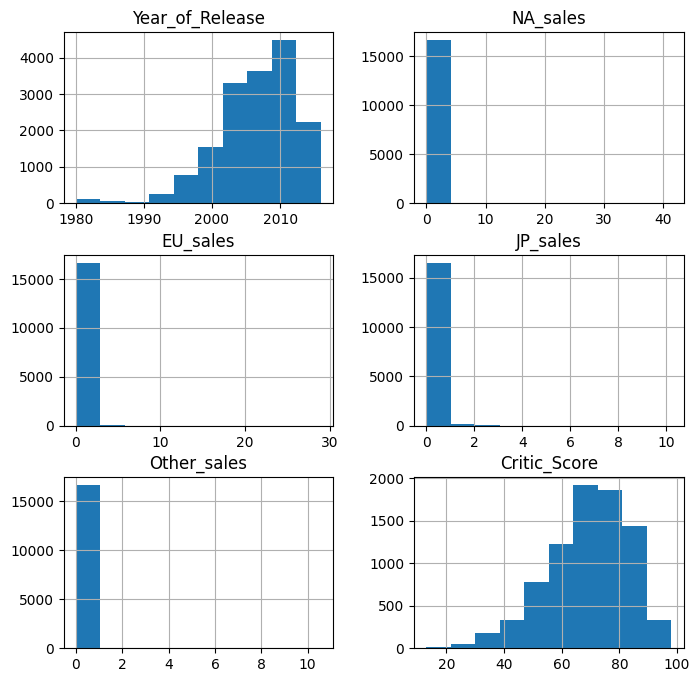

In [22]:
#Распределение необработанных данных
data.hist(figsize = (8,8));

## Предъобработка данных

### Замена названий столбцов

In [23]:
#Словарь для замены
column_names = {old_name: old_name.lower() if old_name != 'Name' else 'game_name' for old_name in list(data.columns)}

#Замена
data.rename(columns = column_names, inplace = True)

#Проверка
print(data.columns)

Index(['game_name', 'platform', 'year_of_release', 'genre', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score',
       'rating'],
      dtype='object')


### Преобразование данных в нужные типы

- platform - lower string
- year_of_release  - int16
- genre - - lower string 
- user_score - float64
- rating - lower string

Год релиза преобразуем в целое число (года это всегда целые числа). Пользовательскй рейтинг преобразуем в число с запятой чтобы с ним можно было работать как с числами. При этом установим параметр errors = 'coerce' чтобы в строчке 119 обработать ошибку и вместо символов tbd установить Nan. Столбцы со строковыми параметрами переведем в состояние lower чтобы было проще выявить дубликаты.

In [24]:
#Преобразование типа для числовых столбцов(year_of_release, user_score)
data.year_of_release = data.year_of_release.astype('Int16')
data.user_score = pd.to_numeric(data.user_score, errors = 'coerce')

#Преобразование строк в столбцах(name, genre, rating, platform) к состоянию lower 
data.game_name = data.game_name.str.lower()
data.rating = data.rating.str.lower()
data.genre = data.genre.str.lower()
data.platform = data.platform.str.lower()

In [25]:
data.sample(10)

game_name platform  \
16221                      winning post 7 maximum 2008      ps3   
14177  nhra drag racing: countdown to the championship      psp   
752                          yu-gi-oh: duel monsters 4       gb   
12983                                        bass rise       ps   
10755                            angry birds star wars     wiiu   
13724                   national geographic challenge!      ps3   
246                                         god of war      ps2   
4491                                      naughty bear      ps3   
8071                                 alone in the dark      wii   
1186        dragon quest v: hand of the heavenly bride       ds   

       year_of_release         genre  na_sales  eu_sales  jp_sales  \
16221             2008        sports      0.00      0.00      0.01   
14177             2007        racing      0.03      0.00      0.00   
752               2000  role-playing      0.00      0.00      2.17   
12983             1999        sports      0.03      0.02      0.00   
10755             2013      strategy      0.05      0.04      0.00   
13724             2011          misc      0.01      0.03      0.00   
246               2005        action      2.71      1.29      0.02   
4491              2010        action      0.18      0.18      0.00   
8071              2008     adventure      0.09      0.08      0.00   
1186              2008  role-playing      0.17      0.02      1.36   

       other_sales  critic_score  user_score rating  
16221         0.00           NaN         NaN    NaN  
14177         0.00           NaN         NaN    NaN  
752           0.01           NaN         NaN    NaN  
12983         0.00           NaN         NaN    NaN  
10755         0.01           NaN         6.8      e  
13724         0.01           NaN         NaN    NaN  
246           0.43          94.0         8.9      m  
4491          0.07          43.0         5.5      t  
8071          0.02          39.0         4.4      m  
1186          0.02          84.0         8.5   e10+

### Обработка пропусков 

In [26]:
#Суммарное количество пропусков
data.isna().sum()

game_name             2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Чтобы понять природу связи между пропусками используем библиотеку missingo

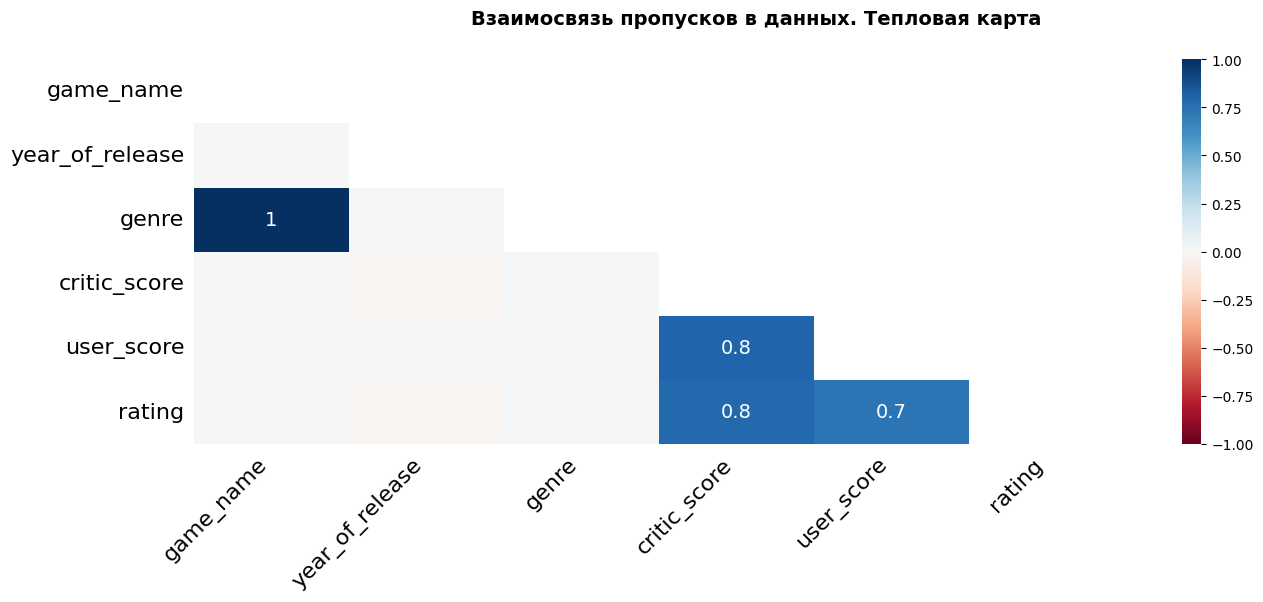

In [27]:
#Тепловая карта кореляции
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Взаимосвязь пропусков в данных. Тепловая карта', fontsize=14, fontweight='bold');

msno.heatmap(data, ax = axes);

На тепловой карте видно, что:
 - связь между имеющимися пропусками в названии игры и названии жанра 100%
 - между оценками пользователей и критиков 80 %
 - между рейтингами и оценками пользователей(критиков) 70 и 80% соответсвенно
 То есть большинство пропусков расположены в одних и тех же строчках, а значит они не совсем случайны.

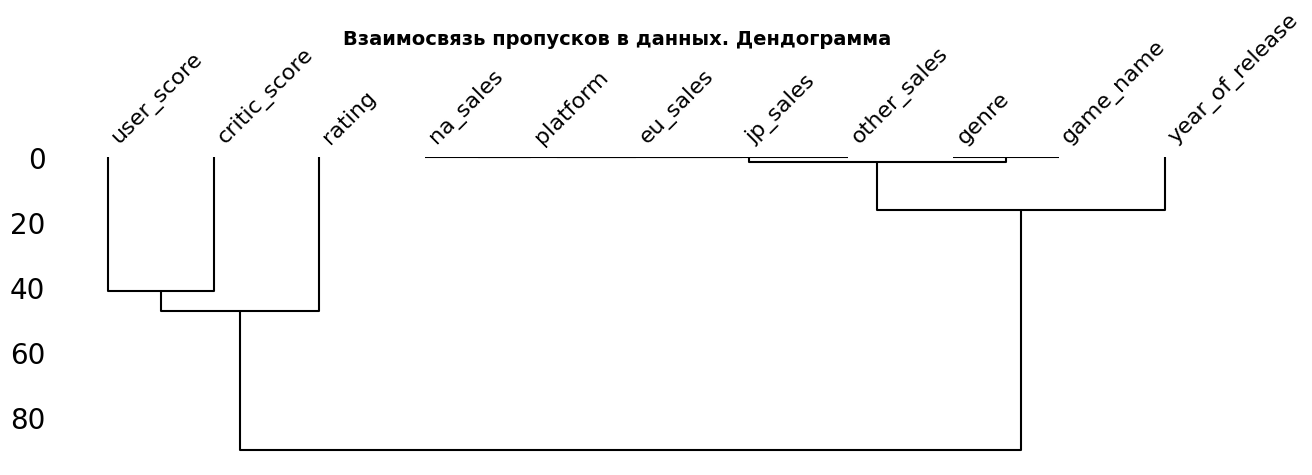

In [28]:
#Дендограмма
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 4))
fig.suptitle('Взаимосвязь пропусков в данных. Дендограмма', fontsize=14, fontweight='bold', y = 1.2);

msno.dendrogram(data, ax = axes);

На диаграмме виден первый и второй уровени связи между пропусками в порядке иерархии:
- оценки пользователей связаны с оценками критиков
- и те и другие связаны с рейтингами 

То есть удаляя строки с пропусками в оценках пользователей мы наиболее вероятно удалим большинство пропуски в оценках критиков и рейтингов

#### Предполагаемые методы обработки пропусков
В исследуемом датасете пропуски есть в колонках: name, year_of_release, genre, critic_score, user_score, rating.

1. В колонке name пропуски заполним подстановочным значением "Unknown" (имя игры не имеет значения для исследования)
2. Пропуски в данных о годе релиза, их будет менее 2% удалим, если более 2%, заполним заглушкой. Подойдет 0. Увидев его при анализе мы поймем, что это исскуственно созданное значение, и строки с ним не стоит рассматривать в разрезе временных исследований. 
3. В колонке genre найдем значение по имени игры используя интернет. Если имя игры также будет отсутсвовать, удалим эти строки (их крайне мало и удаление не повлияет на датасет в целом)
4. В колонке rating это величина, которую нельзя угодать она индивидуальна для каждой игры и не поддается усреднению. Ее можно заполнить двумя способами. 1. Найти все названия игр с отсутсвующими рейтингами и подобрать для них рейтинги в интернете на сайте Entertainment Software Rating Board. 2. Поставить заглушку "Unknown". 
5. Клонки critic_score, user_score крайне важны для второго этапа исследования. При этом проусков в них слишком много. Удалять их точно нельзя, но и заполнять опасно, можно изменить реальную картину исскуственно внесенными в нее данными. 

Относительно указанных колонок можно проработать два варианта: 

1. Заполнить даннные заглушками и на втором этапе исследования (где изучается зависимость между продажами и оценка пользователей/критиков) эти данные игпонировать или 
2. Заполнить данные медианными значениями по характерным группам с учетом нескольких объединяющих факторов (регион + год + платформа + жанр). Если статистически предложенная историческая выборка не измениться (распределения до и после замены в целом останутся одинаковыми, можно утвердить второй метод).

#### Замена пропусков в столбце "game_name"

In [29]:
#Замена пропусков в именах
data.game_name.fillna(value = "unknown", inplace = True)

#Нули в genre
display(data[data['genre'].isna()])

game_name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659     unknown      gen             1993   NaN      1.78      0.53      0.00   
14244   unknown      gen             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN

Так как ни жанр ни название игры ни оценки критиков неизвестны - удаляем эти строки, они неинформативны.

#### Обработка пропусков в столбце "genre"

In [30]:
#Удаляем Нули в genre
data.dropna(subset = ['genre'], axis = 0, inplace = True)

In [31]:
display(data.query('year_of_release.isna()').platform.unique())

array(['ps2', 'wii', '2600', 'x360', 'gba', 'pc', 'ps3', 'ps', 'psp',
       'xb', 'gb', 'ds', 'gc', '3ds', 'n64', 'psv'], dtype=object)

#### Замена пропусков в столбце "year_of_release"

In [32]:
#Данные о количестве пропущенных значений в столбце year_of_release
ratio = data.year_of_release.isna().sum()/len(data)

#Обрабатываем пропуски
data =  clean_with_ratio(data, 0.02, ratio, "year_of_release", "год релиза", value_for_replace = 1)  

Доля удаленных записей в категории год релиза: 1.6%


#### Замена пропусков в столбце "rating"

In [33]:
#Список всех пар названийе игры - платформа, у которых нет рейтинга
games_without_rating = []
data[data.rating.isna()].apply(lambda row: games_without_rating.append(", ".join([str(row.platform), str(row.game_name)])), axis = 1);

In [34]:
print(len(games_without_rating))
print("Первые десять пар название игры - платформа, у которых нет рейтинга \n", games_without_rating[:10])

6676
Первые десять пар название игры - платформа, у которых нет рейтинга 
 ['nes, super mario bros.', 'gb, pokemon red/pokemon blue', 'gb, tetris', 'nes, duck hunt', 'ds, nintendogs', 'gb, pokemon gold/pokemon silver', 'snes, super mario world', 'ds, pokemon diamond/pokemon pearl', 'gb, super mario land', 'nes, super mario bros. 3']


Все пары игра-платформа, у которых нет рейтинга выделены, но на сайте Entertainment Software Rating Board нет списка игр, который бы можно было скачать, распарсить и сопоставить с найденными парами. А проверять 6764 игры вручную нереально, поэтому предлагается заменить пропуски на заглушку "unknown". В дальнейшем для ТОП-10 игр можно будет найти рейтинги в ручную.

In [35]:
#Замена пропусков в рейтинге 
data.rating.fillna(value = "unknown", inplace = True)

#### Замена пропусков в столбцах "critic_score" и "user_score"

##### Замена пропусков в столбцах "critic_score" и "user_score" заглушками

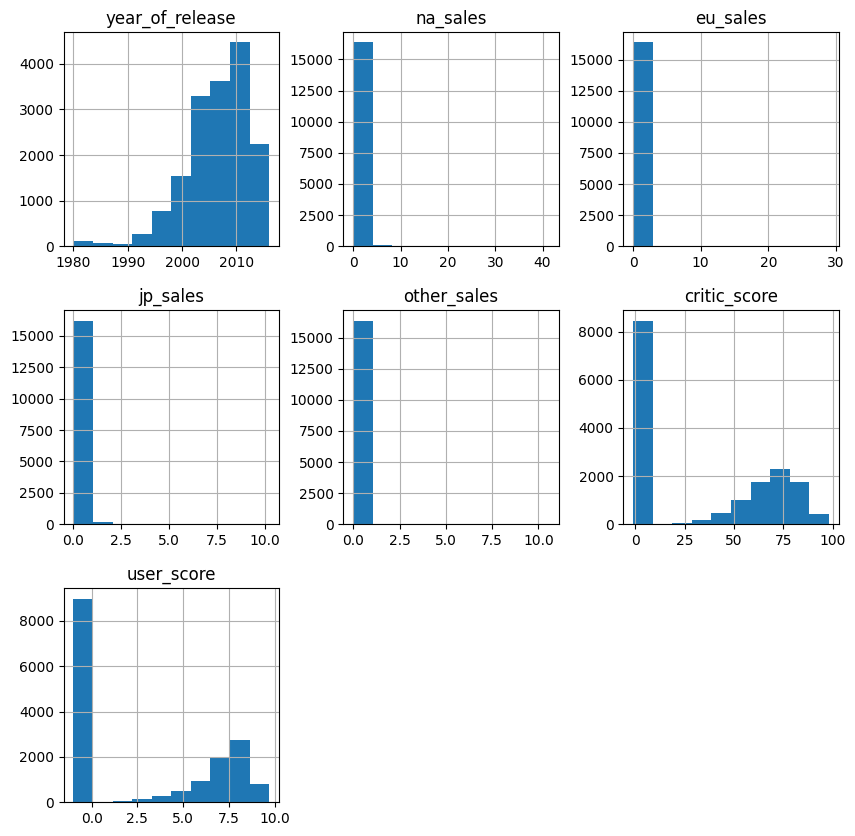

In [36]:
#Создаем датасет с рейтингами - заглушками. В качестве заглушек будем использовать -1.
data_minuses = deepcopy(data)
data_minuses.critic_score.fillna(value = -1, inplace = True)
data_minuses.user_score.fillna(value = -1, inplace = True)

#Проверяем распределение
data_minuses.hist(figsize = (10,10));

По гистограммам видно, что вид распределения не изменился, но при этом очевидно какой значительный кусок данных мы теряем исключая из исследования строки с пропущенными рейтингами и оценками. Посмотрим, что будет, если заполнить их согласно предполагаемому алгоритму

##### Замена пропусков в столбцах "critic_score" и "user_score" расчетными значениями

In [37]:
#замена пропущенных значений в столбцах 'critic_score', 'user_score'  медианной, рассчитанной по записям 
#с идентичными категориями "year_of_release", "platform", "genre"
not_fill_critics = fill_by_group(data, 'critic_score')
not_fill_users = fill_by_group(data, 'user_score')

Заменено медианными значениями 6248 позиций в столбце critic_score. Не заменено 2213 позиций, так как отсутсвуют медианные значения для совокупности групповых критериев (год, платформа, жанр игры)
Заменено медианными значениями 6957 позиций в столбце user_score. Не заменено 2024 позиций, так как отсутсвуют медианные значения для совокупности групповых критериев (год, платформа, жанр игры)


#### Оценка оставшихся пропусков
Посмотрим на взаимосвязь между оставшимяся пропущенными значениями

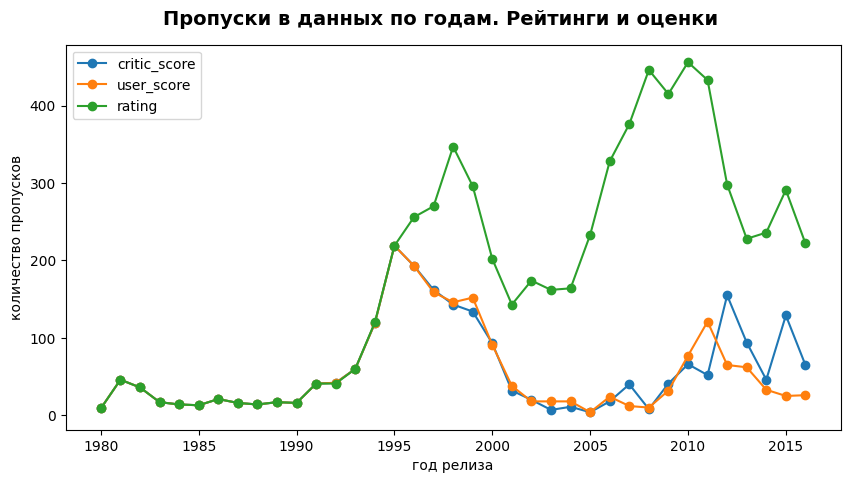

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Пропуски в данных по годам. Рейтинги и оценки', fontsize=14, fontweight='bold', y = 0.95);

data[(data.critic_score.isna()) & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes)

data[(data.user_score.isna()) & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes);

data[(data.rating == 'unknown') & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes, xlabel = "год релиза", ylabel = "количество пропусков");

plt.legend(["critic_score", "user_score", "rating"]);

Однозначно известно, что Entertainment Software Rating Board была создана в 1995 году, то есть рейтингов до 1995 года у игр быть не может. Кроме того, наиболее вероятно, что на временном отрезке до 1995 года множества записей с отсуствующими данными по оценкам критиков и пользователей, а также рейтингами полностью совпадают(пересакаются). Посчитаем долю таких записей относительно размера начального датасета и удалим их, если их доля не превышает 5%.

In [39]:
#Данные о количестве пропущенных значений в столбце critic_score до 1995 года
ratio = \
(data[data["year_of_release"] < 1996].critic_score.isna().sum() + \
data[(data["year_of_release"] < 1995) & (data["critic_score"].notna())].user_score.isna().sum())/inital_len 

norma_for_ratio = 0.05
#Обрабатываем пропуски
if ratio == 0:
    print(f'В датасете нет пустых значений в столбцах critic_score, user_score')
elif ratio < norma_for_ratio:
    data = data.loc[(data.year_of_release > 1995)|((data.year_of_release < 1995) & (data.critic_score.notna()))]
    data = data.loc[(data.year_of_release > 1995)|((data.year_of_release < 1995) & (data.user_score.notna()))]
    print(f'Общая доля удаленных записей: {(inital_len-len(data))/inital_len:.1%}')
else:
    print(f'Доля пропущенных записей составила: {ratio:.1%}, что выше заданной нормы. Записи не удалены')


Общая доля удаленных записей: 5.8%


In [40]:
#Суммарное количество пропусков
data.isna().sum()

game_name             0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       1513
user_score         1324
rating                0
dtype: int64

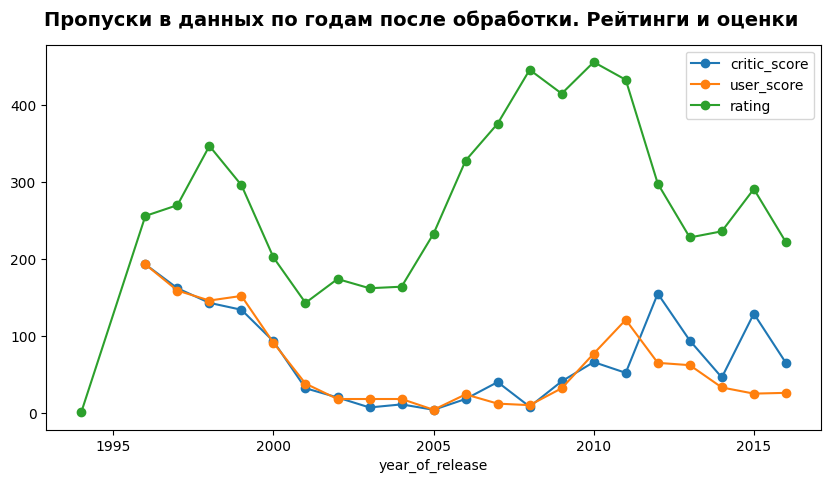

In [41]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Пропуски в данных по годам после обработки. Рейтинги и оценки', fontsize=14, fontweight='bold', y = 0.95);

data[(data.critic_score.isna()) & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes)

data[(data.user_score.isna()) & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes);

data[(data.rating == 'unknown') & (data.year_of_release > 1970)]\
.pivot_table(index = 'year_of_release', values = 'game_name', aggfunc = 'count')\
.plot(figsize = (10,5), style = '-o', ax = axes);

plt.legend(["critic_score", "user_score", "rating"]);

#### Выводы по обработке пропусков
После обработки пропусков остались явные пропуски в оценках пользователей и критиков после 1995 года. Остальные пропуски были либо удалены либо заполнены подстановочными значениями. Оставшиеся пропуски в оценках заполнять нецелесообразно:
- корректно рассчитать их не получиться, так как в рассмотренных группировках для пропущенных записей отсутсвуют данные для расчета медианы;
- при заполнении их подстановочными значениями повышается риск случайного внесения ошибки в средние или медианные значения (если назначим пропускам отрицательное значение (например, -1), при сложении это приведет к занижению сумм, если положительное (например, 101), это приведет к завыению сумм)

####  Характер распределения (гистограмм) после замены пропусков

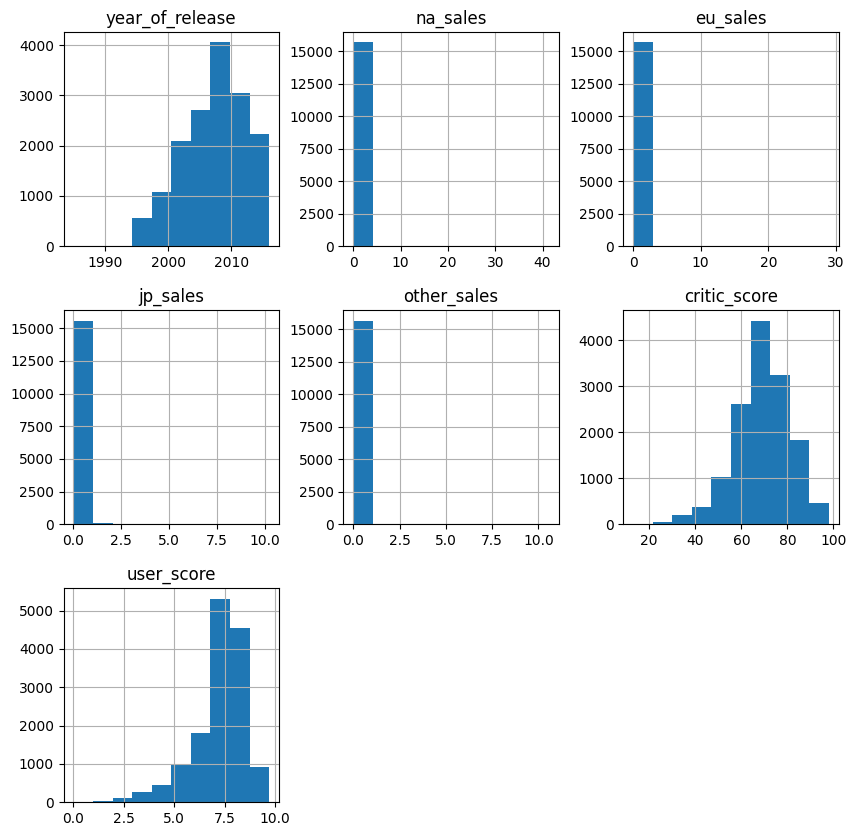

In [42]:
data.hist(figsize = (10, 10));

*Это выводы, которые были написаны мной в самом начале обучения на DS*:

Обработка пропусков не вызвала значительных изменений в характере распределений частотных значений для числовых столбцов датасета

*В конце обучения я бы такое не написала, так как очевидно, что такое визуальное сравнение распределений - это далеко не самый точный метод. Поэтому конечно если проводить серьезное сравнение, то надо пользоваться t-тестом или каким-нибудь непараметрическим тестом (например Манна-Уитни)*

### Поиск дубликатов
#### Проверка явных дубликатов

In [43]:
#Проверка на явные дубликаты
print(f'В данных имеется {data.duplicated().sum()} явных дубдикатов')

В данных имеется 0 явных дубдикатов


#### Проверка неявных дубликатов
##### Проверка неявных дубликатов в столбце "game_name"

In [44]:
#Количество уникальных названий игр
print(f'Количество "уникальных" названий игр до обработки дубликатов {data["game_name"].nunique()}')

Количество "уникальных" названий игр до обработки дубликатов 10828


In [45]:
#Количество уникальных названий платформ
print(f'Количество "уникальных" названий платформ до обработки дубликатов {data["platform"].nunique()}')
display(data["platform"].unique())

Количество "уникальных" названий платформ до обработки дубликатов 24


array(['wii', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'gba', 'ps4', '3ds',
       'n64', 'ps', 'xb', 'pc', 'psp', 'xone', 'wiiu', 'gc', 'snes', 'dc',
       'psv', 'sat', 'ws', 'ng', 'pcfx'], dtype=object)

Среди названий платформ нет неявных дубликатов

##### Проверка неявных дубликатов в столбце "rating"

In [46]:
#Количество уникальных названий рейтингов
print(f'Количество "уникальных" названий рейтингов до обработки дубликатов {data["rating"].nunique()}')
display(data["rating"].unique())

Количество "уникальных" названий рейтингов до обработки дубликатов 9


array(['e', 'unknown', 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'],
      dtype=object)

Среди названий рейтингов есть неявные дубликаты, это названия 'e' и 'k-a'. Но мы обработаем их позже, в разделе 3.5.3.5. Дубликаты среди названий игр не проверялись, так как они там 100% будут, потому что одна и та же игра может выходить на нескольких разных платформах.

### Поиск экстримальных (ошибочных) значений
#### Поиск экстримальных (ошибочных) значений в столбцах "user_score"  и "critic_score"

Проверка отсутсвия значений оценок пользователей и критиков вне установленных границ (оценки пользователей от 0 до 10, оценки критиков от 0 до 100)

In [47]:
#Количество неверных пользовательских рейтингов
print(f" Значения оценок пользователей выходят за границы допустимых диапазонов для {len(data.query('user_score > 10 or user_score < 0'))} записей")

#Количество неверных рейтингов критиков
print(f" Значения оценок критиков выходят за границы допустимых диапазонов для {len(data.query('critic_score > 100 or critic_score < 0'))} записей")

 Значения оценок пользователей выходят за границы допустимых диапазонов для 0 записей
 Значения оценок критиков выходят за границы допустимых диапазонов для 0 записей


#### Поиск экстримальных (ошибочных) значений в столбцах "na_sales", "eu_sales", "jp_sales" и "other_sales"
Введем следующие правила:
1. Если игра есть в списке, значит она должна быть продана хотя бы один раз.  
2. Если количесвтво продаж игры в одном или нескольких регионах равно нулю, значит в этом(этих) регионах она не продавалась. 
3. При анализе продаж по регионам игры, которые в этих регионах не продавались, не учитываются. 
4. Если сумма продаж по всем регионам и остальных продаж равна нулю, то это следует считать экстримальным значеним и удалять такие строчки. 

##### Игры, которые не продавались ни разу нигде

In [48]:
#Игры, которые не продавались
display(data.query('na_sales + eu_sales + jp_sales + other_sales == 0'))

game_name platform  \
16676                                  g1 jockey 4 2008      ps3   
16709  score international baja 1000: the official game      ps2   

       year_of_release   genre  na_sales  eu_sales  jp_sales  other_sales  \
16676             2008  sports       0.0       0.0       0.0          0.0   
16709             2008  racing       0.0       0.0       0.0          0.0   

       critic_score  user_score   rating  
16676          67.0        7.05  unknown  
16709          56.0        7.45  unknown

In [49]:
#Выкидываем две игры с нулевыми продажами
data = data.query('na_sales + eu_sales + jp_sales + other_sales > 0')

##### Статистика по продажам по америке

In [50]:
data.query('na_sales > 0').na_sales.describe()

count    11636.000000
mean         0.340840
std          0.818762
min          0.010000
25%          0.060000
50%          0.130000
75%          0.330000
max         41.360000
Name: na_sales, dtype: float64

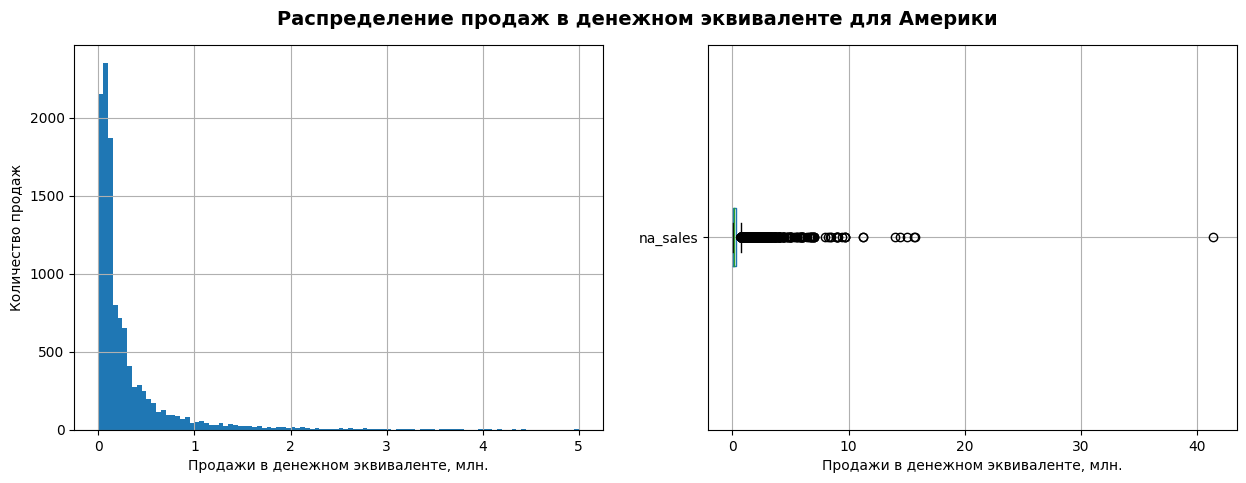

In [51]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение продаж в денежном эквиваленте для Америки', fontsize=14, fontweight='bold', y = 0.95);

#Гистограмма для данных по продажам по америке
data.query('na_sales > 0').na_sales.hist(bins = 100, range = (0, 5), ax = axes[0])
axes[0].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[0].set_ylabel('Количество продаж')

#Диаграмма с усами для данных по продажам по америке
data.query('na_sales > 0').boxplot(column = ['na_sales'], vert = False, grid = True, figsize = (10, 5), ax = axes[1])
axes[1].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[1].set_ylabel('');

In [52]:
display(data.query('na_sales > 10'))

game_name platform  year_of_release         genre  \
0                  wii sports      wii             2006        sports   
2              mario kart wii      wii             2008        racing   
3           wii sports resort      wii             2009        sports   
4    pokemon red/pokemon blue       gb             1996  role-playing   
6       new super mario bros.       ds             2006      platform   
7                    wii play      wii             2006          misc   
8   new super mario bros. wii      wii             2009      platform   
14         kinect adventures!     x360             2010          misc   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
0      41.36     28.96      3.77         8.45          76.0         8.0   
2      15.68     12.76      3.79         3.29          82.0         8.3   
3      15.61     10.93      3.28         2.95          80.0         8.0   
4      11.27      8.89     10.22         1.00           NaN         NaN   
6      11.28      9.14      6.50         2.88          89.0         8.5   
7      13.96      9.18      2.93         2.84          58.0         6.6   
8      14.44      6.94      4.70         2.24          87.0         8.4   
14     15.00      4.89      0.24         1.69          61.0         6.3   

     rating  
0         e  
2         e  
3         e  
4   unknown  
6         e  
7         e  
8         e  
14        e

##### Статистика по продажам по европе

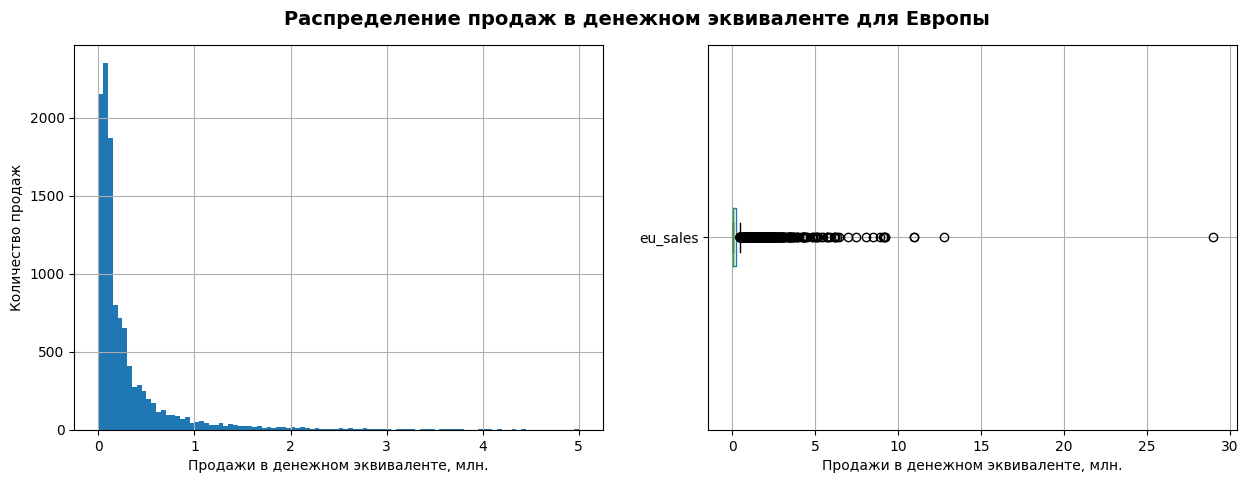

In [53]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение продаж в денежном эквиваленте для Европы', fontsize=14, fontweight='bold', y = 0.95);

#Гистограмма для данных по продажам по америке
data.query('na_sales > 0').na_sales.hist(bins = 100, range = (0, 5), ax = axes[0])
axes[0].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[0].set_ylabel('Количество продаж')

#Диаграмма с усами для данных по продажам по америке
data.query('eu_sales > 0').boxplot(column = ['eu_sales'], vert = False, grid = True, figsize = (10, 5), ax = axes[1])
axes[1].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[1].set_ylabel('');

##### Статистика по продажам по Японии

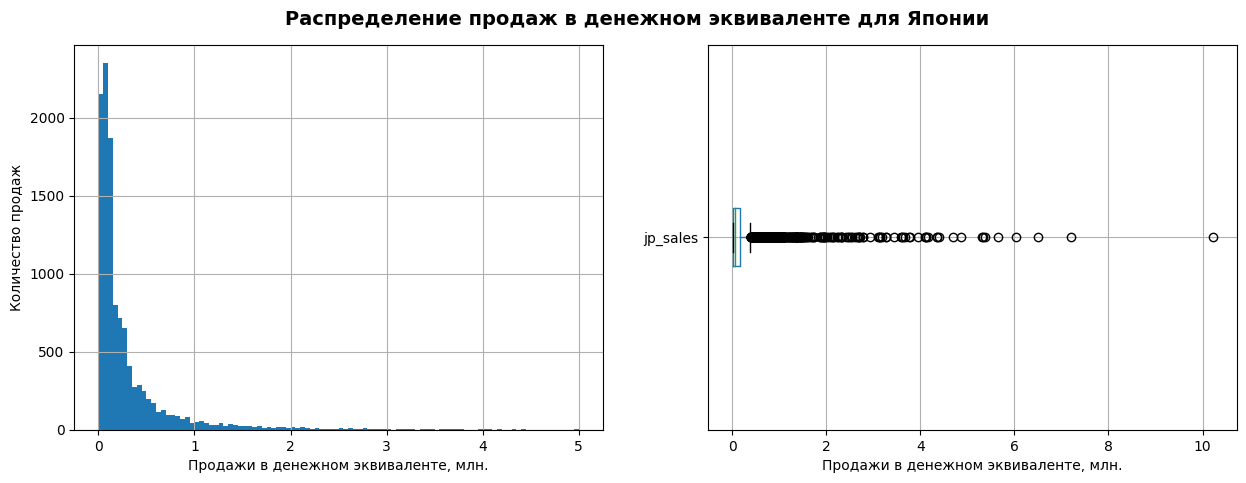

In [54]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение продаж в денежном эквиваленте для Японии', fontsize=14, fontweight='bold', y = 0.95);

#Гистограмма для данных по продажам по америке
data.query('na_sales > 0').na_sales.hist(bins = 100, range = (0, 5), ax = axes[0])
axes[0].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[0].set_ylabel('Количество продаж')

#Диаграмма с усами для данных по продажам по америке
data.query('jp_sales > 0').boxplot(column = ['jp_sales'], vert = False, grid = True, figsize = (10, 5), ax = axes[1])
axes[1].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[1].set_ylabel('');

##### Статистика по другим продажам

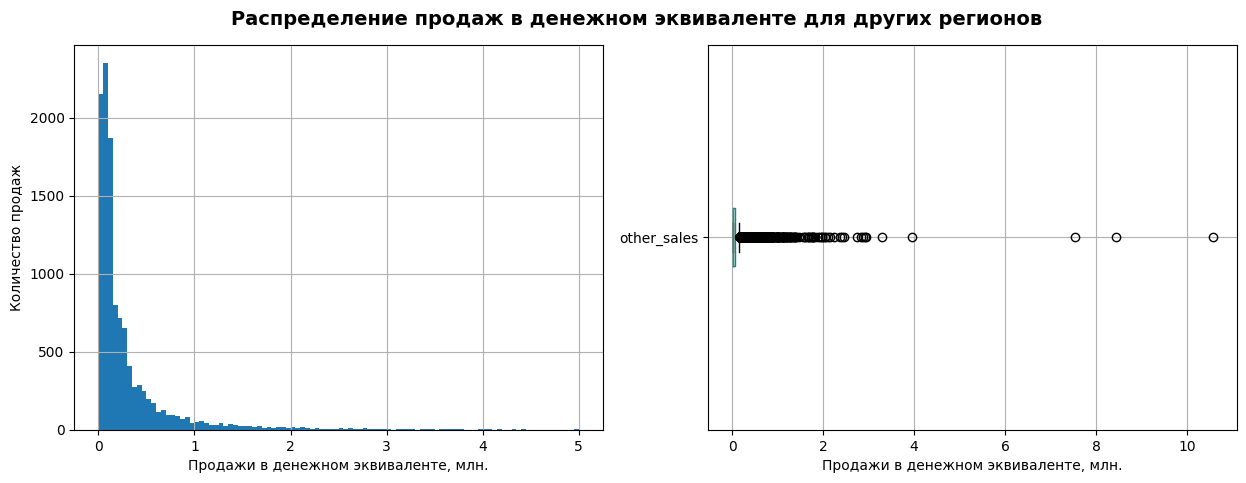

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение продаж в денежном эквиваленте для других регионов', fontsize=14, fontweight='bold', y = 0.95);

#Гистограмма для данных по продажам по америке
data.query('na_sales > 0').na_sales.hist(bins = 100, range = (0, 5), ax = axes[0])
axes[0].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[0].set_ylabel('Количество продаж')

#Диаграмма с усами для данных по продажам по америке
data.query('other_sales > 0').boxplot(column = ['other_sales'], vert = False, grid = True, figsize = (10, 5), ax = axes[1])
axes[1].set_xlabel("Продажи в денежном эквиваленте, млн.")
axes[1].set_ylabel('');

Очевидно, что количество продаж очень сильно разбросано по выборке от величин, стремящихся к нулю, до 40 миллионов. Но основания назвать эти данные ошибочными отсутствуют. Поэтому из датасета удалены только две строки с играми, которые якобы нигде и никогда не продавались.

#### Добавление данных для дальнейшей группировки
##### Добавление данных для дальнейшей группировки по вендерам

In [56]:
#Расчет вендера    
data['vender'] = data.platform.apply(calc_vender_type)

##### Добавление данных для дальнейшей группировки по формфактору

In [57]:
#Типы формфакторов (ручные, стационарные, ПК)
list_by_form = ['portable', 'console','pc']

#Расчет формфактора для ДФ    
data['form'] = data.platform.apply(calc_form_type)

##### Добавление данных для дальнейшей группировки по оценкам критиков

In [58]:
#Расчет уровня оценки критика   
data['critic_type'] = data.critic_score.apply(calc_critic_type)

##### Добавление данных для дальнейшей группировки по оценкам пользователей

In [59]:
#Расчет уровня оценки пользователя    
data['user_type'] = data.user_score.apply(calc_user_type)

##### Добавление данных для дальнейших исследований по рейтингу
В дальнейшем, чтобы строить диаграммы рассеяния для выявления связи между рейтингами и продажи будет необходимо некое числовое значение, эквивалентное каждому типу рейтинга. Назначим его.

In [60]:
#Все представленные в датасете рейтинги
data.rating.unique()

array(['e', 'unknown', 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'],
      dtype=object)

В датасете присутсвуют следующие рейтинги:
  - 'rp' - «Рейтинг ожидается»: rating_score
  - 'unknown' -не определен в ДФ: rating_score 
  - 'e' - «Для всех»: rating_score
  - 'k-a' -  "Kids to Adults" (то же самое, что 'e' - «Для всех») rating_score
  - 'ec' - «Для детей младшего возраста»: rating_score
  - 'e10+' - «Для всех от 10 лет и старше»: rating_score
  - 't' - «Подросткам»: rating_score
  - 'm' - «Для взрослых»: rating_score
  - 'ao' - «Только для взрослых»: rating_score

Распределим рейтинги по степени "взрослости". Чем выше возрастной ценз, тем выше значение рейтинга.
Используя цифровые эквиваленты рейтинга мы автоматически избавимся от дубликатов. При этом  объединим:
- два означающих одно и тоже рейтинга 'e' и 'k-a' и близкий к ним по значению рейтинг 'ec' в группу (1)
- два рейтинга для детей старшего возраста 'e10+' и подростков 't' в группу (2)
- два рейтинга для взрослых 'm' и 'ao' в группу (3)

In [61]:
#Расчет цифрового рейтинга    
data['rating_score'] = data.rating.apply(calc_rating_score)

#### Добавление данных о суммарных продажах

In [62]:
data['all_sales'] = data[['na_sales', 'eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

In [63]:
data.sample(2)

game_name platform  year_of_release      genre  na_sales  \
8977  guilty gear x2 #reload       xb             2004   fighting      0.11   
3717    hotel dusk: room 215       ds             2007  adventure      0.26   

      eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
8977      0.03      0.00         0.01          86.0         7.6      t   
3717      0.04      0.22         0.03          78.0         8.6      t   

         vender      form critic_type user_type  rating_score  all_sales  
8977  microsoft   console        high      high             2       0.15  
3717   nintendo  portable        high      high             2       0.55

#### Выводы о результатах предъобработки
Предъобработка данных завершена. 

1. Названия всех столбцов приведены к стилю snake_case с использованием символов нижнего регистра. При этом столбец Name переименован в game_name чтобы не нарушать работу методов pandas.
2. Данные в столбцах приведены к оптимальным типам:
- столбец "year_of_release"  - в целое число (int);
- столбец "user_score" - в число с плавающей запятой (float);
- столбцы со строковыми параметрами - в состояние lower.
3. Проведена обработка пропусков, включающая:
- анализ природы связи между имеюшимися пропусками;
- контроль формы расспределения значений в датасете до и после обработки;
- исключение из датасета строк с пропусками в столбцах "genre";
- заполнение подстановочными значениями пропусков в столбцах "rating"(заглушка "unknown"), "game_name" (заглушка "unknown");
- заполнение пропусков в столбцах "user_score", "critic_score" медианными значениями по характерным группам с учетом нескольких объединяющих факторов (регион + год + платформа + жанр), там, где их можно рассчитать, с сохранением пропусков там, где рассчитать медианные значения не удалось из-за недостатка данных.
4. Проведена проверка на дубликаты по столбцам "rating", "platform" и обработка дубликатов в столбце rating
5. Проверены ошибки в данных. Удалены строки с некорректными данными по продажам.
6. В датасет добавлены столбцы:
- "vender" - для категоризации данных по производителям платформ;
- "form" - для категоризации данных по типу платформ (мобильные, консольные);
- "critic_type" - для категаризации данных по группам оценок критиков (высокие, низкие, средние);
- "user_type" - для категаризации данных по группам оценок пользователей (высокие, низкие, средние);
- "rating_score" - для категаризации данных по возрастным группам рейтингов (0 - 'rp' и 'unknown',  1 - 'e' и 'k-a', 2 - 'ec', 3 - 'e10+', 4 - 't', 5 - 'm', 6 - 'ao')
- "all_sales" - с данными о суммарных продажах по всем регионам.

В результате предъобработки суммарно удалено 5.8% записей и при этом статичстические показатели данных не изменились, а оставшиеся записи стали более пригодными для дальнейшего анализа. 

In [64]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15742 entries, 0 to 16714
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_name        15742 non-null  object 
 1   platform         15742 non-null  object 
 2   year_of_release  15742 non-null  Int16  
 3   genre            15742 non-null  object 
 4   na_sales         15742 non-null  float64
 5   eu_sales         15742 non-null  float64
 6   jp_sales         15742 non-null  float64
 7   other_sales      15742 non-null  float64
 8   critic_score     14229 non-null  float64
 9   user_score       14418 non-null  float64
 10  rating           15742 non-null  object 
 11  vender           15742 non-null  object 
 12  form             15742 non-null  object 
 13  critic_type      15742 non-null  object 
 14  user_type        15742 non-null  object 
 15  rating_score     15742 non-null  int64  
 16  all_sales        15742 non-null  float64
dtypes: Int16(1),

### Исследовательский анализ данных. Первый этап
- изучение группировки по годам (количество игр, важные временные периоды);
- изучение группировки по плаформам (выбор наиболее популярных платформ, углубленный анализ срезов по годам, определение сроков "жизненного цикла" платформ);
- изучение временных характеристик "продаваемости" по платформама (какие лидируют, какие растут, какаие падают);
- выбор нескольких потенциальнорибыльных платформ;
- выводы первого этапа исследования, принятие решения о способах выбора временного периода, на основании которого целесообразно строить предположения о продажах (прогноз) на следующий (в данныом случае) 2017 год;

#### Изучение группировки по годам (количество игр, важные временные периоды)

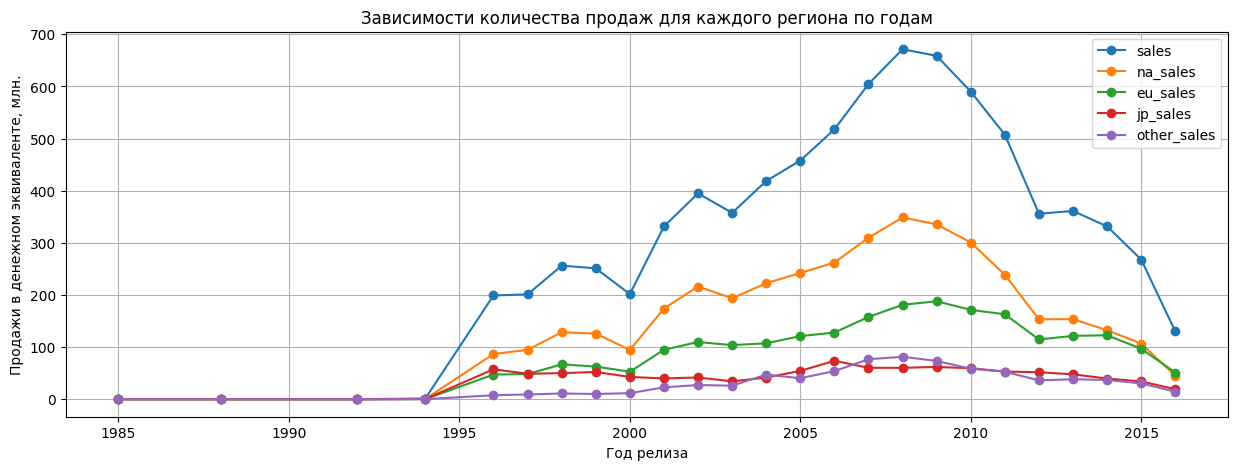

In [65]:
#Подсчёт количества продаж для каждого региона по годам
data.groupby(by = ['year_of_release'])\
.agg(sales = ('all_sales', 'sum'), na_sales = ('na_sales', 'sum'), eu_sales = ('eu_sales', 'sum'), \
     jp_sales = ('jp_sales', 'sum'), other_sales = ('other_sales', 'sum'))\
.plot(style = '-o', figsize = (15,5), grid = True, \
      xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
      title = "Зависимости количества продаж для каждого региона по годам");

In [66]:
# Подсчёт количества продаж для каждого региона по годам
display(data[data['year_of_release'] < 1996])


game_name platform  year_of_release       genre  na_sales  \
1567   battle arena toshinden       ps             1994    fighting      0.39   
10037             primal rage       ps             1994    fighting      0.06   
14470               alter ego       pc             1985  simulation      0.00   
14610                    doom       pc             1992     shooter      0.02   
14621                 simcity       pc             1988  simulation      0.00   

       eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
1567       0.26      0.53         0.08          69.0         6.3        t   
10037      0.04      0.00         0.01          69.0         6.3  unknown   
14470      0.03      0.00         0.01          59.0         5.8        t   
14610      0.00      0.00         0.00          85.0         8.2        m   
14621      0.02      0.00         0.01          64.0         2.2     e10+   

      vender     form critic_type user_type  rating_score  all_sales  
1567    sony  console      middle    middle             2       1.26  
10037   sony  console      middle    middle             0       0.11  
14470     pc       pc      middle    middle             2       0.04  
14610     pc       pc        high      high             3       0.02  
14621     pc       pc      middle       low             2       0.03

1. Очевидно, что в датасете отсутствуют полноценные данные о продажах игр до 1996. 
2. Большинство записей до 1996 года изготовлены для ПК. Что ожидаенмо, ведь до 1996 игровая индустрия только начинала проявляться, игр и платформ быдо мало, продаж но ним тоже. С учетом изложенного представляется возможным временной период до 1995 не рассматривать.  
3. Анализируя информативный временной период можно заметить, что с 1995 года до 2012 года продажи игр по всем регионам кроме Японии в целом возрастали, а с 2012 в целом начали падать. При этом есть несколько локальных падений: в 2000 и в 2004 годах.
4. Тенденция падения продаж возможно связана с расцветом инди-сектора (с 2010 до 2015 года) и финансовым кризисом 2008 года.
5. Вместе с тем количество продаж по Японии по рассматриваемому временному периоду распределено относительно равноверно. Можно отметить очень медленный рост до 2006 года и очень плавное падение до 2016.
6. Чтобы "зацепить" имеющиеся тенденции к росту или падению надо рассматривать данные минимум за два предыдущих года до той даты, для которой будет строиться предсказание.

In [67]:
#Подсчёт количества продаж для каждого типа оценки по годам
sales_by_score = data.pivot_table(index = 'year_of_release', columns = ['user_type', 'critic_type'], values = 'all_sales', aggfunc = 'sum')
display(sales_by_score.head(10))

user_type          high             low            middle           
critic_type        high low middle high low middle   high low middle
year_of_release                                                     
1985                NaN NaN    NaN  NaN NaN    NaN    NaN NaN   0.04
1988                NaN NaN    NaN  NaN NaN   0.03    NaN NaN    NaN
1992               0.02 NaN    NaN  NaN NaN    NaN    NaN NaN    NaN
1994                NaN NaN    NaN  NaN NaN    NaN    NaN NaN   1.37
1996             186.76 NaN    NaN  NaN NaN    NaN  12.39 NaN    NaN
1997             200.57 NaN   0.50  NaN NaN    NaN    NaN NaN    NaN
1998             243.62 NaN   3.84  NaN NaN    NaN    NaN NaN   8.85
1999             196.88 NaN  49.97  NaN NaN    NaN   0.25 NaN   4.01
2000             119.34 NaN  41.35  NaN NaN   0.37   9.26 NaN  31.34
2001             208.70 NaN  71.43  NaN NaN   0.01   7.10 NaN  44.22

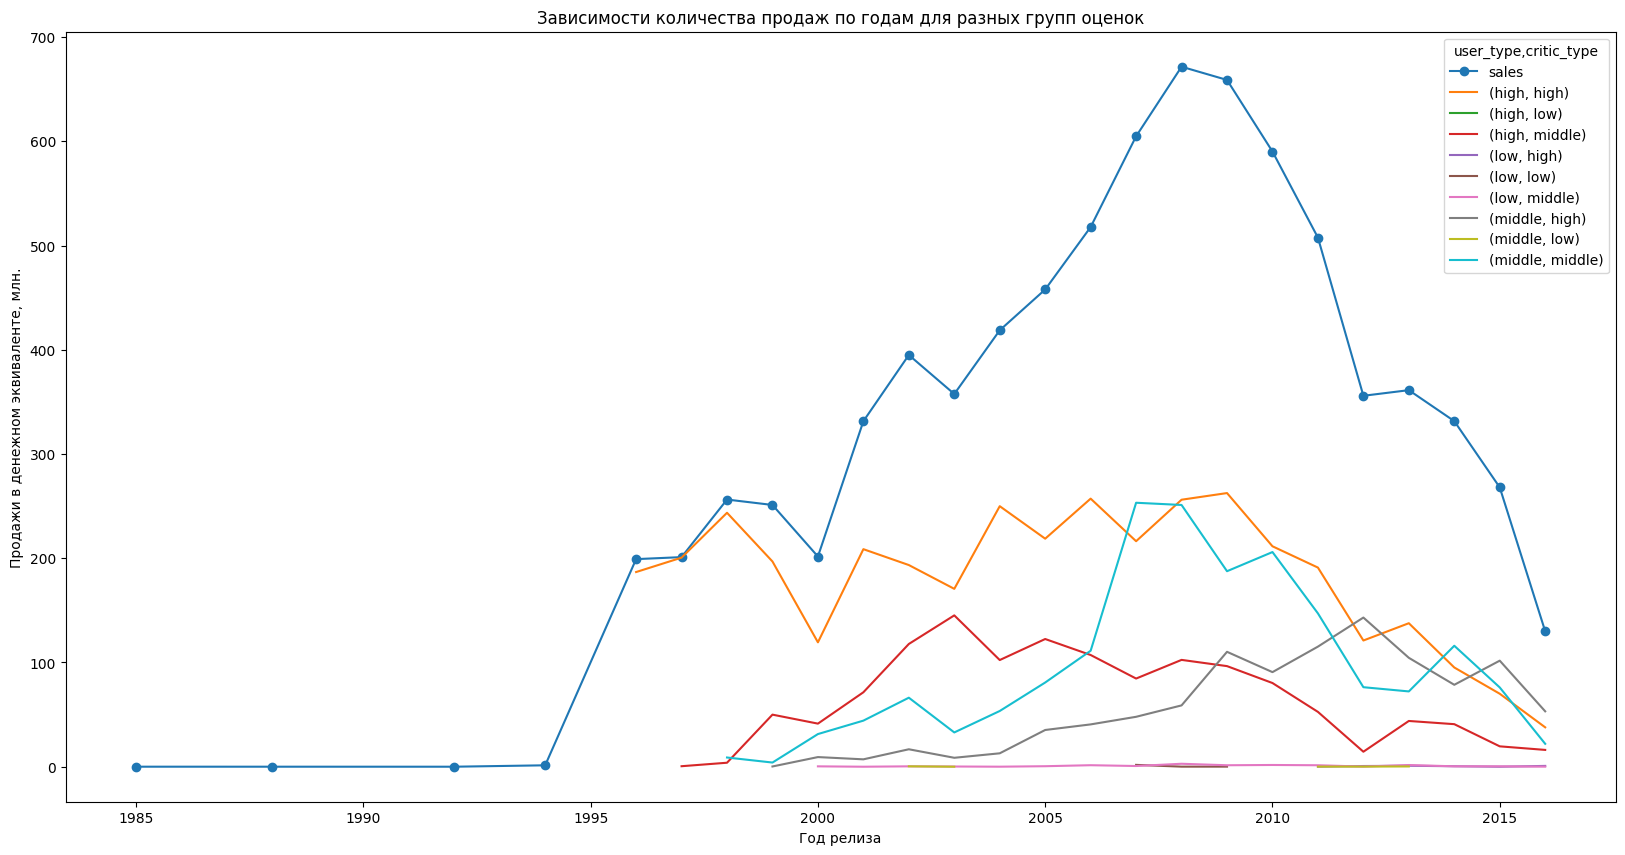

In [68]:
#Зависимость количества продаж по годам для разных групп оценок
axes = data.groupby(by = ['year_of_release']).agg(sales = ('all_sales', 'sum'))\
.plot(style = '-o', figsize = (15,5), grid = True);

sales_by_score.plot(figsize = (20, 10), ax = axes, \
                    xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
                    title = "Зависимости количества продаж по годам для разных групп оценок");

Внешний вид графиков несколько испорчен выбросом 1985 года. С учетом ранее пиведенных выкладок очевидно, что игры, выпушенные до 1995 года имеют околонулевые продажи. Они не показательны для нашего исследования и их можно удалить и перестроить графики.

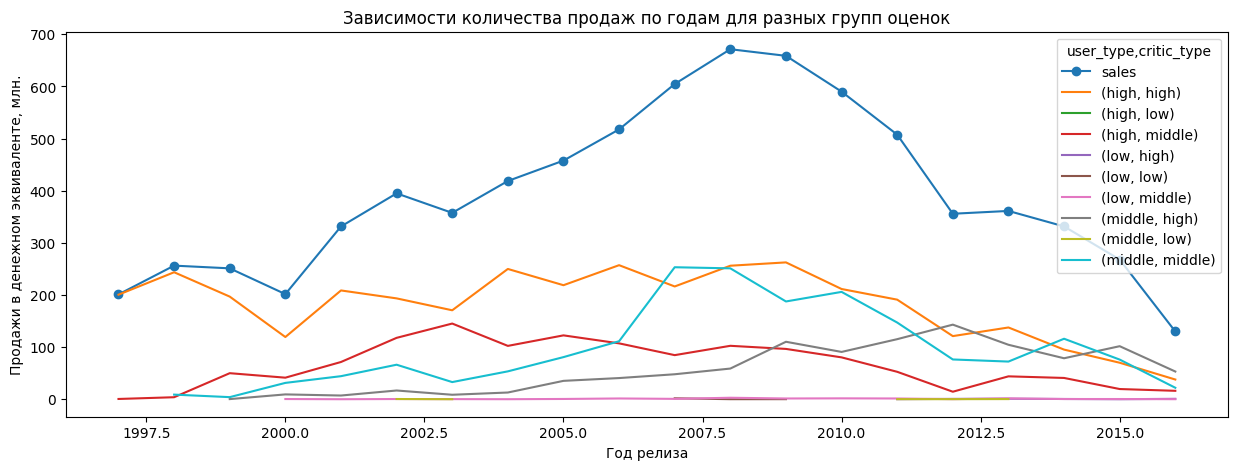

In [69]:
data = data[data['year_of_release'] > 1996]
sales_by_score = data.pivot_table(index = 'year_of_release', columns = ['user_type', 'critic_type'], values = 'all_sales', aggfunc = 'sum')

#Зависимость количества продаж по годам для разных групп оценок
axes = data.groupby(by = ['year_of_release']).agg(sales = ('all_sales', 'sum'))\
.plot(style = '-o', figsize = (15,5), grid = True);

sales_by_score.plot( ax = axes, \
                    xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
                    title = "Зависимости количества продаж по годам для разных групп оценок");

По графикам видно, что наиболее продаваемыми играми являются игры со следующими комбинациями рейтингов (оценка пользователя, оценка критика):
1. высокая - высокая (падает с 2009 года)
2. средняя - средняя (падает с 2007 года)
3. высокая - средняя (падает с 2004 года)
4. средняя - высокая (падает с 2012 года)

Дополнительно имеется возможность утверждать, что:
1. Вклад в продажи игр с низкими оценками (ниже 2.5 и 25) минимален и незначителен
2. До 2000 года наибольшая доля продаж приходилась на игры с высокими оценками. То есть любая продаваемая игра с большой вероятностью получала высокие оценки. Этот период можно считать становлением рынка видеоигр.
3. С 2007 года доля продаж игр со средними продажами сравнялась с долей игр с высокими продажами и количество продаж обеих категорий начало снижаться синхронно
4. С 1995 до 2003 росли продажи игр с высокими оценками пользователей и средними оценками критиков (аудитория была неискушонной и склонной к завышению оценок). Затем рынок стал перенасышен играми, пользователи привыкли к ним в 2008 году ситуация диаметрально поменялась, у пользователей появилась тенденция к занижению оценок относительно оценок критиков.
5. 2008 год - начало "конца" игровой индустрии, связан со снижением продаж игр с высокими оценками пользователей с остаточным ростом продаж игр с высокими оценками критиков.

С учетом изложенного можно предварительно предположить, что актуальным для исследования можно считать период с 2000 до 2016 года.

#### Изучение группировки по плаформам (выбор наиболее популярных платформ, углубленный анализ срезов по годам, определение сроков "жизненного цикла" платформ)

##### Выбор наиболее популярных платформ

Определим, какие платформы были самыми продаваемыми в целом за весь период

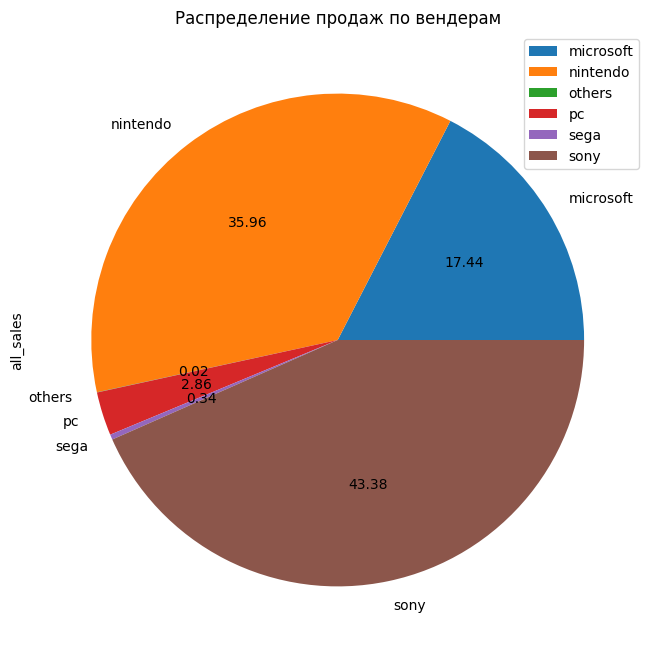

In [70]:
#Круговая диаграмма для распределения по вендерам
ax = data\
.pivot_table(index = 'vender', values = 'all_sales', aggfunc = 'sum')\
.plot(kind='pie', y = 'all_sales', title = "Распределение продаж по вендерам",
      labels = ["microsoft", "nintendo", "others", "pc", "sega", "sony"],  autopct="%.2f", figsize = (8, 8))

Расчитаем долю продаж каждой платформы по годам чтобы понять действительно ли состав ТОП-5 платформ сохраняется от года в год и совпадает с составом, определенным за весь период. 

##### Углубленный анализ срезов по годам относительно вендеров

In [71]:
#Типы вендеров (производителей)
list_by_vender = ['nintendo', 'microsoft','sony', 'sega','others']

# Подсчёт суммарного количества продаж по годам
sales_in_year = data.groupby(by = [ 'year_of_release']).agg(sales_in_year = ('all_sales', 'sum'))

#Подсчет количества продаж по вендерам
sales_by_vender = data.pivot_table(index = 'year_of_release', columns = ['vender'], values = 'all_sales', aggfunc = 'sum')

#Объединяем фреймы
sales_by_vender = pd.concat([sales_by_vender, sales_in_year], axis=1)

#Итерируем по вендерам. Для каждого вендера считаем долю продаж по каждому году
for vender in list_by_vender:
    sales_by_vender[str(vender)+'_ratio'] = sales_by_vender[vender]/sales_by_vender.sales_in_year

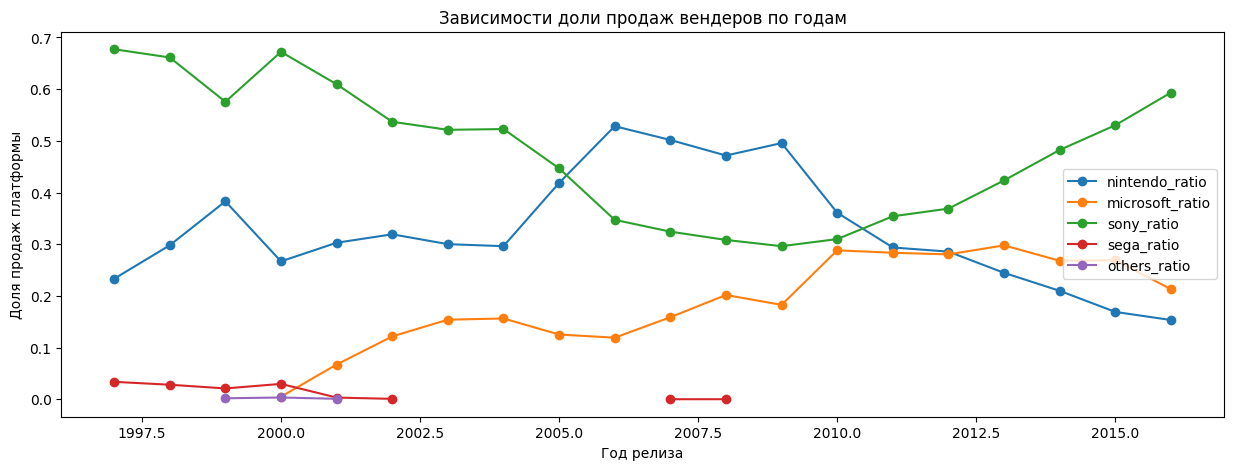

In [72]:
#Графики зависимости доли продаж по вендерам по годам
ax = sales_by_vender.plot(y = 'nintendo_ratio', figsize = (15, 10), style = '-o')
for vender in list_by_vender:
    if vender != 'nintendo':
        sales_by_vender.plot(y = str(vender)+'_ratio', ax = ax, figsize = (15, 5), style = '-o',\
                            xlabel = "Год релиза", ylabel = "Доля продаж платформы",\
                            title = "Зависимости доли продаж вендеров по годам")

Исходя из данных, представленных на графиках можно сделать следующие выводы:

1. Доля продаж sega и группы остальных вендеров ничтожно мала, в некоторые годы они вообще не продавались, их точно можно не учитвать при построении прогнозов
2. C 2000 до 2013 года устройства компании microsoft занимали третье место и показывали стабильный рост.
3. Две лидирующие позиции по долям продаж занимают устройства компании nintendo и sony:
    - с 1995 по 2005 больше продавались устройсва от sony
    - с 2005 по 2011 больше продавались устройсва от nintendo 
    - с 2011 по 2016 опять sony
4. Переломные годы смены лидеров (2005, 2011) наиболее вероятно связаны с выходом новых приставок у конкурирующих вендеров.

Посмотрим как и когда выходили приставки у каждого из вендеров.

##### Определение сроков "жизненного цикла" платформ. Изучение временных характеристик "продаваемости"

###### Функцию для исследования долей продаж по платформам

###### Исследование количества продаж всех платформ от лидера рынка sony

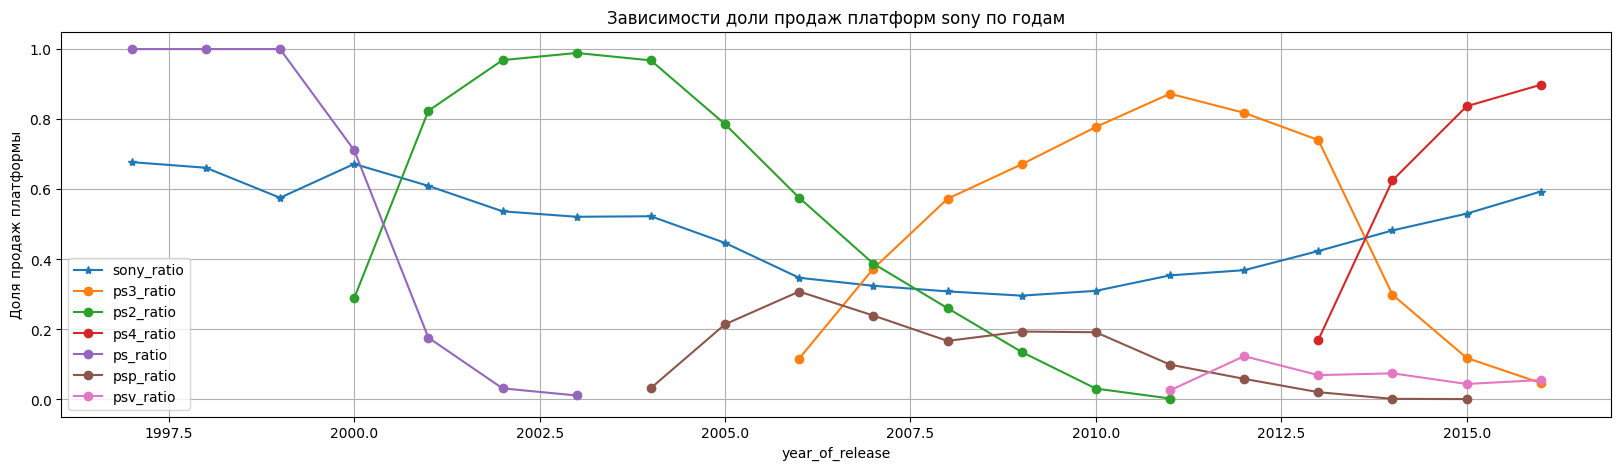

In [73]:
ax = sales_by_vender.plot(y = 'sony_ratio', figsize = (15, 5), style = '-*',\
                          xlabel = "Год релиза", ylabel = "Доля продаж платформы",\
                          title = "Зависимости доли продаж платформ sony по годам")
check_platform_ratio(data, ax, "sony");

По графикам видно, что:
1. sony за рассматриваемый период выпустила 4 удачные платформы и 2 менее удачные. 
2. новые платформы появляются каждые 6-7 лет.
3. для каждой платформы в начале ее жизненного цикла наблюдается рост доли продаж (в среднем в течении 3-5 лет и падение в течении 5-6 лет), средняя продолжительность жизненного цикла составляет 11 лет.
4. провал продаж 2007 года связан с тем, что интерес к старой платформе уже снизился (ps2), а к новой недостаточно вырос (ps3), при этом промежуточная платформа (psp) оказалась неуспешной 
5. переломные годы, определенные в п. 3.6.2.2 корелируют с представленными графиками:
 - в 2005 sony уступила nintendo  - этот год пришелся на снижение продаж ps2 (снижение интереса к старой платфоорме), в то время как новая еще не появилась
 - 2011 - пик успешных продад ps3

###### Исследование количества продаж всех платформ от второго лидера рынка nintendo

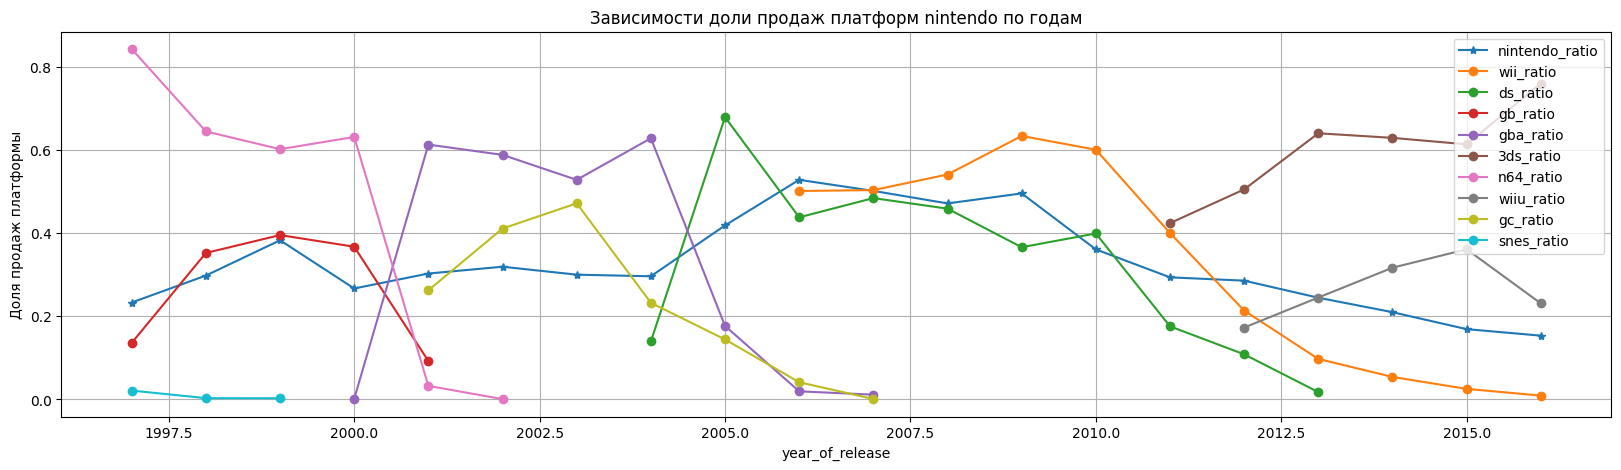

In [74]:
ax = sales_by_vender.plot(y = 'nintendo_ratio', figsize = (15, 5), style = '-*',\
                          xlabel = "Год релиза", ylabel = "Доля продаж платформы",\
                          title = "Зависимости доли продаж платформ nintendo по годам")
check_platform_ratio(data, ax, "nintendo");

### По графикам видно, что:
1. nintendo за рассматриваемый период выпустила 5 удачных платформ, 3 чуть менее удачные и 1 неудачную. 
2. новые платформы появляются каждые 3-4 года.
3. для каждой платформы в начале ее жизненного цикла наблюдается резкий рост доли продаж (в среднем в течении 2-3 лет, плато в течении 2-4 лет и резкое падение в течении 3-4 лет), средняя продолжительность жизненного цикла составляет 8 лет.
4. подъем продаж 2004 - 2010 годов связан с совокупной успешностью двух платформ (ds и wii) 
5. переломные годы, определенные в п. 3.6.2.2 корелируют с представленными графиками:
 - в 2005 sony уступила nintendo  - этот год пришолся на резкий рост продаж игр для ds 
 - в 2011 - синхронное снижение продаж по нескольким платформам
6. nintendo явно берет количеством, она намного чаще, чем sony выпускает новые приставки, подогревая пользовательский интерес, но такая тактика разумна только в условиях высокой покупательной способности. отчасти поэтому с 2010 года nintendo уступает позиции sony

###### Исследование количества продаж всех платформ от microsoft

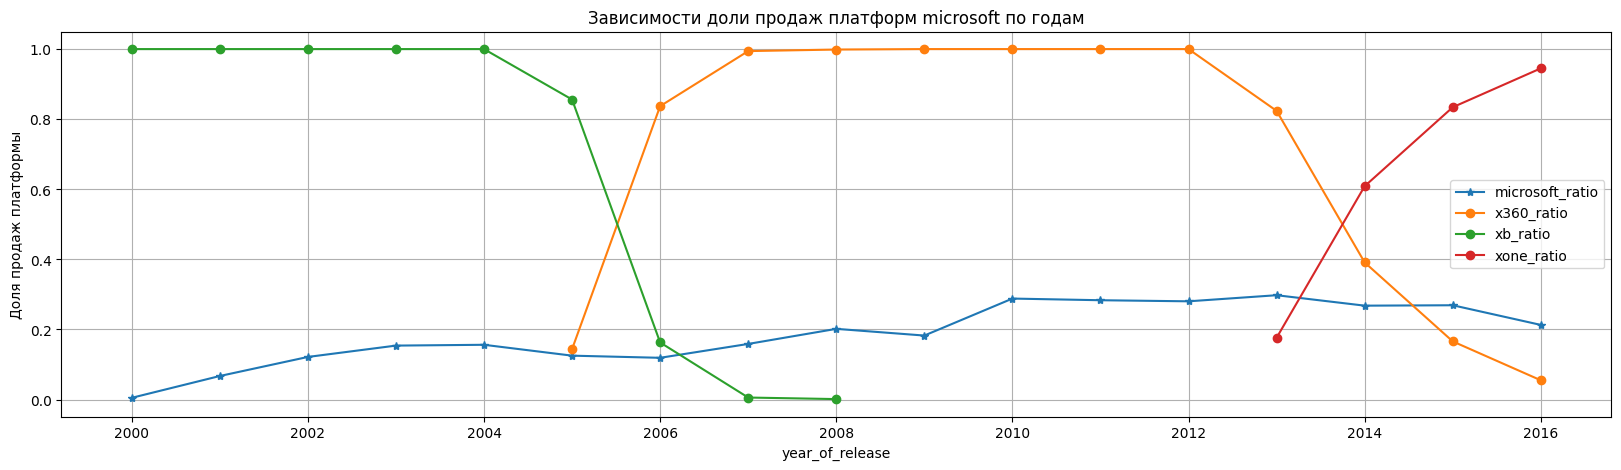

In [75]:
ax = sales_by_vender.plot(y = 'microsoft_ratio', figsize = (15, 5), style = '-*',\
                         xlabel = "Год релиза", ylabel = "Доля продаж платформы",\
                         title = "Зависимости доли продаж платформ microsoft по годам")
check_platform_ratio(data, ax, "microsoft");

По графикам видно, что:
1. microsoft за рассматриваемый период выпустила 3 платформы. 
2. новые платформы появляются каждые 10 лет.
3. для каждой платформы в начале ее жизненного цикла наблюдается рост доли продаж (в среднем в течении 3-4 лет, плато в течении 6 лет и падение в течении 3-4 лет), средняя продолжительность жизненного цикла составляет 12 лет.
4. microsoft очень редко выпускает новые платформы, что в целом упрощает задачу предсказаний по этому вендеру (если новая платформа только выпустилась, то новая выпуститься наиболее вероятно не скоро, а продажи по старой платформе будут стабильны в течении 7 лет)

###### Исследование количества продаж по всем платформам. Выбор нескольких потенциально прибыльных платформ

Index(['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps', 'ps4', 'gba', 'psp', '3ds'], dtype='object', name='platform')

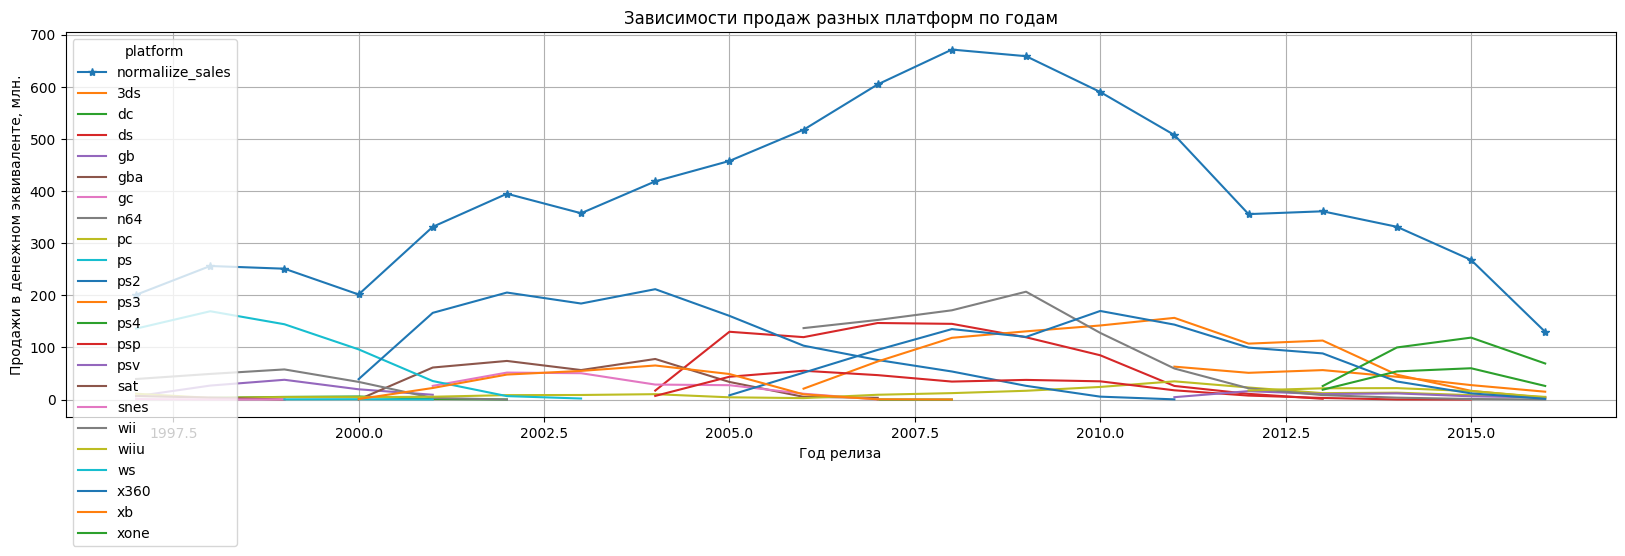

In [76]:
#Десять самых продаваемых платформ
top_platforms = data\
.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum')\
.sort_values(by = 'all_sales', ascending = False).all_sales.head(10).index
display(top_platforms)

#Количество продаж по платформам
sales_by_platform = data\
.pivot_table(index = 'year_of_release', columns = ['platform'], values = 'all_sales', aggfunc = 'sum')

#Распределение количества продаж по годам
ax = data.groupby(by = ['year_of_release']).agg(normaliize_sales = ('all_sales', 'sum'))\
.plot(style = '-*', figsize = (20,5), grid = True);

sales_by_platform.plot(ax = ax, grid = True,\
                       xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
                       title = "Зависимости продаж разных платформ по годам");

Выводы по результатам визуализации:

1. По обобщенному графику для всех платформ сложно делать какие-либо выводы по жизненным циклам платформ и актальным периодам, на основании которых можно строить предсказания о будущих продажах. Это вызвано тем, что у каждого вендера и каждой платформы имеются спецефические особенности, усреднение которых непременно приведет к снижению качества предсказаний. С учетом изложенного,  представляется разумным, что прогнозы по продажам стоит строить сегментированно по вендерам.

2. Вместе с тем на графике четко видно, что большое разнообразие платформ возникло после 2004 года. До 2004 года на рынке присутствовали три успешные платформы. Все эти три платформы являются явными лидерами по продажам (ps(6 место), gba(8 место), ps2(1 место) если проводить оценку по всему временному периоду). Очевидно, что продажи но указанным платформам были суперуспешны в основном из-за отсутсвия достаточного количества конкурентов. Вместе с теем если прогнозы будут строиться для периода, когда конкуренция будет сильной (а 2017 год можно отнести к такому периоду), то в качестве признаков стоит анализировать платформамы, которые продавались именно в конкурентный период. 

3. Также стоит отметить, что игры для портативных приставок очень хорошо продавались в начале конкурентного периода (до 2010 года), после 2010 года появилась несколько платформ, продажи для которых были намного меньше, чем у ранее выходивших портативных платформ и меньше, чем у стационарных платформ из топа продаж. Можно предположить, что к 2010 году на рынке начали появляться смартфоны, которые вытеснили мобильные платформы. Поэтому на период с 2017 года вкладываться в приобритение и продажу игр для мобильных платформ скорее всего будет нецелесообразно.

4. Чтобы определить платформы, которые будут актуальны в 2017 году стоит учитывать, что в предлагаемый список продаж необходимо включать платформы, которые либо растут в продаже либо находятся на пике продаж в 2013 - 2016 году, чтобы к 2017 году они не успели завершить свой жизненный цикл и магазин не соориентировался на продаже игр, пользовательский интерес к которым уже значительно упал. 

В связи с изложенным, актуальным периодом для исследования стоит принять отрезок с 2012 года и выделить на нем успешные платформы, у которых на отрезке с 2012 по 2015 наблюдается рост продаж.


Для того, чтобы выделить платформы, которые вероятно будут хорошо продаваться в 2017 году, посмотрим на графики продаж, отбросив неактуальный хвост и 3 суперпопулярные платформы (чтобы масштаб других платформ был лучше виден)

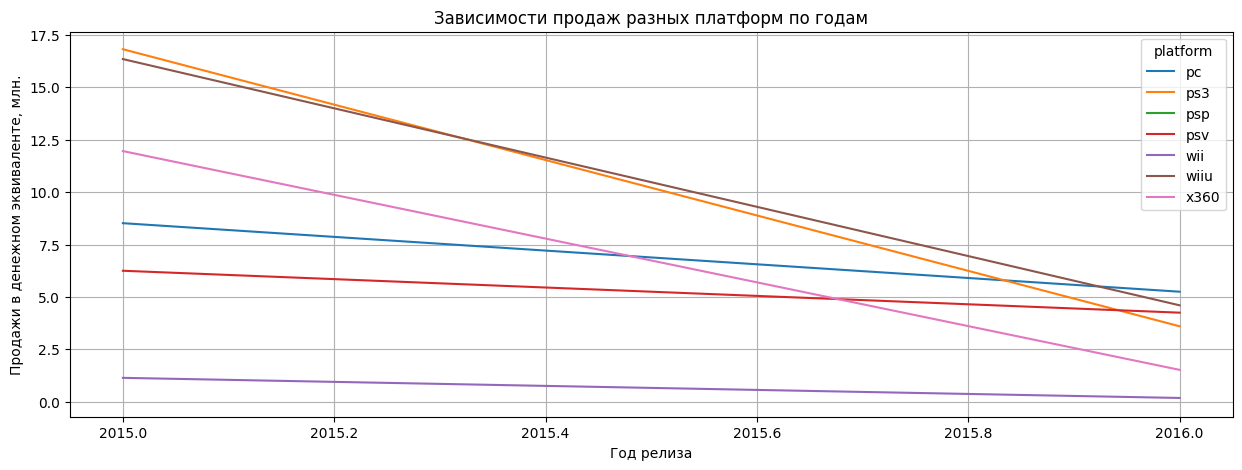

In [77]:
data[(data['year_of_release'] > 2014)].query('platform not in ("xone", "ps4", "3ds")')\
.pivot_table(index = 'year_of_release', columns = ['platform'], values = 'all_sales', aggfunc = 'sum')\
.plot(grid = True, xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
      title = "Зависимости продаж разных платформ по годам", figsize = (15,5));

На графике видно, что все графики имеют вид y = -x*a + b. Найдем предположительное значение продаж, при условии, что с 2015 по 2017 коэффициент a у графика (наклон графика) будет постоянным. Если применим пропорции получим,что y(2017г.) = 3y(2015) - 2y(2014)

In [78]:
#Десять самых продаваемых платформ
top_platforms = data[data['year_of_release'] > 2014]\
.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum')\
.sort_values(by = 'all_sales', ascending = False).all_sales.head(10).index

#Расчитываем предположительный показатель продаж  
alterations_sales = {}
for platform in top_platforms:
    sales_2014 = data[data['year_of_release'] == 2014].query('platform == @platform').all_sales.sum()
    sales_2015 = data[data['year_of_release'] == 2015].query('platform == @platform').all_sales.sum()
    alterations_sales[platform] = round(3*sales_2015 - 2*sales_2014)

print(f'Предположительный показатель продаж в 2017 году: ', alterations_sales)

Предположительный показатель продаж в 2017 году:  {'ps4': 157, 'xone': 72, '3ds': -4, 'wiiu': 5, 'ps3': -45, 'pc': -1, 'x360': -34, 'psv': -5, 'wii': -4, 'psp': 0}


### На основании проведенных изысканий имеется возможность сделать следующие выводы:
1. Актуальным для исследования в целом признан временной интервал с 2014 года (чтобы рассматривать игры, которые могут хорошо продаваться в 2017 году)
2. Изучать характеристики продаваемости и строить какие-либо прогнозы стоит отдельно для каждого вендера, так как принципы выпуска игр для платформ на рынок и жизненные циклы платформ у вендеров отличаются весьма значительно.
3. В предложенном датасете достаточно данных для постоения прогнозов по 3 вендерам (sony, nintendo, microsoft). По остальным вендерам прогнозы построить не удастся.

Кроме того, можно предварительно предположить, что для того, чтобы захватить период затухания продаж предыдущей платформы и рассвета продаж новой платформы при прогнозах стоит рассматривать платформы, которые либо растут в продаже либо падают достаточно медленно. При этом учитывая известную тенденцию падаения за предыдущие 3 года можно расчитать предположительное значение прадаж в прогнозируемом году. Так, проведенные расчеты показали, что:

1. Перспективными платформами точно являются:
 - 'ps4': 157
 - 'xone': 72
 - 'wiiu': 5

2. Под вопросом плтформы:
 - 'psp': 0
 - 'pc': -1
 - 'wii': -4
 - 3ds': -4
 - 'psv': -5

Исходя из полученных наблюдений о характеристиках цикла сменяемости платформ, вышепредставленных графиков, жизненных циклов, и предположительных продаж на 2017 год выделены следующие актуальные платформы:

1. sony - 'ps4',
2. microsoft - 'xone', 
3. nintendo - 'wiiu', 
4. pc
5. sony - 'psv' (портативная)
6. nintendo - '3ds' (портативная)


### Исследовательский анализ данных. Второй этап. Портрет успешной платформы и жанра

#### Выборка данных актуального периода 

Эксперты считают, про прогноз поведения покупателей целесообразно делать на 2-3 летнем периоде, поэтому обрежем датасет по 2014 году.

In [79]:
#Формирование датасета с актуальным временным периодом
ac_data = data[data['year_of_release'] > 2013]

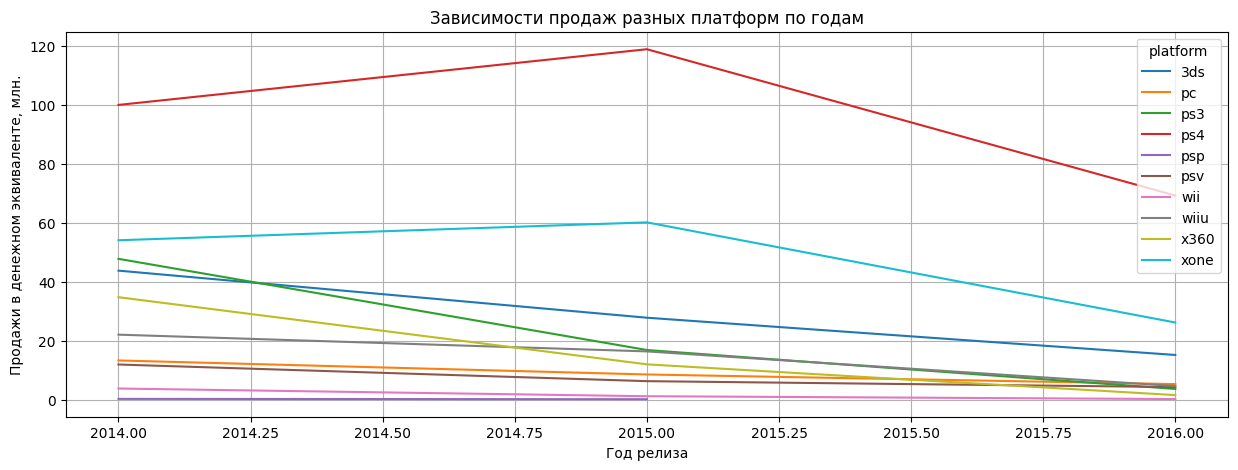

In [80]:
#Количество продаж по платформам
sales_by_platform = ac_data\
.pivot_table(index = 'year_of_release', columns = ['platform'], values = 'all_sales', aggfunc = 'sum')\
.plot(grid = True, xlabel = "Год релиза", ylabel = "Продажи в денежном эквиваленте, млн.",\
      title = "Зависимости продаж разных платформ по годам", figsize = (15,5));

#### Ящик с усами по глобальным продажам

Построим диаграмму размаха на актуальной выборке для всех платформ 

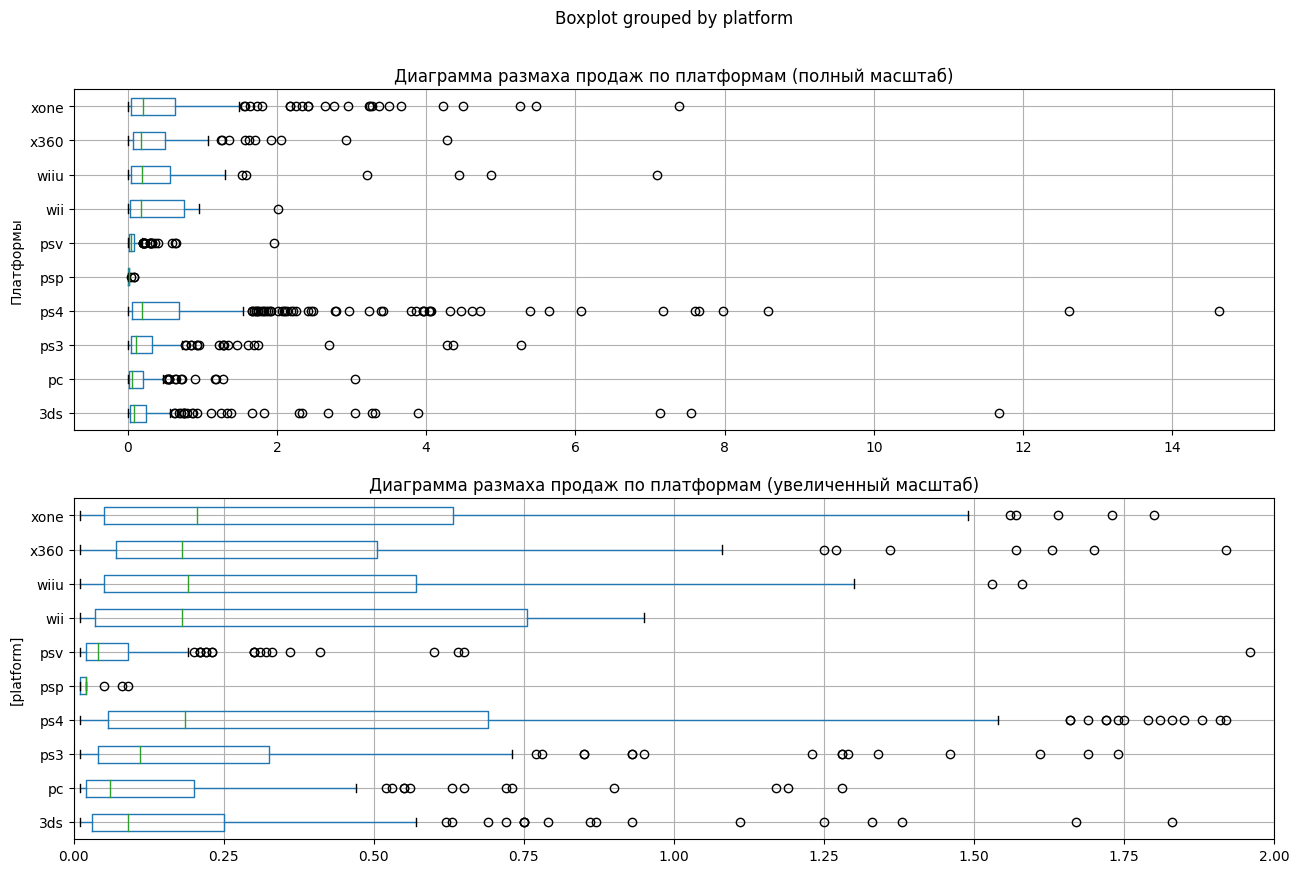

In [81]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharey = False, figsize = (15, 10))

#Диаграмма, оригинальный масштаб
ac_data.query('platform in @top_platforms')[['platform', 'all_sales']]\
.boxplot(by='platform', vert = False, grid = True, ax = axes[0])
axes[0].set_ylabel('Платформы')
axes[0].set(title = 'Диаграмма размаха продаж по платформам (полный масштаб)');

#Диаграмма, увеличенный масштаб
ac_data.query('platform in @top_platforms')[['platform', 'all_sales']]\
.boxplot(by='platform', vert = False, grid = True, ax = axes[1])
axes[1].set(xlim=(0, 2), title = 'Диаграмма размаха продаж по платформам (увеличенный масштаб)');

Продажи у рассматривемых платформ распределены по-разному: 
1. У psp, psv, pc и 3ds самая короткая прямая удачных продаж (продажи наиболее плотные) и сосредоточены в диапазоне до 0.5 млн, при этом у 3ds есть некоторое количество весомых выбросов.
2. У ps4 самый большой разброс выручек до 15 млн (у некоторых самых успешных игр), и доминирующий третий квартиль. 
3. У ч360, wiiu и xone величины разброса соизмеримы, но число выбросов больше у xone.
4. Cледующие, не вошедшие в список перспективных по результатам первого этапа исследования, платформы тем не менее выглядят весьма привлекательно:
- x360
- wii
- ps3 
5. psp напротив выглядит очень бесперспективно. Возможно это связано с тем, что мы взяли слишком большой актуальный период. 

Таким образом предварительно можно предположить, что характеристики продаж у игр на платформе psv и pc будут максимально близки к среднестатистическим и зная средние характеристики продаж по ниим можо будет сделать достаточно точные предположения о продажах новых играх. Для ps4 и xone точные предположения будет сделать значительно сложнее.

###### Диаграммы размаха на уменьшенном на год временном интервале

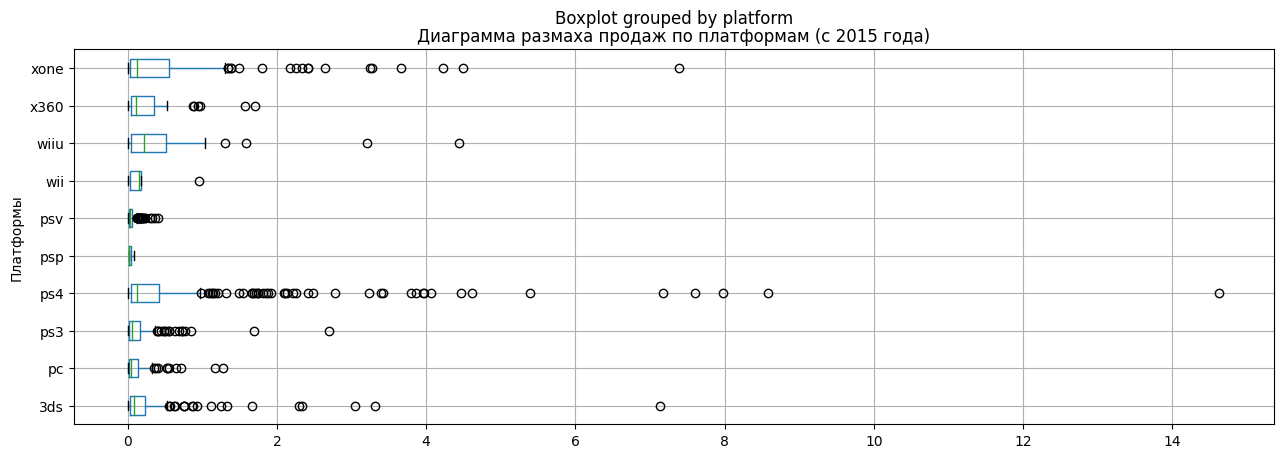

In [82]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
data[data['year_of_release'] > 2014][['platform', 'all_sales']]\
.boxplot(by='platform', vert = False, grid = True, ax = axes)
axes.set_ylabel('Платформы')
axes.set(title = 'Диаграмма размаха продаж по платформам (с 2015 года)');

На ограниченном двумя годами временном промежутке продажи платформ выглядят более сегментированными и поддающимися сравнению. Скорректируем актуальный период и исключим из списка перспективных psv.

In [83]:
top_platforms = [ 'ps4', 'xone', 'wiiu', 'pc', '3ds' ]

#Формирование датасета с актуальным временным периодом
ac_data = data[data['year_of_release'] > 2014].query('platform in @top_platforms')

<div class="alert alert-danger">
<font size="4"><b>❌ Комментарий ревьюера в2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

__Не стоит ограничивать перечень платформ из актуального периода для оценки прибыльности платформ__
        
диаграмму размаха перерисовать на актуальной выборке с полным перечнем платформ
        

#### Группировка по лидирующим платформам

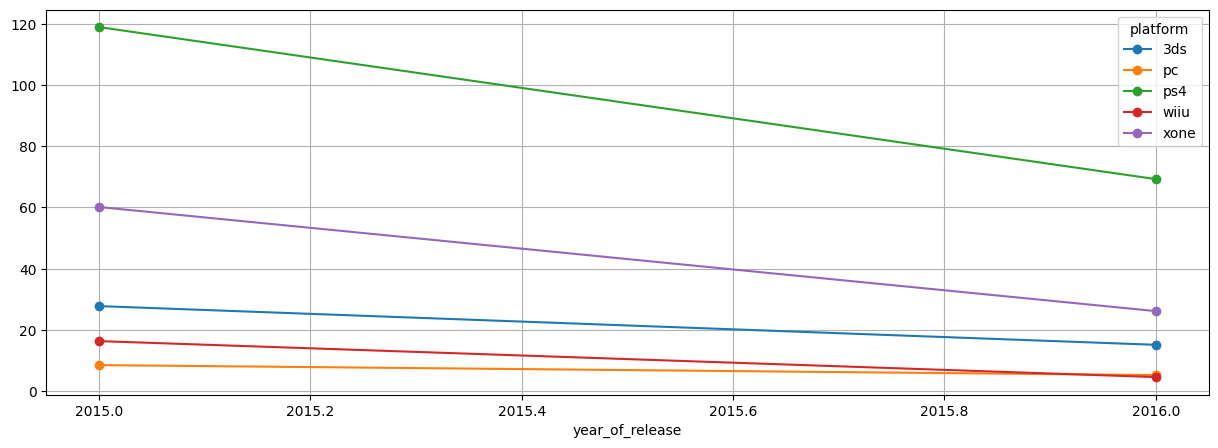

In [84]:
#Количество продаж по платформам из топ-5
ax =  ac_data\
.pivot_table(index = 'year_of_release', columns = ['platform'], values = 'all_sales', aggfunc = 'sum')\
.plot(style = '-o', figsize = (15,5), grid = True)


Среди ТОП-5 самых продаваемых платформ присутствует 1 портативная платформа , 3 консольных и ПК. Целесообразно их рассматривать отдельно друг от друга. 

#### Характеристики продаж успешных платформ

Отдельно стоит сформулировать признаки успешной платформы. Очевидно, что успешность платформы можно оценить по двумя основным характеристикам:
1. общее число продаж (продаваемость)
2. длительность жизненного цикла (длительность заинтересованности в платформе покупателей).

Но так как жизненный цикл платформ не умещается в актуальный период, целесообразно оценивать платформы по средней величине продаж на один год жизненного цикла. Посчитаем эту характеристику для всех рассматриваемых платформ

In [85]:
life_len = [data.query('platform == @platform').year_of_release.max() - \
            data.query('platform == @platform').year_of_release.min()\
            for platform in top_platforms]

sales = [data.query('platform == @platform').all_sales.sum() for platform in top_platforms]

data_life = pd.DataFrame({'platform': top_platforms, 'life_len': life_len, 'sales': sales})
data_life['mean_sales'] = data_life.sales/data_life.life_len
display(data_life)

platform  life_len   sales  mean_sales
0      ps4         3  314.14  104.713333
1     xone         3  159.32   53.106667
2     wiiu         4   82.19   20.547500
3       pc        19  224.99   11.841579
4      3ds         5  257.81   51.562000

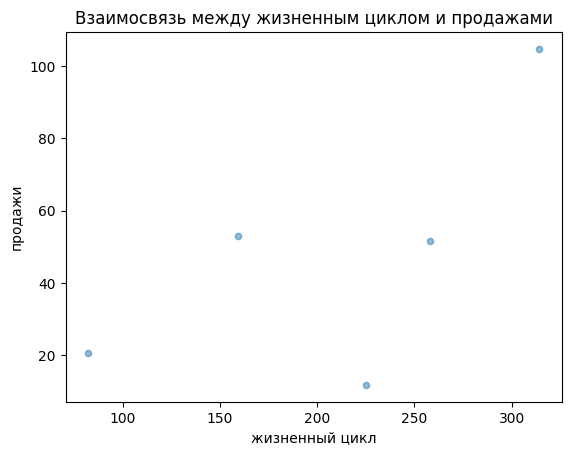

In [86]:
data_life.plot(x='sales', y='mean_sales', kind='scatter', alpha=0.5 , xlabel = "жизненный цикл", \
                          ylabel = "продажи", title = "Взаимосвязь между жизненным циклом и продажами");

In [87]:
#Кореляция между длиной жизненного цикла и продажами у успеных платформ
data_life['sales'].corr(data_life['mean_sales'])

0.67140425921425

Очевидно, что у успешных платформ средняя прибыль за один год жизненного цикла и суммарная прибыль слабо, но нокоррелируют друг с другом. При этом в теории могут быть крайне прибыльные платформы c коротким жизненным циклом и наоборот долго продающиеся по-малу платформы, набирающие суммарную прибыль за счет больших сроков продаж.

Обобщая полученные результаты, можно сделать следующие выводы:
1. абсолютно успешной можно считать платформу, у которой длительность жизненного цикла больше 8 лет, а суммарные продажи по всем играм на один год жизненного цикла больше  20 млн.
2. в рассмотренном периоде три абсолютно успешные платформы по продажам ps4, xone, 3ds и две менее успешные wiiu и pc. 
4. при этом 3ds - поративная и ставки на нее делать крайне опасно (она мобильная, а популярность мобильных устройств снижается с 2010 года и судя по ее жизненному циклу с 2016 года продажи 3ds будут сильно снижаться)

#### Изучение влияния на продажи внутри одной платформы отзывов пользователей и критиков, рейтингов. 

Изучать влияния на продажи отзывов пользователей и критиков, рейтингов будем отдельно для четырех лидирующих платформ (ps4, xone, wiiu, psv). Для этого построим диаграммы рассеяния для пар (оценка(рейтинг)/суммарные продажи для каждой игры отдельно по каждой платформе)

##### Оценка корреляции между оценками и продажами

###### Взаимосвязь оценки пользователя и продаж

Коэффициент кореляции между выручкой и оценками пользователя для ps4: -0.1020200950780023
Коэффициент кореляции между выручкой и оценками пользователя для xone: -0.05258823090555983
Коэффициент кореляции между выручкой и оценками пользователя для wiiu: 0.3230567379682573
Коэффициент кореляции между выручкой и оценками пользователя для pc: 0.06674704506261714
Коэффициент кореляции между выручкой и оценками пользователя для 3ds: 0.07852396510526996


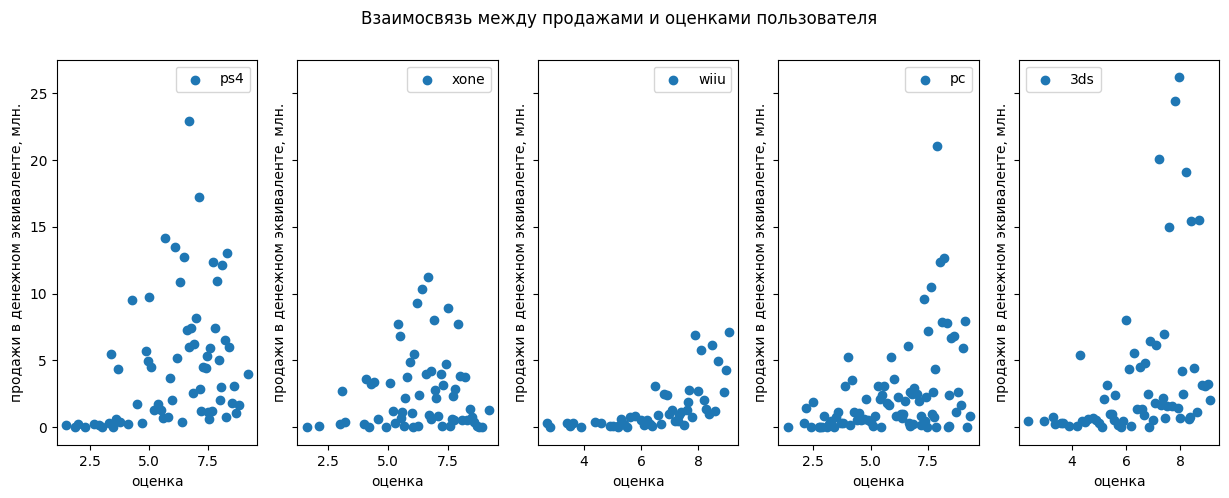

In [88]:
scatter_for_rating(top_platforms, "user_score", "пользователя")

###### Взаимосвязь оценки критика и продаж

Коэффициент кореляции между выручкой и оценками критика для ps4: 0.2715318552811013
Коэффициент кореляции между выручкой и оценками критика для xone: 0.3041547882822404
Коэффициент кореляции между выручкой и оценками критика для wiiu: 0.2796350802074429
Коэффициент кореляции между выручкой и оценками критика для pc: 0.3463382773881195
Коэффициент кореляции между выручкой и оценками критика для 3ds: 0.037163946784012414


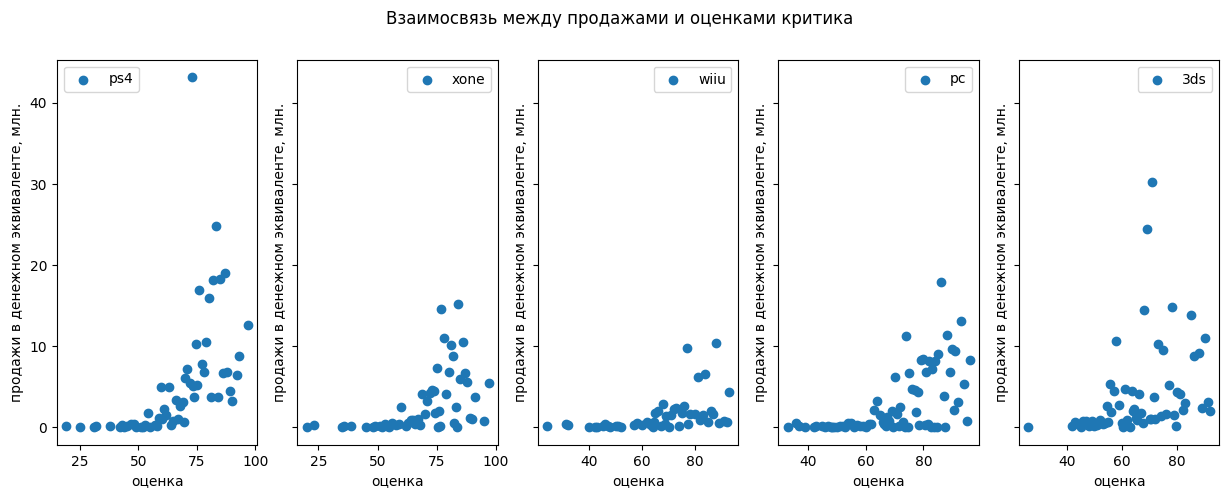

In [89]:
scatter_for_rating(top_platforms, "critic_score", "критика")

#### Выводы относительно влиния отзывов на продажи на разных платформах (оценка их применимости ко всем платформам)

Судя по диаграммам рассеяния и рассчитанным коэффициентам корреляции нельзя говорить о наличии прямой сильной связи между оценками пользователей(критиков) и продажами во всем диапазоне оценок. Для всех платформ можно утверждать, что игры с низкими оценками (меньше 4 у критиков и меньше 2 у пользователей практически не продаются. Начиная с оценок 40 (у критиков) и 2 (у пользователей) продажи растут с увеличением оценок, но стабильной эту связь назвать нельзя.

##### Оценка корреляции между рейтингами и продажами

###### Взаимосвязь рейтинга и продаж для wii

Коэффициент кореляции между выручкой и оценками рейтинга для ps4: 0.13338916566941586
Коэффициент кореляции между выручкой и оценками рейтинга для xone: 0.10613275730267423
Коэффициент кореляции между выручкой и оценками рейтинга для wiiu: 0.10633124508059895
Коэффициент кореляции между выручкой и оценками рейтинга для pc: 0.3208490536346247
Коэффициент кореляции между выручкой и оценками рейтинга для 3ds: -0.009667258733209895


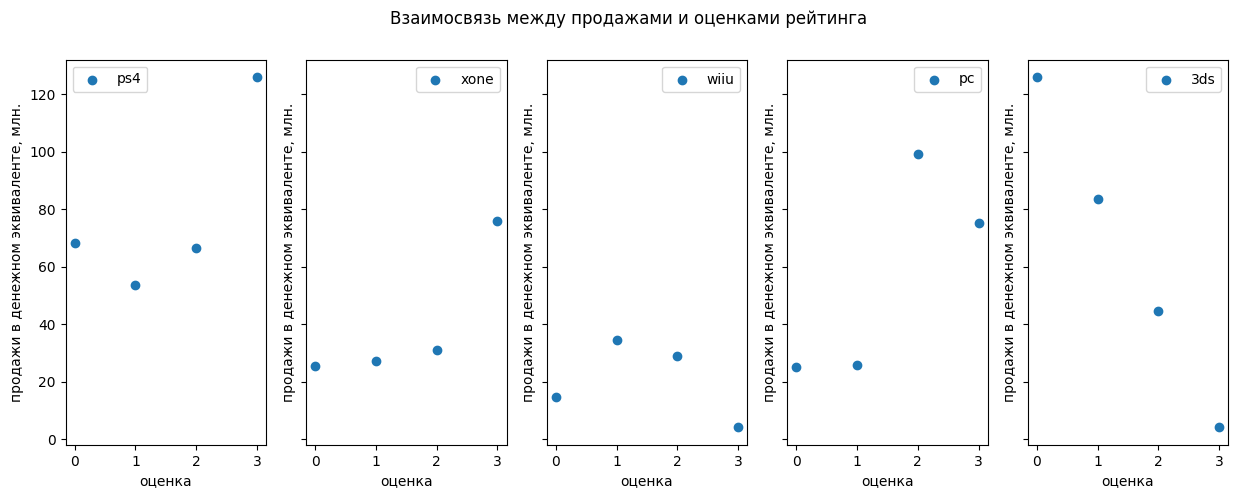

In [90]:
scatter_for_rating(top_platforms, "rating_score", "рейтинга")

Очевидно, что хорошо показавший себя метод иллюстрации завсимости продаж от оценок пользователей неэффективен для рейтингов. По представленным графиком можно говорить лишь о том, что игры разных рейтингов могут быть как хорошо, так и плохо продаваемыми. Посмотрим как распределена частота продажи игр в зависимости от рейтинга

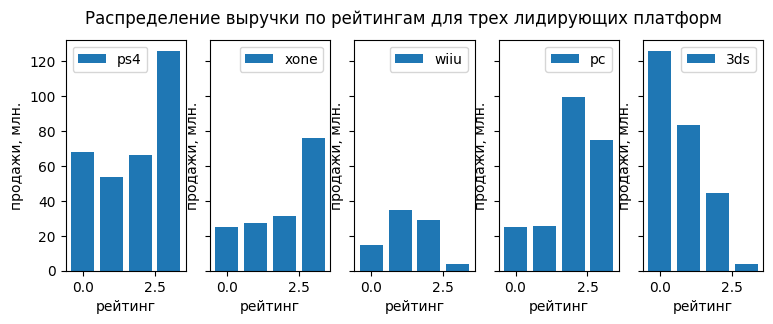

In [91]:
bar_for_rating(top_platforms)

По гистограммам видно, что форма распределение продаж по рейтингам у 'xone', 'ps4', 'pc' практически одинаковые, но значительно отличаются от 'wiiu' и '3ds'. Рассмтрим распределение более подробно с помощью круговых диаграмм.

###### Распределение продаж по рейтингам для "ps4"

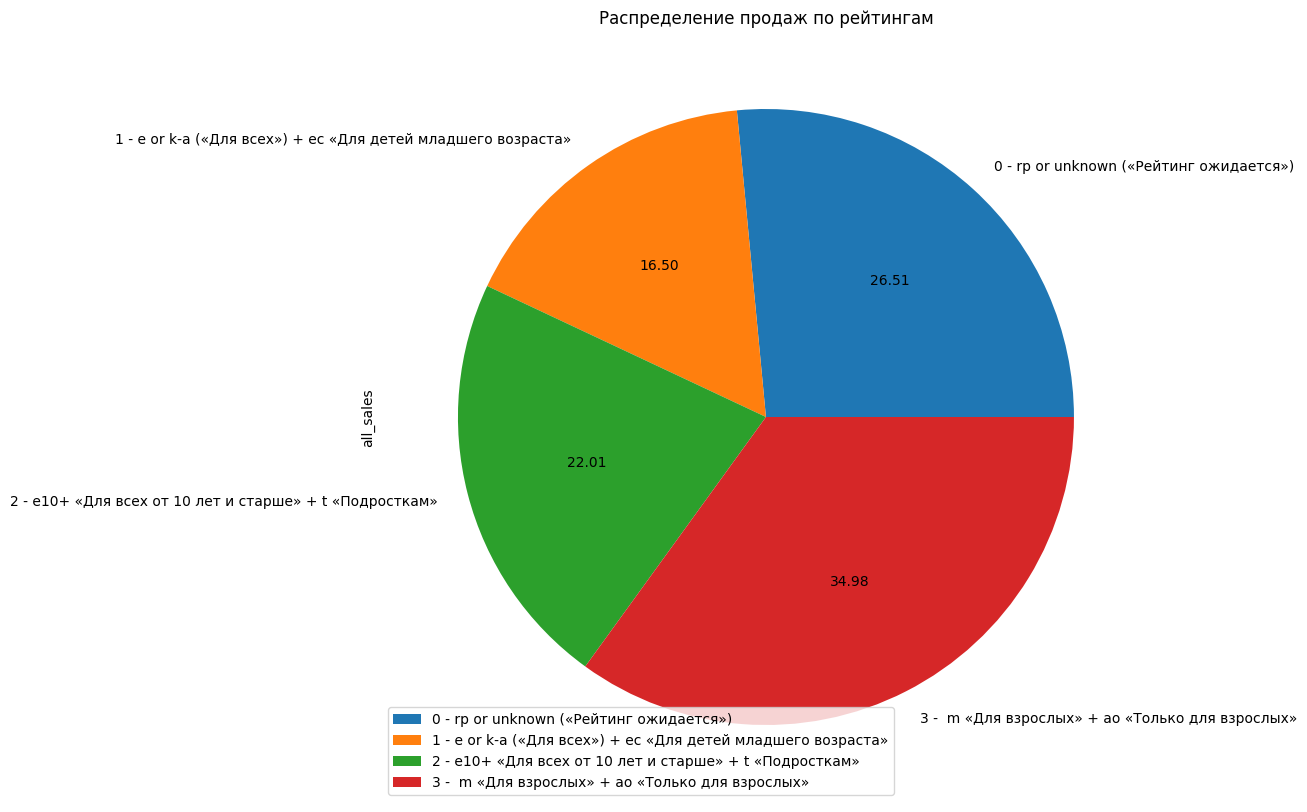

In [92]:
pie_for_rating("ps4")

По круговой диаграмме видно, что игры платформы ps4 в основном ориентиованы на взрослых (34.98%) и подростков (22.01%) и в меньшей степени на детей (16.5%)

###### Распределение продаж по рейтингам для "xone"

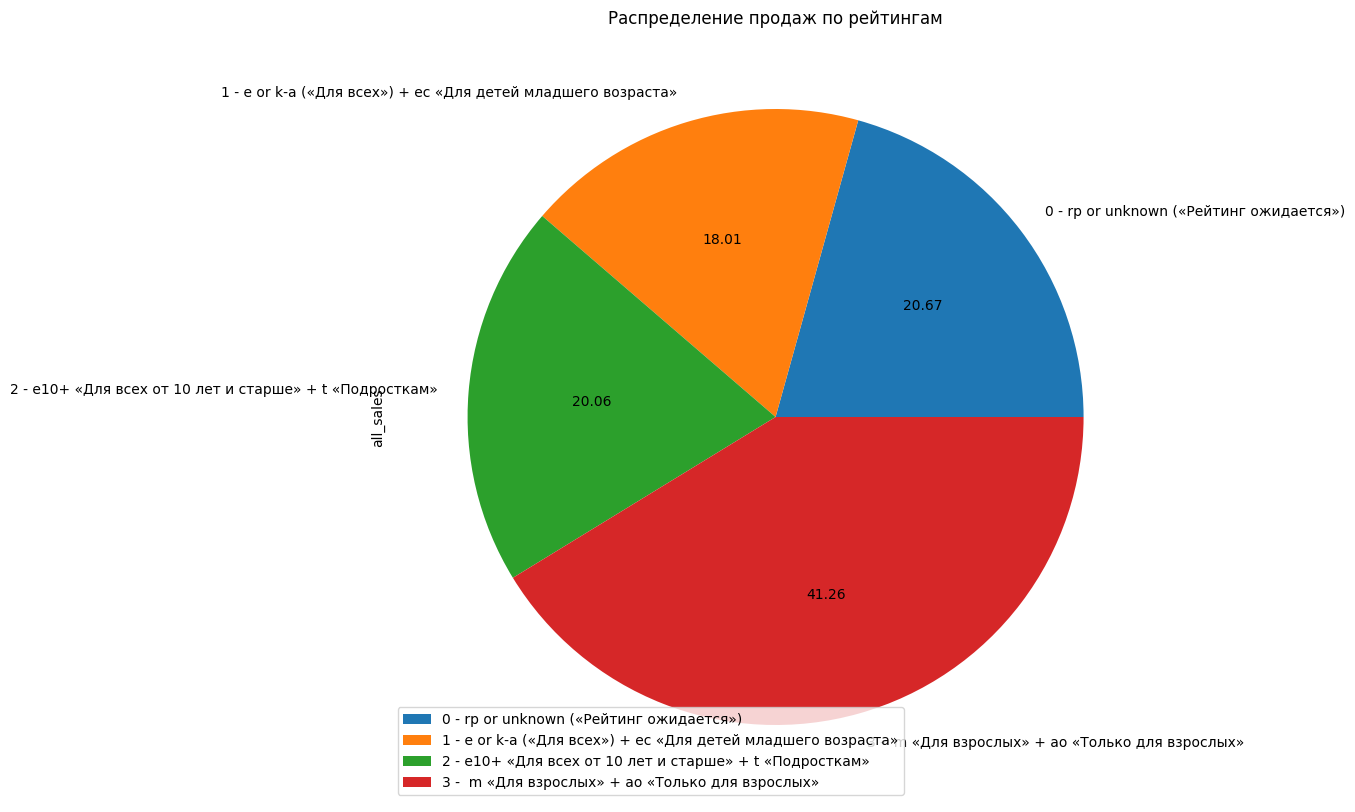

In [93]:
pie_for_rating("xone")

По круговой диаграмме видно, что игры платформы xone также как ps4 в основном ориентиованы на взрослых (41.26%) и подростков (20.06%) и в меньшей степени на детей (18.01%)

###### Распределение продаж по рейтингам для "wiiu"

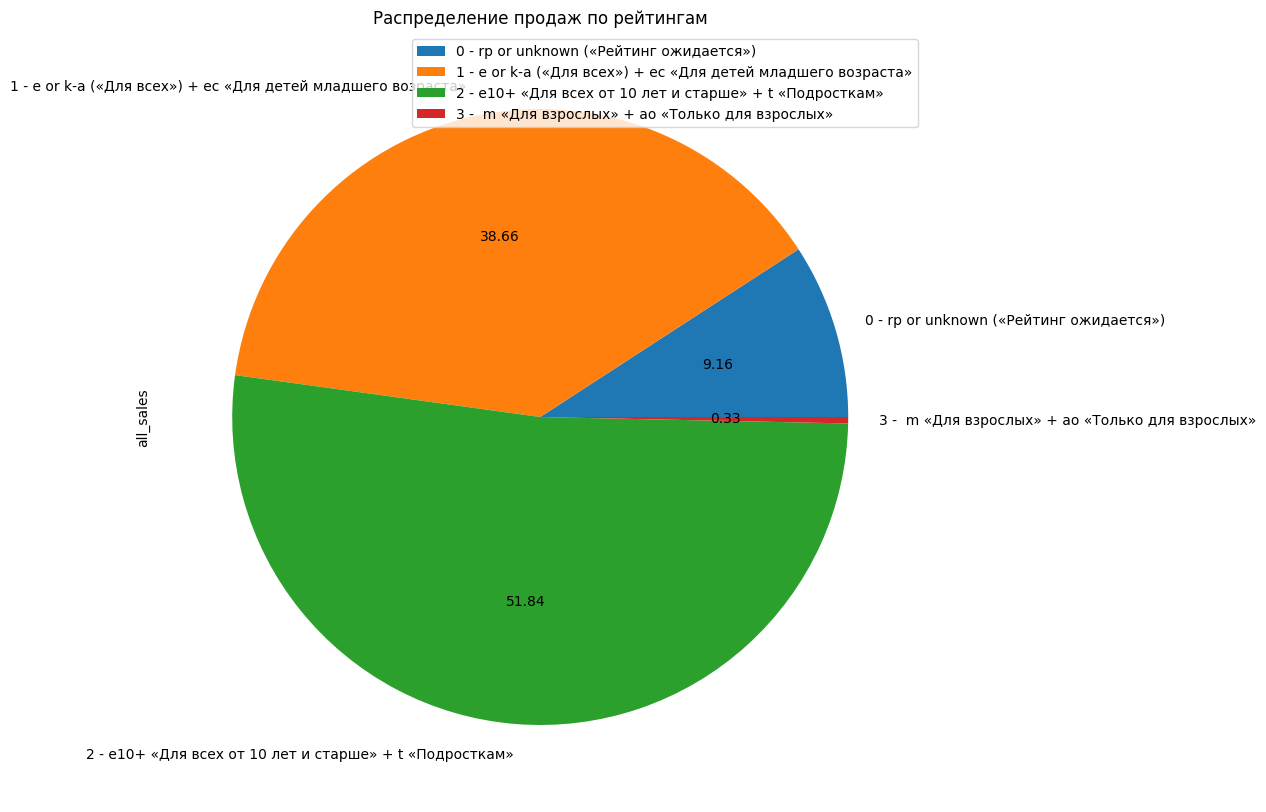

In [94]:
pie_for_rating("wiiu")

По круговой диаграмме видно, что платформа wii ориентируется в основном на семейные игры, в которые могут играть все, и дети, и взрослые (38.36%) и игры для подростков (51.84%). При этом доля игр для взрослых составляет менее 1 процента.

#### Распределение продаж по рейтингам для "3ds"

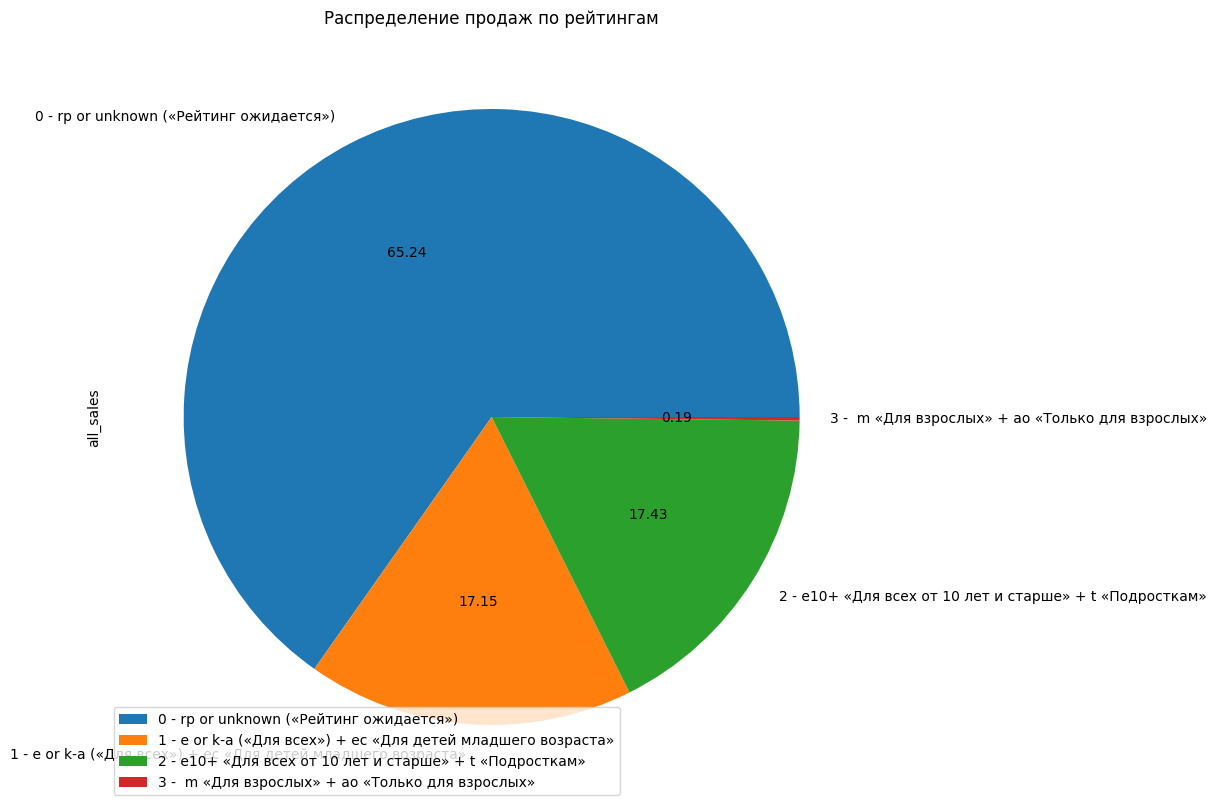

In [95]:
pie_for_rating("3ds")

По круговой диаграмме видно, что 65.24% игр для 3ds не охвачены рейтингами (видимо это какие-то региональные игры, не продающиеся в америке). Остальные игры в основном ориентированы на все возраста (17.41%). На втором месте игры для подростков 17.15 %б. Доли взрослых игр менее 1%.

#### Распределение продаж по рейтингам для "pc"

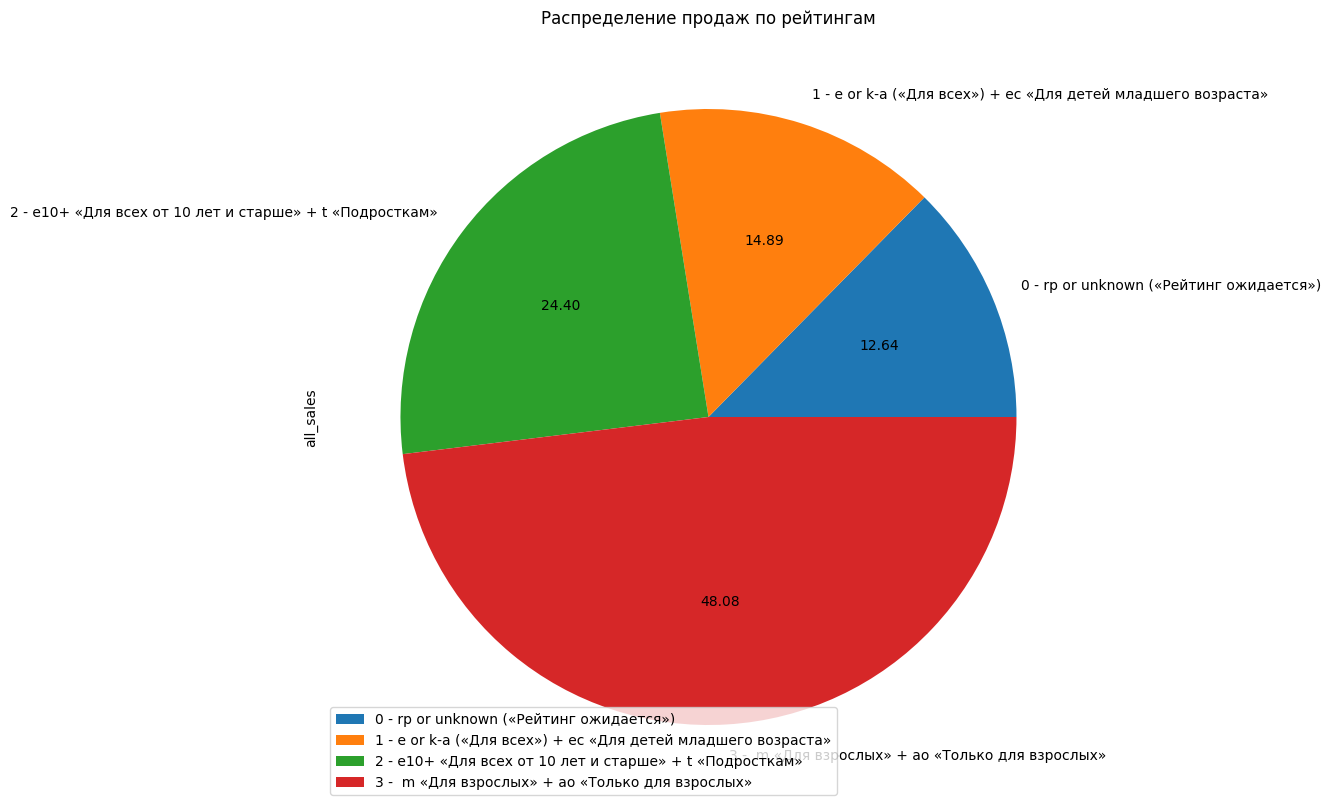

In [96]:
pie_for_rating("pc")

По круговой диаграмме видно, что 40.08% игр на pc игры ориентированы на взрослых, на детей и подростков приходятся примерно ровные доли (24 и 14 %).

#### Выводы относительно влиния рейтингов на продажи на разных платформах (оценка их применимости ко всем платформам)

Судя по диаграммам рассеяния и круговым диаграммам можно ссформулировать следующие закономерности:
- на платформах "ps4", "xone", "pc" наиболее успешно продавались игры для взрослых
- на платформе "wiiu" наиболее успешно продавались игры для всех возрастов и детей
- к 3ds дифференциация по рейтингам неприменима, так как для более чем 60% ее игр рейтинг неизвестен. 

Эти особенности следует учитывать, если магазин Заказчика ориентирован на определенную возрастную аудиторию.

#### Изучение общего распределения игр по жанрам, выявление наиболее и наименее прибыльных жанров, оценка их основных особенностей

In [97]:
#Группировка данных о продажах по жанрам
sales_by_genre = ac_data\
.pivot_table(index = 'genre', values = 'all_sales', aggfunc = ['sum', 'count', 'mean'])
sales_by_genre.columns = ['money', 'sales', 'price']

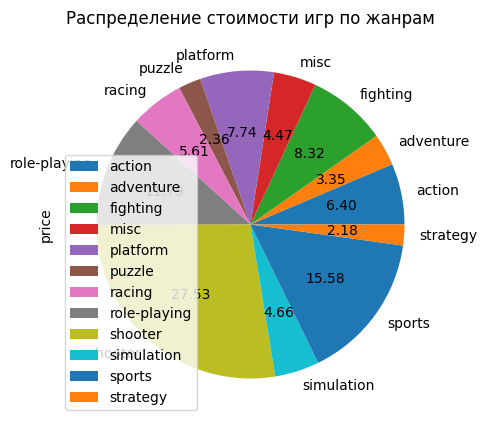

In [98]:
#Круговая диаграмма для распределения стоимости игры по жанрам
sales_by_genre.plot(kind='pie', y = 'price', title = "Распределение стоимости игр по жанрам",
          autopct="%.2f", figsize = (5, 5));

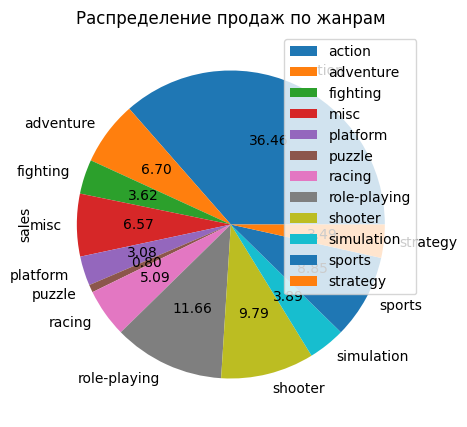

In [99]:
#Круговая диаграмма для распределения числа продаж по жанрам
sales_by_genre.plot(kind='pie', y = 'sales', title = "Распределение продаж по жанрам",
          autopct="%.2f", figsize = (5, 5));


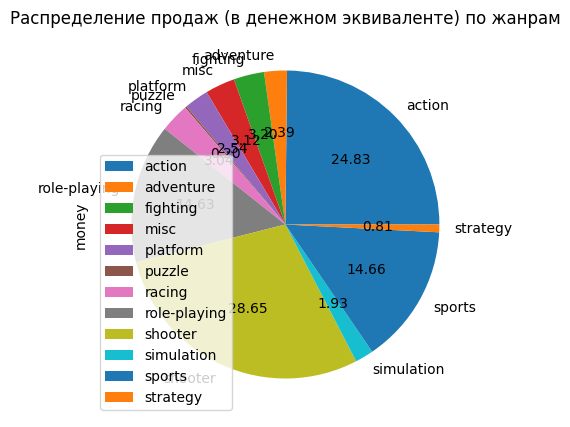

In [100]:
#Круговая диаграмма для распределения продаж, выраженных в деньгах, по жанрам
sales_by_genre.plot(kind='pie', y = 'money', title = "Распределение продаж (в денежном эквиваленте) по жанрам",
          autopct="%.2f", figsize = (5, 5));

По круговым диаграммам в данном случае сложно сделать какие-либо выводы. Построим гистограммы.

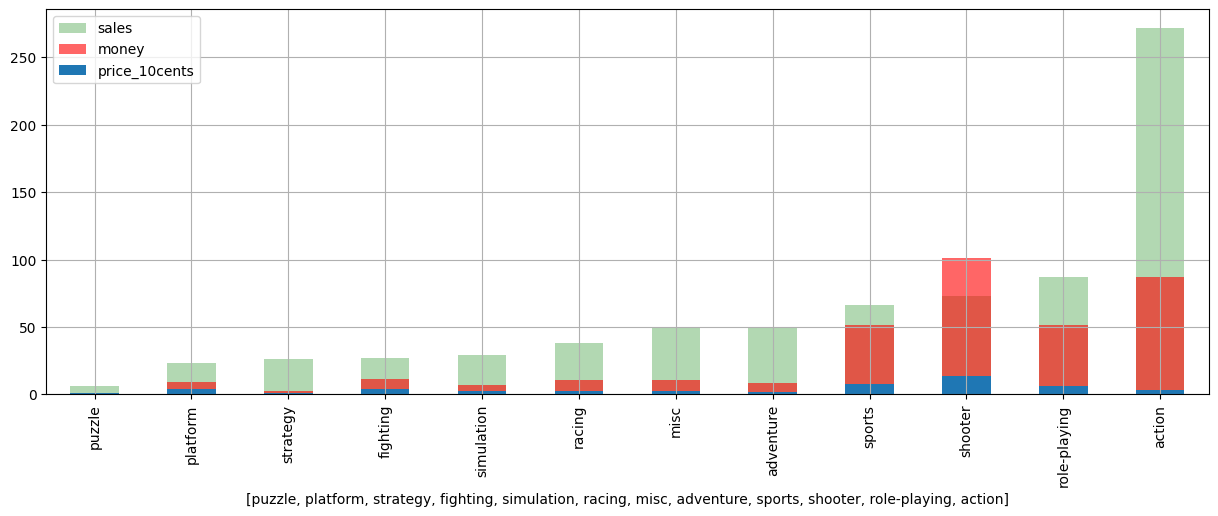

In [101]:
sales_by_genre = sales_by_genre.sort_values(by = 'sales')
ax = sales_by_genre.plot(kind = 'bar', y = 'sales', alpha = 0.3,  figsize = (15, 5), color = 'green', \
                    grid = True, legend = True, style ='s-', xlabel = sales_by_genre.index)

sales_by_genre.plot(kind = 'bar', y = 'money', alpha = 0.6,  figsize = (15, 5), color = 'red', \
                    grid = True, legend = True, style ='s-', xlabel = sales_by_genre.index, ax = ax)

sales_by_genre['price_10cents'] = sales_by_genre.price*10

sales_by_genre.plot(kind = 'bar', y = 'price_10cents', linewidth = 2, alpha = 1,  figsize = (15, 5), \
                    grid = True, legend = True, style ='s-', xlabel = sales_by_genre.index, ax = ax);

По гистограмме видно, что для каждого жанра свое соотношение между общей прибылью, количество продаж и стоимостью одной игры. Например, самым продаваемым с перевесом практически в 2 раза является жанр action, при этом прибыль по нему практически соизмерима с прибылью жанра shooter. Рассмотрим распределение характеристик прибыльности по жанрам более подробно с помощью линейной визуализации.

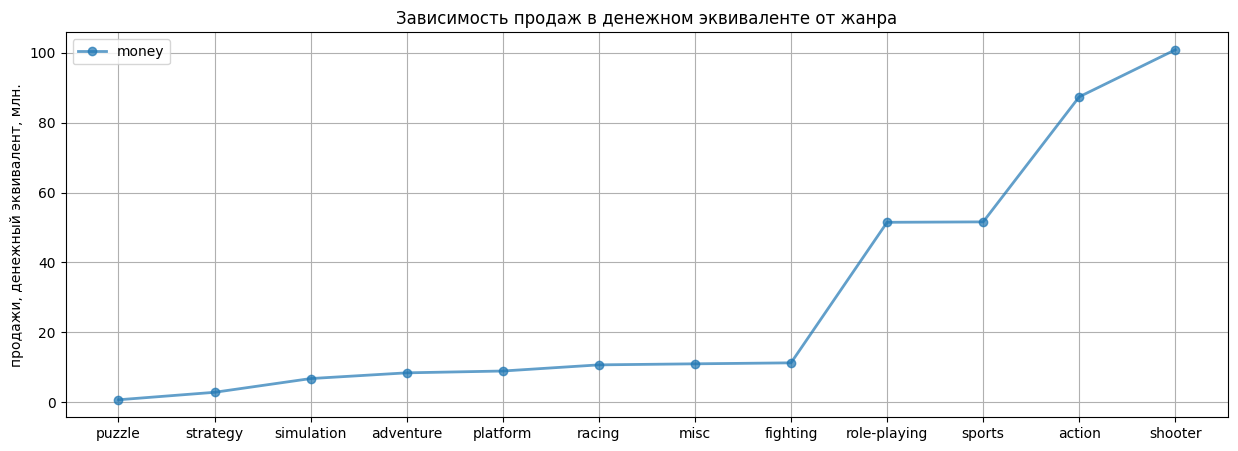

In [102]:
#Зависимсоти продаж, выраженных в деньгах, от жанров
sales_by_genre = sales_by_genre.sort_values(by = 'money')
ax = sales_by_genre\
.plot(y = 'money', linewidth = 2, alpha = 0.7,  figsize = (15, 5), \
      grid = True, legend = True, style ='o-', xlabel = '',\
      ylabel = "продажи, денежный эквивалент, млн.",\
      title = "Зависимость продаж в денежном эквиваленте от жанра");

# подписи
position = np.arange(len(sales_by_genre.index))
#  Устанавливаем позиции тиков:
ax.set_xticks(position)
#  Устанавливаем подписи тиков
ax.set_xticklabels(sales_by_genre.index);


На графике видно, что хуже всего по деньгам продавались 'puzzle', 'strategy', 'simulation', 'adventure', 'platform'. Лучще всего 'fighting', 'role-playing', 'sports', 'action', 'shooter'. Проверим как распределена выручка по жанрам.

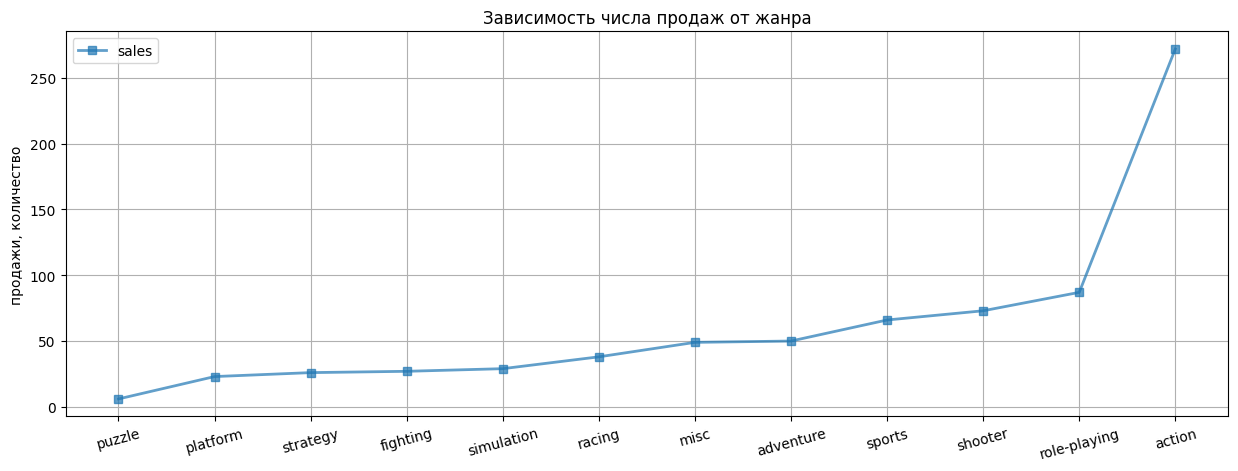

In [103]:
#Зависимсоти числа продаж от жанров

sales_by_genre = sales_by_genre.sort_values(by = 'sales')
ax = sales_by_genre\
.plot(y = 'sales', linewidth = 2, alpha = 0.7,  figsize = (15, 5), \
      grid = True, legend = True, style ='s-', \
      xlabel = '', ylabel = "продажи, количество",\
      title = "Зависимость числа продаж от жанра", rot= 15)


# подписи
position = np.arange(len(sales_by_genre.index))
#  Устанавливаем позиции тиков:
ax.set_xticks(position)
#  Устанавливаем подписи тиков
ax.set_xticklabels(sales_by_genre.index);

На графике видно, что хуже всего количественно продавались 'puzzle', 'platform', 'strategy', 'fighting', 'simulation'. Лучще всего 'adventure', 'sports', 'shooter', 'role-playing', 'action'. Практически полное совпадение с распределением по деньгам, кроме 'adventure', которые неожинанно попали в частопродающийся сегмент. Видимо средняя цена на игры этого жанра значительно ниже других. Посмотрим на распределение цен на игры по жанрам. Для удобства сохраним сортировку по прибыли.

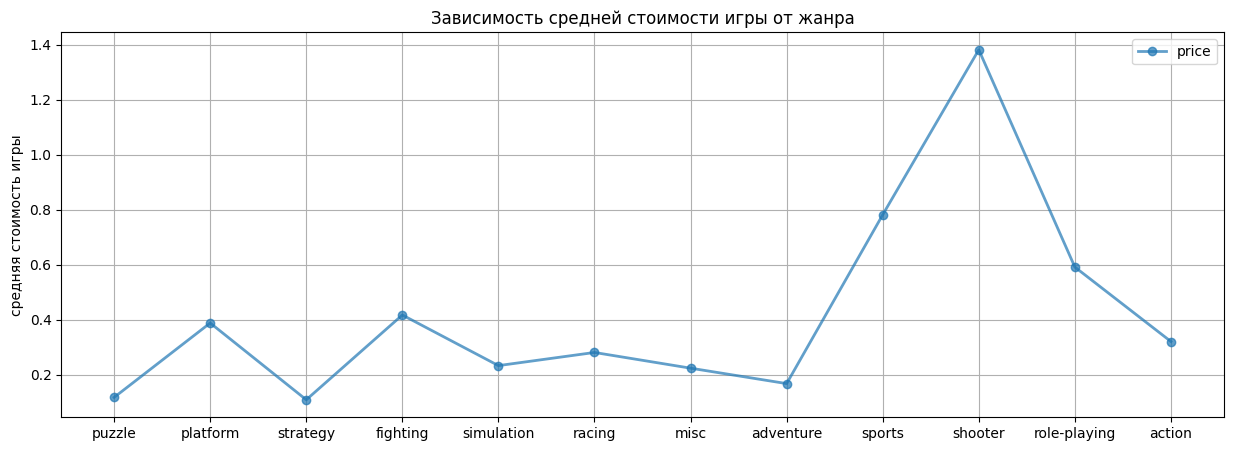

In [104]:
#Зависимсоти средней цены одной игры от жанров
ax = sales_by_genre\
.plot(y = 'price', linewidth = 2, alpha = 0.7,  figsize = (15, 5), \
      grid = True, legend = True, style ='o-', xlabel = '',\
      ylabel = "средняя стоимость игры",\
      title = "Зависимость средней стоимости игры от жанра");
sales_by_genre.index

# подписи
position = np.arange(len(sales_by_genre.index))
#  Устанавливаем позиции тиков:
ax.set_xticks(position)
#  Устанавливаем подписи тиков
ax.set_xticklabels(sales_by_genre.index);

Действительно по графику видно, что самые дешевые жанры, это: 'puzzle', 'simulation', 'strategy', 'adventure'. Самые дорогие:'sports', 'shooter', 'action'. Соответсвенно есть две стратегии заработка:
  - продавать много не очень дорогих игр
  - продавать меньше игр, но из более дорого сегмента.
  - продавать среднее количество игр среднего ценового сегмента.
  
Посмотрим, какова кореляция между парами совокупная прибыль - количество продаж, совокупная прибыль - стоимость игры.  

0.7178063488135542

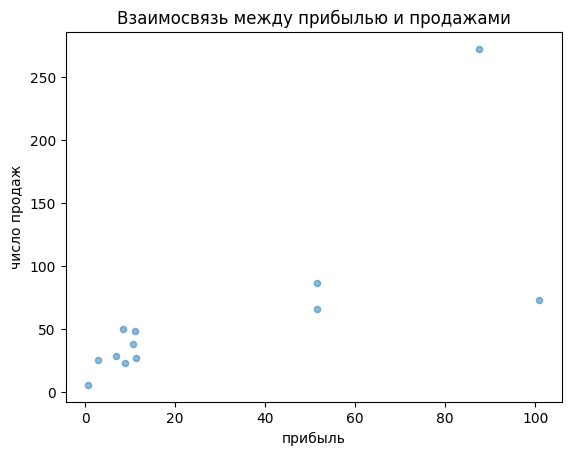

In [105]:
sales_by_genre.plot(x = 'money', y='sales', kind='scatter', alpha=0.5 , \
          xlabel = "прибыль", ylabel = "число продаж",\
          title = "Взаимосвязь между прибылью и продажами");
sales_by_genre.money.corr(sales_by_genre.sales)

0.7794127275224259

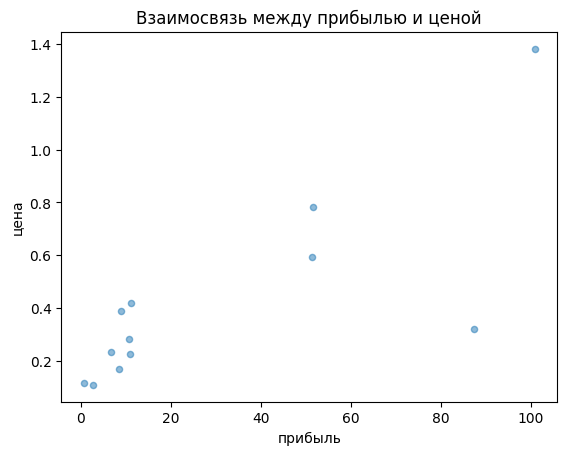

In [106]:
sales_by_genre.plot(x = 'money', y='price', kind='scatter', alpha=0.5 , \
          xlabel = "прибыль", ylabel = "цена",\
          title = "Взаимосвязь между прибылью и ценой");
sales_by_genre.money.corr(sales_by_genre.price)

На обоих графиках прослеживается линейная связь, при этом коэффициенты корреляции у пар прибыль-цена и прибыль-продажи в близки друг другу, значит оба варианта достижения прибыли имеют право быть (продавать много но дешево, продавать мало но дорого).

Проанализируем прибыльность жанров с помощью диаграммы размаха, сравнив медианные продажи на каждом жанре и проверив какой из жанров более стабильный и имеет более длинный ряд успешно продающихся игр

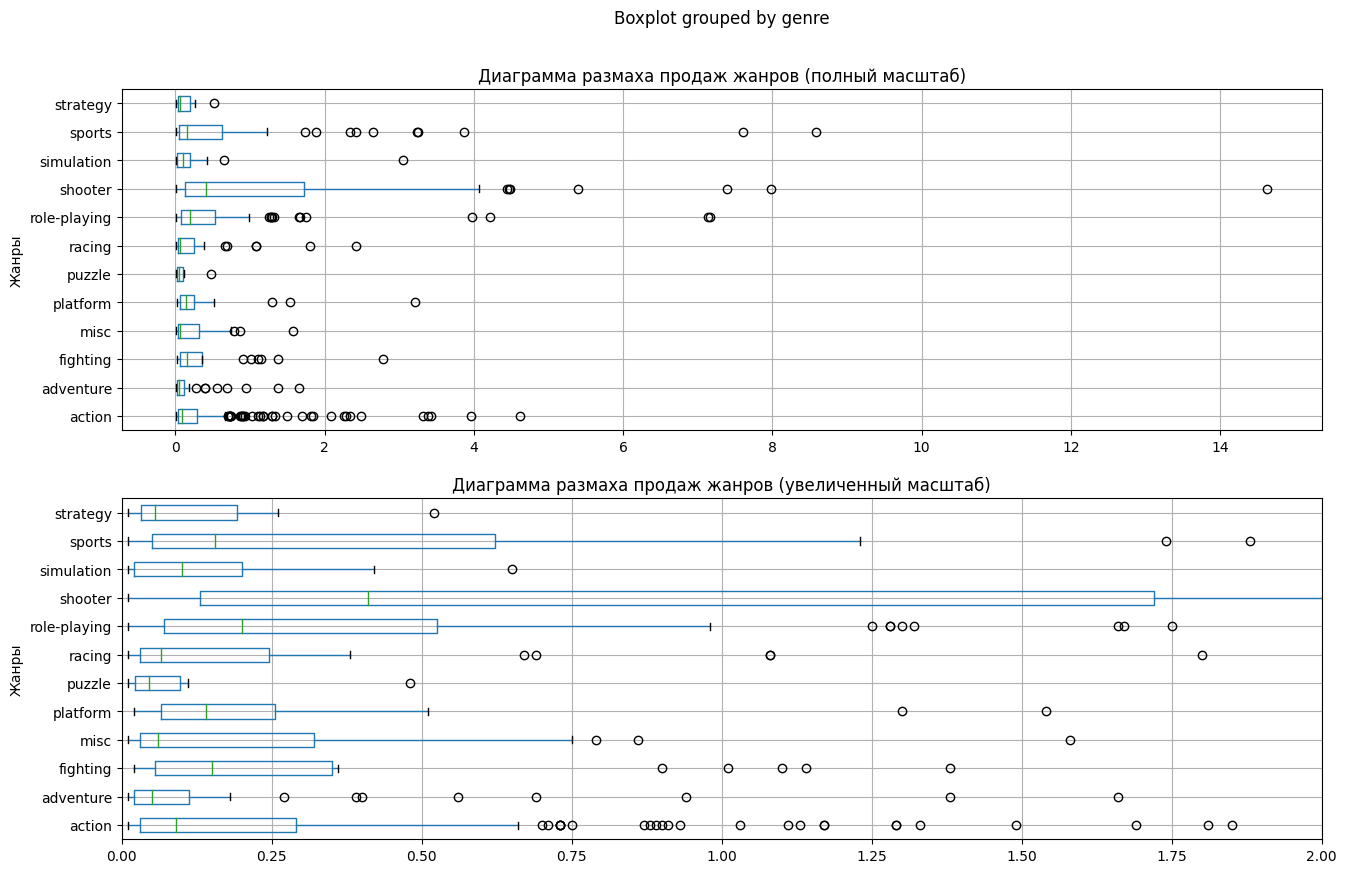

In [107]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, sharey = False, figsize = (15, 10))

#Диаграмма, оригинальный масштаб
ac_data[['genre', 'all_sales']]\
.boxplot(by='genre', vert = False, grid = True, ax = axes[0])
axes[0].set_ylabel('Жанры')
axes[0].set(title = 'Диаграмма размаха продаж жанров (полный масштаб)');

#Диаграмма, увеличенный масштаб
ac_data[['genre', 'all_sales']]\
.boxplot(by='genre', vert = False, grid = True, ax = axes[1])
axes[1].set_ylabel('Жанры')
axes[1].set(title = 'Диаграмма размаха продаж жанров (увеличенный масштаб)', xlim=(0, 2));


По диаграммам размаха видно, что:
- более длинные и стобильные ряды продаж присущи жанрам sports, shooter, role-plaing
- выбросы составляют большую часть продаж у следующих жанров: action, adventure, fighting
- медианные уровни продаж выше у sports, shooter, role-plaing.

#### Выводы относительно особенностей продаваемости игр различных жанров
На основаниии полученных результатов в процессе изучения общего распределения характеристик продаваемости игр по жанрам можно сделать следующие выводы:

1. Наиболее прибыльными в исследуемом периоде являются: 'adventure', 'sports', 'shooter', 'role-playing', 'action'. 
Механизм формирования выручки у этих жанров разный:
- у 'shooter' выручка достигается за счет высокой средней цены с относительно небольшими продажами
- у 'action' и 'adventure' выручка достигается за счет низкой средней цены с очень большими продажами
- у 'role-playing' и 'sports' - средняя цена и среднее число продаж.

 'puzzle', 'platform', 'strategy', 'fighting', 'simulation'
2. Наименее прибыльными в исследуемом периоде являются:  'puzzle', 'platform', 'strategy', 'fighting', 'simulation'. Механизм формирования неудачной выручки у этих жанров разный:
- 'strategy', 'puzzle' - девешые и не смотря на это плохо продающиеся жанры
- 'fighting', 'simulation','platform'  средние по цене, по плохо продающиеся жанры.

При этом из трех стратегий достижения хорошей прибыли:
  - продавать много не очень дорогих игр
  - продавать среднее количество игр среднего ценового сегмента
  - продавать меньше игр, но из более дорого сегмента.
  
стоит отдавать предпочтение тем, которые подходят для покупательской способности аудитории, на которую ориентирован магазин. 

#### Выводы второго этапа исследования, описание наиболее продаваемых платформ и жанров, предположение об основных фактарах, определяющих успешность игр, платформ, жанров

В процессе второго этапа исследования в актульном временном интервале выполнено следующее.
1. Выделены три вендера, игры для латформ которых, стали наиболее продаваемыми: "sony", "nintendo", "microsoft". Суммарные продажи остальных вендеров несоизмеримы с продажами по каждому их них в отделльности. Поэтому далее рассматривались только указанные вендеры и их продукты, среди которых были выделены максимально прибыльные портативные ("psv") и стационарные ("xone", "ps4", "wiiu") платформы. 
2. На основании наблюдений за данными о продажах и сроках жизненного цикла и сменяемости платформ было установлено, что на период с 2017 года вкладываться в приобритение и продажу игр для мобильных платформ скорее всего будет нецелесообразно.
3. Определены ключевые особенности абсолютно успешной платформыактуальной в 2017 году:
 - длительность жизненного цикла больше 8 лет,
 - суммарные продажи по всем играм более 50 млн;
 - рост продаж в период с 2012 до 2015 годов
4. Выявлены четыре перспективные платформы "xone", "ps4", "wiiu", "psv". 
6. Установлено, что на всех перспективных платформах игры с низкими оценками (меньше 40 у критиков и меньше 2 у пользователей практически не продаются, а начиная с оценок 40 (у критиков) и 2 (у пользователей) продажи неравномерно растут с увеличением оценок.
7. Отмечено, что среди перспективных платформ  доля продаваемых игр в привязке к рейтингу схожи у xone и ps4 и сильно отличаются от wiiu и psv. Wiiu - более семейная платформа, игры для нее в основном подходят всем возрастам. xone и ps4 - больше ориентируются на  взрослых, psv - на подростков.
8. Выделены наиболее прибыльные жанры: 'platform', 'role-playing', 'sports', 'shooter' и 'action' и характерные для них механизмы формирования выручки: 
- у 'shooter' выручка достигается за счет высокой средней цены с относительно небольшими продажами
- у 'action' выручка достигается за счет низкой средней цены с очень большими продажами
- у 'role-playing', 'platform' и 'sports' - средняя цена и среднее число продаж.
9. Проанализированы три стратегии достижения хорошей прибыли, каждая из которых должна применяться исходя из покупательской способности предполагаемого потенциального покупателя:
 - продавать много не очень дорогих игр
 - продавать среднее количество игр среднего ценового сегмента
 - продавать меньше игр, но из более дорого сегмента.


### Исследовательский анализ данных. Третий этап. Портрет пользователя

#### Описание различия в долях продаж между пользователями разных регионов

Посмотрим, как распределены доли продаж в целом между регионами.

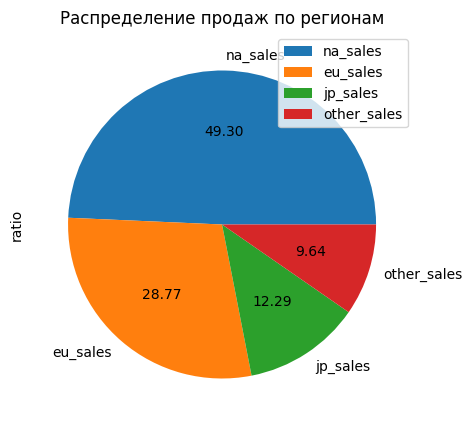

In [108]:
#Круговая диаграмма для распределения долей продаж по регионам 
all_sales = ac_data.all_sales.sum()
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
sales_in_regions = [data[sales_in_region].sum()/all_sales for sales_in_region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']]

sales_in_regions = pd.DataFrame({'regions': regions , 'ratio': sales_in_regions})
sales_in_regions.plot(kind='pie', y = 'ratio', title = "Распределение продаж по регионам",
          autopct="%.2f", figsize = (5, 5), labels = sales_in_regions.regions);

#### Распределение записей по регионам

#### Определение для пользователя каждого региона самых популярных платформ (топ-5)

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих платформ для региона: Америка:


Index(['ps4', 'xone', '3ds', 'wiiu', 'pc'], dtype='object', name='platform')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих платформ для региона: Европа:


Index(['ps4', 'xone', 'pc', '3ds', 'wiiu'], dtype='object', name='platform')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих платформ для региона: Япония:


Index(['3ds', 'ps4', 'wiiu', 'xone', 'pc'], dtype='object', name='platform')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих платформ для региона: Остальные регионы:


Index(['ps4', 'xone', '3ds', 'wiiu', 'pc'], dtype='object', name='platform')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих платформ для региона: Все регионы:


Index(['ps4', 'xone', '3ds', 'wiiu', 'pc'], dtype='object', name='platform')

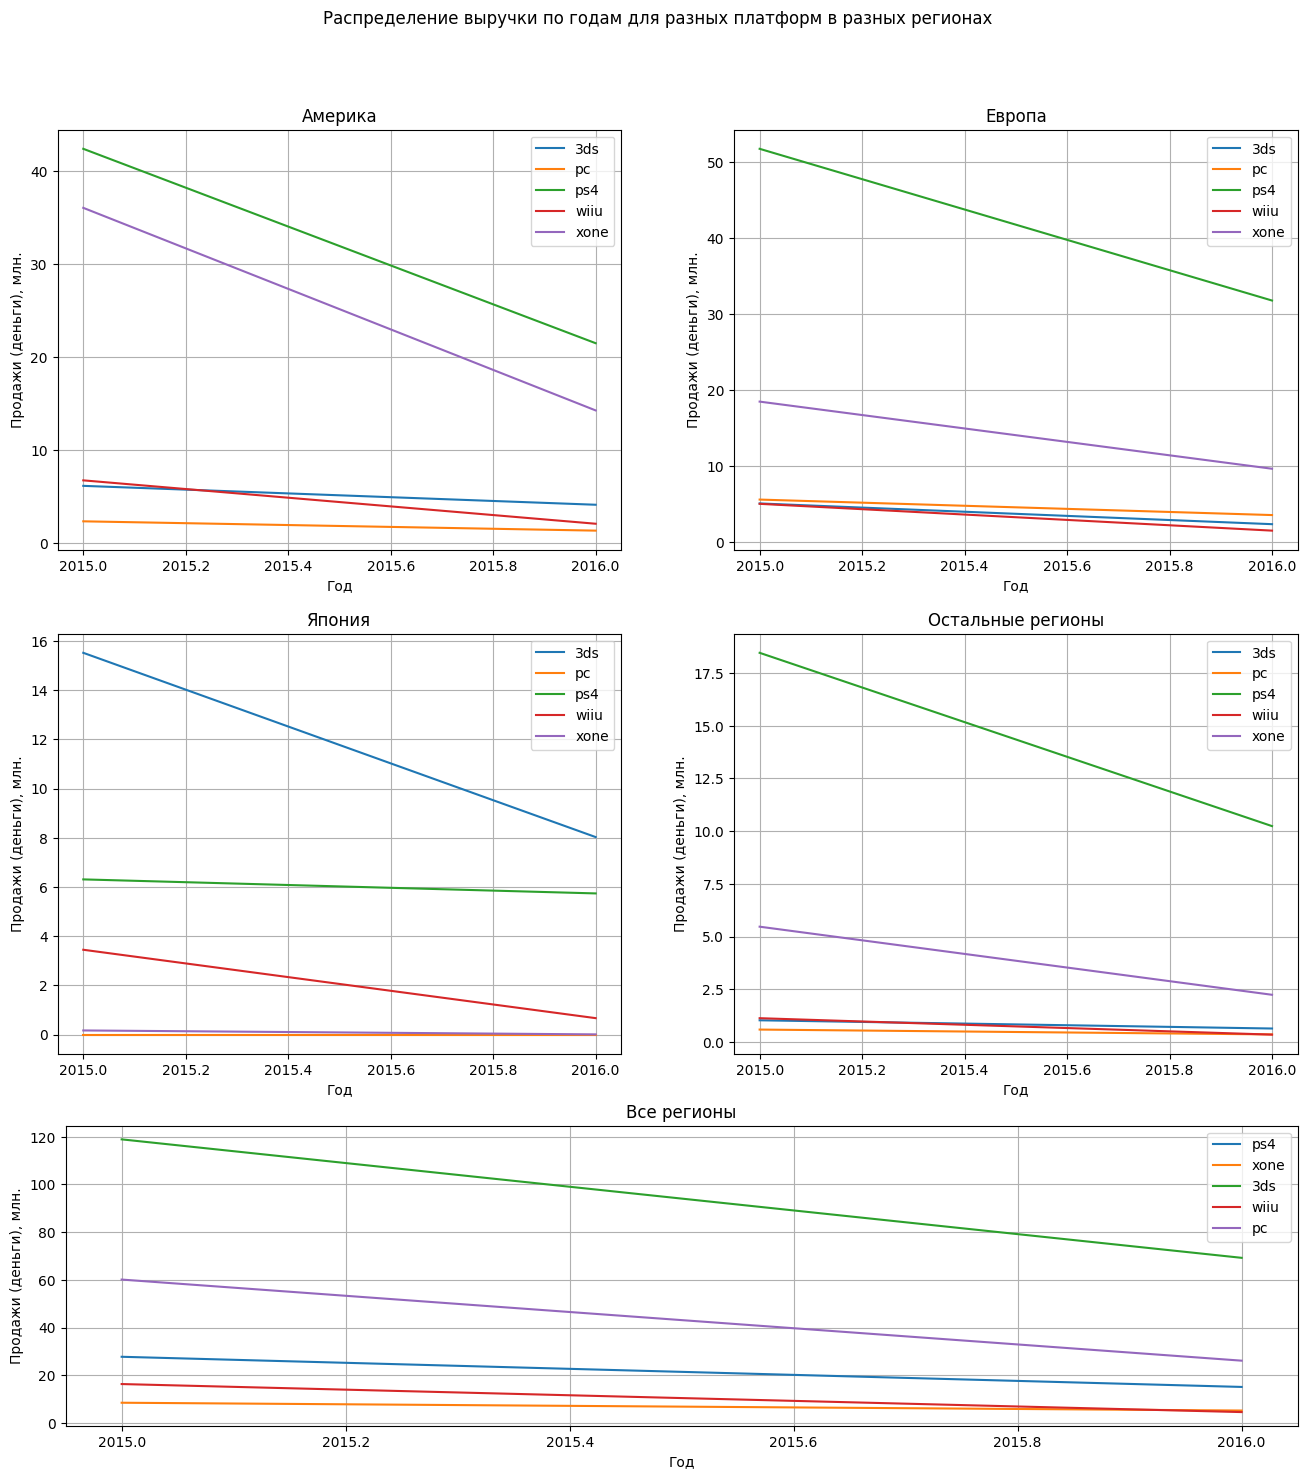

In [109]:
visual_for_sales("platform", "платформ")

Иерархия лидирующих платформ различается в разных регионах. При этом ближе к всего к ранее сформулированному по всему датасету списку лидеров находятся Америка и Европа.Так получилось потому, что основной датасет на 77.8% сформирован именно данными по Европе и Америке.
   Вместе с тем в Японии распределение лидеров совсем другое, на первом месте здесь 3ds  и ps4, при этом практически не продаются игры для xone и pc. Причем лидерующая платформа является мобильной, в то время как ранее при анализе датасета без диффиринциации по регионам были сделаны выводы о неконкурентоспособности портативных устройств по сравнению со стационарными. В Японии практически нет выходных и отпусков, Японцы очень много работают и редко бывают дома, поэтому для них мобильные приставки более актуальны.  
   В связи с изложенным следует применять все ранее сформулированные выводы о характеристиках продаваемости платформ и отдельных игр только для точек продаж, ориентированных на Америку и Европу. Если будет необходимость формирования прогнозов, ориентированных на иные рынки, то необходимо будет сместить фокус на иные платформы .

#### Описание самых популярных жанров (топ-5) между пользователями разных регионов

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих жанров для региона: Америка:


Index(['shooter', 'action', 'sports', 'role-playing', 'fighting', 'misc',
       'platform', 'racing', 'adventure', 'simulation', 'strategy', 'puzzle'],
      dtype='object', name='genre')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих жанров для региона: Европа:


Index(['shooter', 'action', 'sports', 'role-playing', 'racing', 'adventure',
       'fighting', 'simulation', 'misc', 'platform', 'strategy', 'puzzle'],
      dtype='object', name='genre')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих жанров для региона: Япония:


Index(['action', 'role-playing', 'shooter', 'misc', 'simulation', 'platform',
       'fighting', 'sports', 'adventure', 'puzzle', 'strategy', 'racing'],
      dtype='object', name='genre')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих жанров для региона: Остальные регионы:


Index(['shooter', 'action', 'sports', 'role-playing', 'fighting', 'racing',
       'adventure', 'misc', 'platform', 'simulation', 'strategy', 'puzzle'],
      dtype='object', name='genre')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих жанров для региона: Все регионы:


Index(['shooter', 'action', 'sports', 'role-playing', 'fighting', 'misc',
       'racing', 'platform', 'adventure', 'simulation', 'strategy', 'puzzle'],
      dtype='object', name='genre')

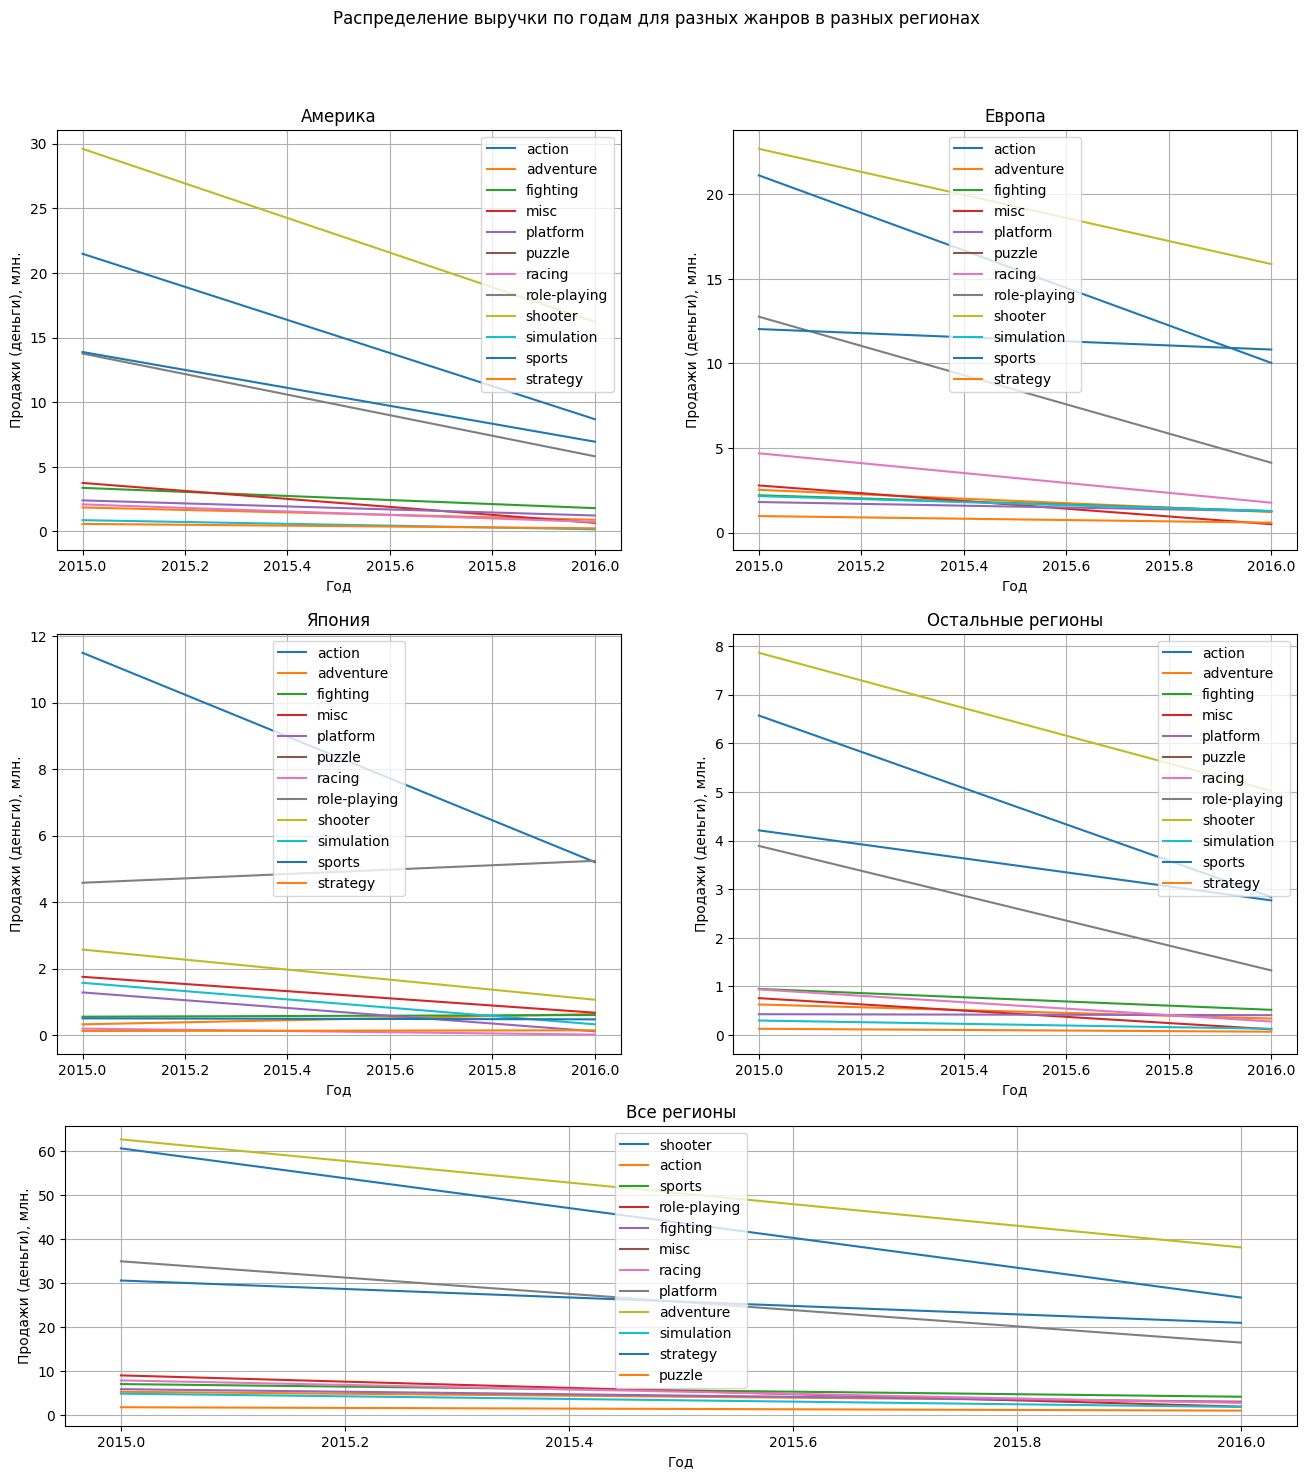

In [110]:
visual_for_sales("genre", "жанров")

   Списки популярных жанров различаются в разных регионах. 
При этом с ранее сформулированным по всему датасету списком лидеров полностью совпадают результаты по Америке (совпадение 5 из 5 ) и практически совпадают результаты по Европе (4 из 5) и остальным регионам (4 из 5). При этом:
1. Во всех регионах кроме Америки лидирует жанр 'action', который догоняет жанр 'shooter'.
2. В Америке лидирует 'shooter', за ним во всех регионах кроме Японии следует 'action'.
2. Японский набор жанров значительно отличается, второй по популярности у них жанр 'role-playing' занимает 4 место в Америке, Европе и остальных регионах.

Таким образом, если магазин Заказчика расположен не в Японии, безпройгрышным будет выбор игр трех наиболее популярных жанров: 'action', 'shooter', 'sports'. 

#### Изучение влияния рейтинга ESRB на продажи в отдельных регионах

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих рейтингов для региона: Америка:


Int64Index([3, 2, 0, 1], dtype='int64', name='rating_score')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих рейтингов для региона: Европа:


Int64Index([3, 0, 1, 2], dtype='int64', name='rating_score')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих рейтингов для региона: Япония:


Int64Index([0, 2, 1, 3], dtype='int64', name='rating_score')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих рейтингов для региона: Остальные регионы:


Int64Index([3, 0, 2, 1], dtype='int64', name='rating_score')

['ps4' 'xone' '3ds' 'wiiu' 'pc']
Список лидирующих рейтингов для региона: Все регионы:


Int64Index([3, 0, 2, 1], dtype='int64', name='rating_score')

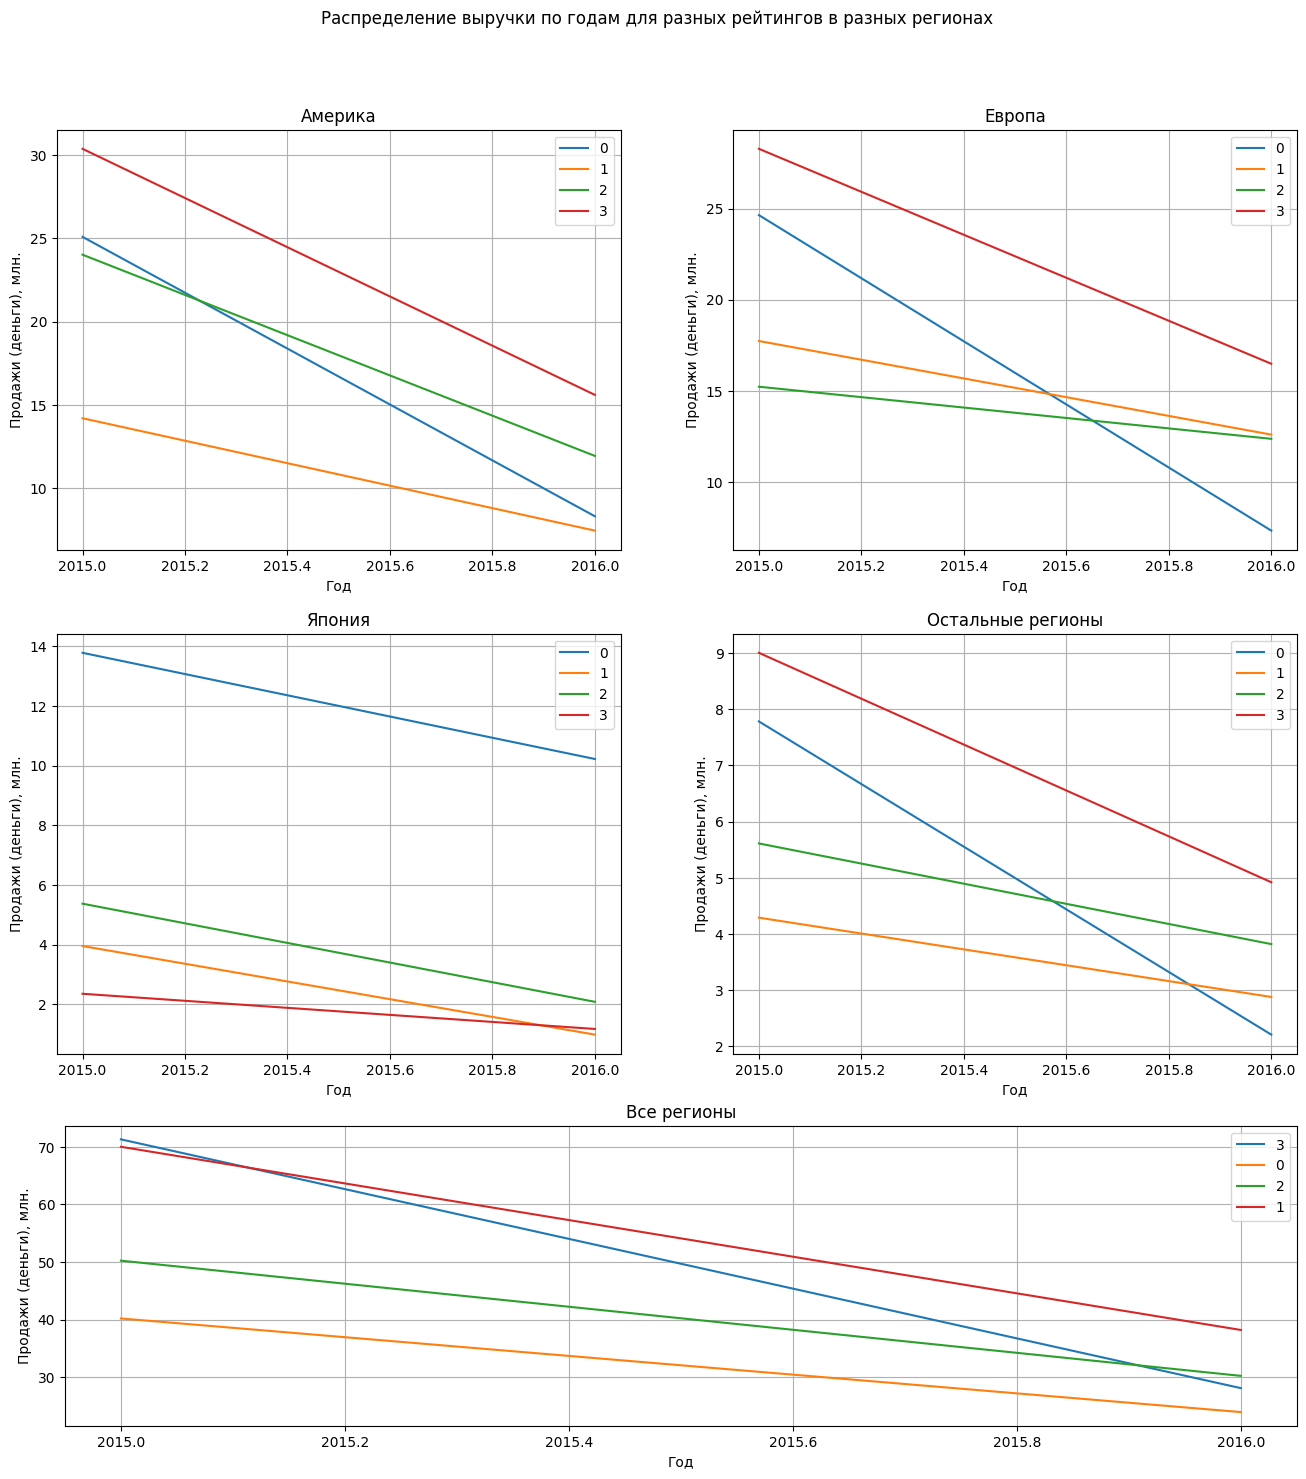

In [111]:
visual_for_sales("rating_score", "рейтингов")

По графикам видно, что рейтинги ESRB абсолютно не применимы Японии. Большинство игр здесь покупались с отсутсвующим рейтингом. Наиболее вероятно это связано с тем, что состав покупаемых игр в Японии сильно отличается отдругих регионов, в частности, от Америки. А ассоциация ESRB очевидно определяет рейтинги только для тех игр, которые планируются к продажам в Америке. 
По остальным регионам картина схожая:
 - до 2013 года игры внутри рейтингов распределялись равномерно 
 - с 2013 года продажи семеыных игр уступают место играм для взрослых. 

#### Выводы третьего этапа. Описание портрета пользователя. Описание характеристик, которые присущи наиболее успешным играм

В процессе третьего этапа исследования в актульном временном интервале выполнено следующее.
1. Проанализированы списки платформ и жанров игр, популярных в разных регионах. 
2. Установлено, предпочтения покупателей из Америки, Европы и "Остальных" относительно выбора платформ (xone, wiiu, ps4, psv) и жанров игр ('action', 'sports', 'shooter', 'misc', 'role-playing') в целом совпадат . 
3. Установлено, что портрет покупателя из Японии сильно отличается от остальных регионов. Там лидируют в основном японские платформы (psv, ps4) и нехарактерные для других регионов жанры ('role-playing','platform'), а также игры, которые не продавались в америке и европе.В связи с чем не следует:
- применять все ранее сформулированные выводы о характеристиках продаваемости платформ к Японскому рынку;
- применять показатели рейтинга ESRB к оценке японских продаж.
4. Определено, что при выборе игр на последующие периоды, следует учитвапть, что Америке и Европе наблюдается тенденцияснижения доли игр из категории "Для всех" (семейный контент) и роста доли игр из категории для взрослых. 

### Статистический анализ. Проверка гипотез

При проверке обеих гипотез уровень статистическойзначимости установим равному 10 %. Брать меньше нецелесообразно, так как размер выборок у нас очень небольшой.

#### Проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Нулевая гипотеза: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"
Альтернативная гипотеза: "Средние пользовательские рейтинги платформ Xbox One и PC НЕ одинаковые"

In [112]:
#Отбор выборок одинакового размера для проверки гипотезы
data_with_pc = \
data[data['year_of_release'] > 2012].query('platform == "pc" and user_score.notna()').user_score
data_with_xone =\
data[data['year_of_release'] > 2012].query('platform == "xone" and user_score.notna()').user_score[:len(data_with_pc)]

if len(data_with_pc) > len(data_with_xone):
    data_with_pc = data_with_pc[:len(data_with_xone)]
else:
    data_with_xone = data_with_xone[:len(data_with_pc)]

#Расчет p-value
results = st.ttest_ind(data_with_pc, data_with_xone, equal_var = False)

# alpha = уровень значимости (вероятность, с которой выявленное (не)совпадение матожиданий будет случайным)
alpha = 0.1

# условный оператор с выводом строки с ответом
if results.pvalue > alpha:
    print(f''' Рассчитанное значение p-value составило {results.pvalue}. 
               Основания отвергнуть нулевую гипотезу отсутсвуют''')
else:
    print(f''' Рассчитанное значение p-value составило {results.pvalue}. 
               Вероятность случайности ошибки слишком мала. Отвергаем нулевую гипотезу''')

 Рассчитанное значение p-value составило 0.07027481881715454. 
               Вероятность случайности ошибки слишком мала. Отвергаем нулевую гипотезу


#### Проверка гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные"

 - Нулевая гипотеза: "Средние пользовательские рейтинги жанров Action и Sports РАВНЫ"
 - Альтернативная гипотеза: "Средние пользовательские рейтинги жанров Action и Sports НЕРАВНЫ"

In [113]:
#Отбор выборок одинакового размера для проверки гипотезы
data_with_action = data.query('genre == "action" and user_score.notna()').user_score
data_with_sports = data.query('genre == "sports" and user_score.notna()').user_score
if len(data_with_action) > len(data_with_sports):
    data_with_action = data_with_action[:len(data_with_sports)]
else:
    data_with_sports = data_with_sports[:len(data_with_action)]
   
#Расчет p-value
results = st.ttest_ind(data_with_action, data_with_sports, equal_var = False)

# alpha = уровень значимости (вероятность, с которой выявленное расхождение матожиданий будет случайным)
alpha = 0.05

# условный оператор с выводом строки с ответом
if results.pvalue > alpha:
    print(f''' Рассчитанное значение p-value составило {results.pvalue}. 
               Основания отвергнуть нулевую гипотезу отсутсвуют''')
else:
    print(f''' Рассчитанное значение p-value составило {results.pvalue}. 
               Вероятность случайности ошибки слишком мала. Отвергаем нулевую гипотезу''')

 Рассчитанное значение p-value составило 0.6261758685624446. 
               Основания отвергнуть нулевую гипотезу отсутсвуют


Таким образом мы не отвергли нулевую гипотезу (о том, что cредние пользовательские рейтинги жанров Action и Sports РАВНЫ), значит предположение о том, что cредние пользовательские рейтинги жанров Action и Sports НЕРАВНЫ следует считать неверным. 

### Итоговые выводы.

### Краткое описание проделанной работы
 Целью исследования было подготовить методологию обработки данных и разработать алгоритм, с помощью которого можно предсказать плтформы, продажи по которым будут успешными в предстоящем периоде.

В процессе исследования решены следующие задачи.
1. Проведена предобработка данных: 
 - 1.1 Названия всех столбцов приведены к стилю snake_case с использованием символов нижнего регистра. При этом столбец Name переименован в game_name чтобы не нарушать работу методов pandas.
-  1.2. Данные в столбцах приведены к оптимальным типам:
- столбец "year_of_release"  - в целое число (int);
- столбец "user_score" - в число с плавающей запятой (float);
- столбцы со строковыми параметрами - в состояние lower.
 - 1.3. Проведена обработка пропусков, включающая:
- анализ природы связи между имеющимися пропусками;
- контроль формы распределения значений в датасете до и после обработки;
- исключение из датасета строк с пропусками в столбцах "genre";
- заполнение подстановочными значениями пропусков в столбцах "rating"(заглушка "unknown"), "game_name" (заглушка "unknown");
- заполнение пропусков в столбцах "user_score", "critic_score" медианными значениями по характерным группам с учетом нескольких объединяющих факторов (регион + год + платформа + жанр), там, где их можно рассчитать, с сохранением пропусков там, где рассчитать медианные значения не удалось из-за недостатка данных.
 - 1.4. Проведена проверка на дубликаты по столбцам "rating", "platform" и обработка дубликатов в столбце rating
 - 1.5. Проверены ошибки в данных. Удалены строки с некорректными данными по продажам.
 - 1.6. В датасет добавлены столбцы:
- "vender" - для категоризации данных по производителям платформ;
- "form" - для категоризации данных по типу платформ (мобильные, консольные);
- "critic_type" - для категаризации данных по группам оценок критиков (высокие, низкие, средние);
- "user_type" - для категаризации данных по группам оценок пользователей (высокие, низкие, средние);
- "rating_score" - для категаризации данных по возрастным группам рейтингов (0 - 'rp' и 'unknown',  1 - 'e' и 'k-a', 2 - 'ec', 3 - 'e10+', 4 - 't', 5 - 'm', 6 - 'ao')
- "all_sales" - с данными о суммарных продажах по всем регионам.
2. В результате предобработки суммарно удалено 5.8% записей и при этом статистические показатели данных не изменились, а оставшиеся записи стали более пригодными для дальнейшего анализа. 
3. На первом этапе исследовательского анализа:
- изучение группировки по годам (количество игр, важные временные периоды);
- изучение группировки по платформам (выбор наиболее популярных платформ, углубленный анализ срезов по годам, определение сроков "жизненного цикла" платформ);
- изучение временных характеристик "продаваемости" по платформам (какие лидируют, какие растут, какаие падают);
- выбрано 5 потенциальноприбыльных платформы;
- выбран временной период (с 2014 года), на основании которого целесообразно строить предположения о продажах (прогноз) на следующий (в данныом случае) 2017 год;
4. На втором этапе исследовательского анализа:
- рассмотрена выборка данных актуального периода;
- проанализированы группировки по лидирующим платформам, ящик с усами по глобальным продажам;
- изучено влияния на продажи внутри одной платформы отзывов пользователей и критиков
- изучено влияния на продажи внутри одной платформы рейтингов игр;
- рассмотрено распределения игр по жанрам, выявлены наиболее и наименее прибыльные жанры,
- сформулированы принципы формирования прибыли, связанные с выбором различных жанров;
5. На третьем этапе исследовательского анализа:
- определены самые популярные платформы (топ-5) для пользователя каждого региона;
- изучено различие в долях продаж между пользователями разных регионов;
- изучено распределение самых популярных жанров (топ-5) между пользователями разных регионов;
- рассмотрено влияния рейтинга ESRB на продажи в отдельных регионах;
6. На этапе статистического анализ проверены гипотезы:
- "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" (опровергнута);
- "Средние пользовательские рейтинги жанров Action и Sports разные" (опровергнута).

При планировании стратегии на следующий год (в нашем случае 2017) магазину видеоигр, не ориентированному на рынок Японии стоит:
1. Ориентироваться на продукты трех вендеров sony, nintendo, microsoft и следующие платформы:
 - sony - 'ps4',
 - microsoft - 'xone', 
 - nintendo - 'wiiu',
 - 'pc'
 - sony - '3ds' (портативная)
2. При оценке успешности конкретных платформ стоит учитывать их:
 - суммарные продажи;
 - длительность жизненного цикла;
 - среднее число продаж на год жизненного цикла
 - приемлимость средней стоимости игры для покупательской  способности целевой аудитории  
 - характерные для платформы жанры и их ориентированность на целевую аудиторию магазина
 - характерные для платформы возрастные рейтинги и их ориентированность на целевую аудиторию магазина.
3. Для достижения ожидаемой прибыли при продаже игр допустимо (в зависимости от покупательской способности целевой аудитории):
 - продавать много не очень дорогих игр
 - продавать среднее количество игр среднего ценового сегмента
 - продавать мало дорогих игр 
4. При выборе игр для решений конкретных вендеров стоит учитывать, что:
- на всех успехных платформах игры с низкими оценками (меньше 40 у критиков и меньше 2 у пользователей практически не продаются, а начиная с оценок 40 (у критиков) и 2 (у пользователей) продажи неравномерно растут с увеличением оценок.
- доля продаваемых игр в привязке к рейтингу схожи у microsoft и sony и сильно отличаются от nintendo. 
- nintendo выпускает более семейные платформs, игры для которых в основном подходят всем возрастам,microsoft и sony - больше ориентируются на взрослых;
- наиболее прибыльными жанрами являются: 'role-playing', 'misc', 'shooter', 'sports' и 'action', при этом: 
    - у 'shooter' выручка достигается за счет высокой средней цены с относительно небольшими продажами
    - у 'action' выручка достигается за счет низкой средней цены с очень большими продажами
    - у 'role-playing', 'platform' и 'sports' - средняя цена и среднее число продаж.
  
- при выборе игр на последующие периоды, следует также учитвать, что в Америке и Европе наблюдается тенденция  снижения доли игр из категории "Для всех" (семейный контент) и роста доли игр из категории для взрослых. 

Более подробно рассмотренные закономерности изложены в выводах по каждому этапу исследования.
